# Анализ данных о продаже автомобилей на рынке Приднестровья

Данные будут загружатся со следующего источника http://klaksona.net/

## Выбор параметров

In [1]:
RS = 654321
TS = 0.3

выбор рандом стаит и тест сплит

In [2]:
passs = 60

Выбор доли пропусков в столбцах подлежащих удалению

In [3]:
eur = 0.95

курс евро к доллару

In [4]:
pmr = 16.5

курс пмр к доллару

In [1]:
multicol = 0.999

уровень мультиколлениарности выбранный для baseline

# Импорт библиотек и функций

In [6]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
import phik
import time
import shap
import tqdm
from tqdm import tqdm
from collections import Counter
import requests
from bs4 import BeautifulSoup as bs
from urllib.parse import urlencode
import json
from ydata_profiling import ProfileReport
import re
import sys
import pickle
from transliterate import translit
from category_encoders import TargetEncoder

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import root_mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector 

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.utils.class_weight import compute_class_weight

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from imblearn.over_sampling import ADASYN

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

In [7]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_seq_items', 1000)
np.set_printoptions(threshold=sys.maxsize)
warnings.filterwarnings("ignore")
pd.options.mode.copy_on_write = True 
tqdm.pandas() 

In [8]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Загрузка функций

In [9]:
# Функция парсинга, которая создает датафрейм, в который добавляет информацию об индентификаторе, названии, ссылки, бренде, 
# дате парсинга, объеме двигателя, годе выпуска двигателя и цене автомобиля
j=1
def parsing_2(url):
    data = pd.DataFrame(columns=['id', 'title', 'url', 'date_parsing', 'brend',  'volume', 'тип_двигателя', 'год', 'prise']) 
    reqx = requests.get('http://klaksona.net/index.php?do=avtorynok-pmr&model_ids=Array&page=1')
    soup = bs(reqx.text, 'html.parser')
    element = soup.findAll('a', class_="ajax_link")
    max_page = int(element[-8].text)
    for j in tqdm(range(1,max_page)):        
        reqx = requests.get('http://klaksona.net/index.php?do=avtorynok-pmr&model_ids=Array&page=' + str(j))
        soup = bs(reqx.text, 'html.parser')
        element = soup.findAll('div', class_='border_type_0')
        datax = []
        for i in element:
            datax.append({'id'  : i.find('a')['href'].split('/')[-1].replace('.html',''),
                          'title' : i.find('h1').text.lstrip(' ').rstrip(' '),
                          'url' : i.find('a')['href'],
                          'brend' : i.find('h1').text.split(' ')[2],
                          'date_parsing' : pd.to_datetime('today').normalize(),
                          'volume'  : i.find('tr').text.split('\r\n')[3].replace(' ',''),
                          'тип_двигателя' : i.find('tr').text.split('\r\n')[7].replace(' ',''),
                          'год' : i.find('td').text.lstrip(' ').rstrip(' ').split(' ')[1].replace('г.',''),
                          'prise' : (str(i.find('tr').text.lstrip(' ').rstrip(' ').split(' ')[3]) + 
                                     str(i.find('tr').text.lstrip(' ').rstrip(' ').split(' ')[4]) + 
                                     str(i.find('tr').text.lstrip(' ').rstrip(' ').split(' ')[5]))
                         })
        datax = pd.DataFrame(datax)
        data = pd.concat([data, datax] , ignore_index=True)
    return data

In [10]:
# Функция которая добавляет в датафрейм дополнительную информацию а также информацию о классе автомобиля, типе кузова, 
# состоянии автомобиля, количестве дверей, потребляемом топливе и типе коробки передач, наличии и типе климатической системы, 
# аудиосистемы, а также информацию о контактном лице его телефоне и дате размещения объявления


def add_details(x):
    reqx = requests.get(x)
    soup = bs(reqx.text, 'html.parser')
    element = soup.findAll('div', class_='container')
    lists = element[0].text.split('\n')
    if lists.count('Дополнительная информация:'):
        dop_info = lists.pop(lists.index('Дополнительная информация:') + 1).strip()
    else:
        dop_info = np.NaN
    if lists.count('Класс автомобиля:'):
        class_auto = lists.pop(lists.index('Класс автомобиля:') + 1).replace(' ','')
    else:
        class_auto = np.NaN
    if lists.count('Тип кузова:'):
        body = lists.pop(lists.index('Тип кузова:') + 1).replace(' ','')
    else:
        body = np.NaN
    if lists.count('Состояние:'):
        state = lists.pop(lists.index('Состояние:') + 1).replace(' ','')
    else:
        state = np.NaN  
    if lists.count('Кол-во дверей:'):
        door = lists.pop(lists.index('Кол-во дверей:') + 1).replace(' ','')
    else:
        door = np.NaN
    if lists.count('Потребляемое топливо:'):
        fuel = lists.pop(lists.index('Потребляемое топливо:') + 1).replace(' ','')
    else:
        fuel = np.NaN
    if lists.count('Коробка передач:'):
        transmission = lists.pop(lists.index('Коробка передач:') + 1).replace(' ','')
    else:
        transmission = np.NaN
    if lists.count('Кондиционер:'):
        conditioner = lists.pop(lists.index('Кондиционер:') + 1).replace(' ','')
    else:
        conditioner = np.NaN
    if lists.count('Аудиосистема:'):
        audio = lists.pop(lists.index('Аудиосистема:') + 1).replace(' ','')
    else:
        audio = np.NaN
    if lists.count('Пробег'):
        mileage = lists.pop(lists.index('Пробег') + 1).replace(' ','')
    else:
        mileage = np.NaN
    if lists.count('Контактное лицо'):
        contact = lists.pop(lists.index('Контактное лицо') + 1).replace(' ','')
    else:
        contact = np.NaN
    if lists.count('Телефон'):
        fone = lists.pop(lists.index('Телефон') + 1).replace(' ','')
    else:
        fone = np.NaN
    if lists.count('Размещено:'):
        date_notice = lists.pop(lists.index('Размещено:') + 1).replace(' ','')
    else:
        date_notice = np.NaN
    
    return pd.Series([dop_info, class_auto, body, state, door, fuel, transmission, conditioner, audio, mileage, contact, fone, date_notice])

In [11]:
# Функция преобразования даты загрузки объявления
def rename_date(x):
    x = str(x)
    dat = x[:-5] + ' ' + x[-5:]
    dat = dat.replace('сегодняв', str((df.loc[0, 'date_parsing']).strftime('%d.%m.%Y')))
    dat = dat.replace('вчерав', str((df.loc[0, 'date_parsing'] - pd.Timedelta(days=1)).strftime('%d.%m.%Y')))
    return dat

In [12]:
# Функция которая вырезает модель автомобиля из его названия
def model_name(x):
    x = str(x)
    x = x.split()
    return " ".join(x[1:])            

In [13]:
# функция которая формирует цену
def norm_price(x):
    if 'руб' in x:
        return round(int(x[:-4])/pmr)
    elif '$' in x:
        return round(int(x[:-1]))
    elif '€' in x:
        return round(int(x[:-1])*eur)
    else:
        return np.nan

In [14]:
# Функция для отображения количественного признака    
def show_numeric_feature(df, column, title, x_label, y_label):
    """
    Отображает гистограмму и "ящик с усами" для количественного признака.
    Параметры:
    - df: Датасет.
    - column: Название колонки признака.
    - title: Заголовок диаграммы.
    - x_label: Название оси X.
    - y_label: Название оси Y.   
    Пример:
    ```
    show_numeric_feature(market_file_df, 
                         'выручка',
                         'Выручка за период',
                         'Выручка',
                         'Количество покупателей')
    ```
    """    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    plt.suptitle(title.upper(), fontsize=16, ha='center')
    sns.histplot(data=df[column], color='g', kde=False, ax=axes[0], bins=30) 
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_label)
    axes[0].tick_params(labelrotation=45)
    sns.boxplot(x=df[column], color='c')
    axes[1].set_xlabel(y_label)
    plt.show()
    print('Описание признака:', x_label)
    display(df[column].describe().T)
    
    
# Функция для отображения количественного признака по списку
def show_numeric_feature_by_list(df, features):
    """
    Отображает гистограмму и "ящик с усами" для количественного признака
    по списку.

    Параметры:
    - df: Датасет.
    - features: Список признаков для отображения.
   
    Пример:
    ```
    show_numeric_feature_by_list(market_file_df, 
        market_file_numeric_features)
    ```
    """    
    for feature in features:
        title = 'признак ' + feature
        column = feature
        x_label = 'признак ' + feature
        y_label = 'Количество'
        show_numeric_feature(df, column, title, x_label, y_label)        
        


In [15]:
def show_categorical_feature_by_list(df, features, targets, top):
    """
    Отображает ящик с усами и круговую диаграммы для категориального признака
    по списку
    Параметры:
    - df: Датасет.
    - features: Список признаков для отображения. 
    - targets: таргет.
    - top: количество отображаемых групп котегориального признака.
    Пример:
    ```
    show_categorical_feature_by_list(df,  categorical_nominal_features, 
    targets, 15)
    ```
    """
    for feature in features:
        data = df.copy()
        data[feature] = data[feature].fillna(value='NoInfo')
        value_counts = data[feature].value_counts()
        if len(value_counts) > top:
            top_10 = value_counts.head(top).index        
            data[feature] = data[feature].apply(lambda x: x if x in top_10 else "другие") 
        else:
            data = data

        mean_target = data.groupby(feature)[targets].mean()
        data['category_encoded'] = data[feature].map(mean_target)
        mi = mutual_info_regression(data[['category_encoded']], data[targets])
        print('-'*150)
        print(f"Зависимость признака {feature.upper()} от таргета: {round(mi[0],2)}")
        grouped = data.groupby(feature)[targets].agg(['mean', 'median', 'count'])
        print(grouped)
        
        title = 'признак ' + feature
        column = feature
        x_label = 'признак ' + feature
        y_label = 'Цена' 
        targets = targets
        #show_categorical_feature(data, column, title, x_label, y_label, targets)
        cat_df = data[column].value_counts()
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))
        plt.suptitle(title.upper(), fontsize=16, ha='center')
        sns.boxplot(x=column, ax=axes[0], palette='viridis', y=targets, data=data)
        
        axes[0].set_xlabel(x_label)
        axes[0].set_ylabel(y_label)
        axes[0].tick_params(axis='x', labelrotation=90)
        
        plt.pie(cat_df, 
                labels=cat_df.index, 
                autopct='%1.1f%%', 
                wedgeprops = { 'linewidth': 3, 'edgecolor': 'white' })
        axes[1].set_xlabel(x_label)
        plt.show()

In [16]:
#вспомогательная функция для построяния ящика с усами над гистограммой
def hist_underbox(data,title=None):
    """
    Отображает гистограмму и "ящик с усами" для количественного признака.
    Параметры:
    - data: Датасет.
    - title: Заголовок диаграммы.
    Пример:
    ```
        hist_underbox(data=df[col], title=f'Распределение признака "{col}"')
    ```
    """
    custom_params = {"axes.spines.right": False, "axes.spines.top": False};
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True,
                                        gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(x=data, ax=ax_box).set_title(title)
    sns.histplot(x=data, ax=ax_hist, kde=True)
    ax_box.set(yticks=[])
    ax_box.set_xlabel("")
    ax_hist.set_ylabel("Количество")
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    mean = ax_hist.axvline(data.mean(), color='r', lw=2)
    median = ax_hist.axvline(data.median(), color='k', ls='--', lw=2)
    ax_hist.legend([mean, median], [f'Среднее значение = {round(data.mean(),2)}',
                                    f'Медиана = {round(data.median(),2)}'],
                                    loc='best')

In [17]:
# Функция удаления фичей из датасета
def del_features(delete_features, categorical_nominal_features, categorical_ordinal_features, numerical_features, df):
    """
    Удаляет признаки из датасета. Возвращает обьновленный датасет и списки числовых и категориальных признаков.
    Параметры:
    - delete_features: список признков для удаления.
    - categorical_nominal_features: список номинальных признаков.
    - categorical_ordinal_features: список порядковых признаков.
    - numerical_features: список числовых признаков.
    - df: Датасет.
    Пример:
    ```
        features, categorical_features, numerical_features, df = del_features(
        delete_features, features, categorical_ordinal_features, numerical_features, df)
    ```
    """
    df = df.drop(columns = delete_features)
    features = [categorical_nominal_features, categorical_ordinal_features, numerical_features]
    for i in delete_features:
        for j in features:
            if i in j:
                j.remove(i)
    print(delete_features)
    if len(target + categorical_nominal_features + categorical_ordinal_features + numerical_features) == len(df.columns):
        print('OK')
    else:
        print('НЕ_ОК')   
    return categorical_nominal_features, categorical_ordinal_features, numerical_features, df

In [18]:
# Подготовка функции создания моделей
def create_model(model_name, pipeline, param_grid, X_train, X_test, y_train, y_test, scorer, scoring, models, results_models_rm,  ):
    """
    Создает, обучает, выбирает лучшие результаты для заданной модели.
    Возвращает датасет и словарь с параметрами моделей.

    Параметры:
    - model_name: тип модели.
    - pipeline: пайплайн модели.
    - param_grid: параметры для обучения модели.
    - X_train: признаки для обучения модели.
    - y_train: целевой признак для обучения модели.
    - X_test: признаки для тестирования модели.
    - y_test: целевой признак для тестирования модели.
    - scorer: тип метрики.
    - models: словарь с параметрами моделей.
    - results_models: датасет с параметрами моделей.   
   
    Пример:
    ```
        results_models, models = create_model(model_name, pipeline, param_grid, X_train,
        X_test, y_train, y_test, scorer, models, results_models)
    ```
    """
    # Создание модели
    grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=5, scoring=scoring)
    # Обучение модели
    start_time = time.time()    
    grid_search.fit(X_train, y_train)        
    models[model_name]['training_time'] = round(time.time() - start_time, 2)
    # Сохраненение модели с лучшими результами
    models[model_name]['best_model'] = grid_search.best_estimator_
    # Формирование предсказаний
    start_time = time.time()
    models[model_name]['predictions'] = models[model_name]['best_model'].predict(X_train)
    models[model_name]['best_parametrs'] = grid_search.best_params_   
    #models[model_name]['probas'] = models[model_name]['best_model'].predict_proba(X_train)[:,1]    
    models[model_name]['prediction_time'] = round(time.time() - start_time, 2)
    # Сохранение лучшей метрики
    models[model_name]['cv'] = round(grid_search.best_score_, 4)
    # Влияние на модель фичей
    models[model_name]['grid_search'] = grid_search
    predictions_test = grid_search.predict(X_test)
    predictions_train = grid_search.predict(X_train)

    #best_model = grid_search.best_estimator_.[0]

    if 'RandomForest' in model_name or 'CatBoost' in model_name or 'LGBM' in model_name:
        models[model_name]['feature_importances'] = grid_search.best_estimator_.named_steps['regressor'].feature_importances_
        models[model_name]['get_feature_names_out'] = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
    else:
        models[model_name]['feature_importances'] = [0]
        models[model_name]['get_feature_names_out'] = [0]        

    models[model_name]['train'] = round(scorer(y_train, predictions_train),2)
    models[model_name]['test'] = round(scorer(y_test, predictions_test),2)
    models[model_name]['test_MAE'] = round(mean_absolute_error(y_test, predictions_test),2)


    results_models_rm = pd.concat([results_models_rm, pd.DataFrame([([
        model_name,
        models[model_name]['cv'],
        models[model_name]['train'],
        models[model_name]['test'],
        models[model_name]['test_MAE'],
        models[model_name]['training_time'], 
        models[model_name]['prediction_time'],
        models[model_name]['best_parametrs'],
        ])],columns=columns_results_models_v1)], ignore_index=True)

    results_models_rm['best_parametrs'] = results_models_rm['best_parametrs'].astype(str)
    results_models_rmx = results_models_rm.drop_duplicates(['model', 'cv', 'train', 'test', 'test_MAE', 
                                                            'training_time', 'prediction_time', 'best_parametrs'] ,keep='first')
    results_models_rmx = results_models_rmx.reset_index(drop=True)
    results_models_rm.to_csv('results_models_rm.csv', index=False)  

    print(f'Модель {model_name}')
    print('-' * 70) 
    print(f"метрика - {scoring}")
    print(f"метрика модели на трейне: {round(scorer(y_train, predictions_train),2)}")
    print(f"метрика модели на тесте: {round(scorer(y_test, predictions_test),2)}")
    print(f"MAE модели на тесте: {round(mean_absolute_error(y_test, predictions_test),2)}")
    print(f"метрика лучшей модели на кроссвалидации: {round(grid_search.best_score_,2)}")
    print('-' * 70)
    print(f'Время обучения: {models[model_name]["training_time"]} сек.')
    print(f'Время предсказания: {models[model_name]["prediction_time"]} сек.')
    #print(f'{scorer.upper()}: {models[model_name][scorer]}')
    print(f'Лучшие параметры: {models[model_name]["best_parametrs"]}')
    #print(f'Лучшая модель:{models[model_name]["best_model"]}')

    with open("models.pkl", "wb") as f:
        pickle.dump(models, f)

    residuals = y_test - predictions_test
    absolute_errors = np.abs(residuals)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

    axes[0].scatter(y_test, predictions_test, alpha=0.7, color="blue", label="Предсказания")
    axes[0].plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--", label="Идеальная линия")
    axes[0].set_xlabel("Истинные значения")
    axes[0].set_ylabel("Предсказания")
    axes[0].set_title("Истинные значения vs. Предсказания")
    axes[0].legend()

    axes[1].scatter(predictions_test, residuals, color='green', alpha=0.7)
    axes[1].axhline(y=round(mean_absolute_error(y_test, predictions_test),2), color='blue', linestyle=':')
    axes[1].axhline(y=-round(mean_absolute_error(y_test, predictions_test),2), color='blue', linestyle=':')
    axes[1].axhline(y=0, color='red', linestyle='--')
    axes[1].set_xlabel("Предсказания")
    axes[1].set_ylabel("Остатки")
    axes[1].set_title("График остатков")

    axes[2].scatter(predictions_test, absolute_errors, color='orange', alpha=0.7)
    axes[2].axhline(y=round(mean_absolute_error(y_test, predictions_test),2), color='red', linestyle='--')
    axes[2].set_xlabel("Предсказания")
    axes[2].set_ylabel("Абсолютная ошибка")
    axes[2].set_title("График абсолютных ошибок")

    plt.tight_layout()
    plt.show()
     
    return results_models_rmx, models

In [19]:
# Подготовка функции создания моделей
def create_ren_model(model_name, pipeline, param_serch, X_train, X_test, y_train, y_test, scorer, scoring, models, results_models_rm, RS, n_iter  ):
    """
    Создает, обучает, выбирает лучшие результаты для заданной модели.
    Возвращает датасет и словарь с параметрами моделей.

    Параметры:
    - model_name: тип модели.
    - pipeline: пайплайн модели.
    - param_serch: параметры для обучения модели.
    - X_train: признаки для обучения модели.
    - y_train: целевой признак для обучения модели.
    - X_test: признаки для тестирования модели.
    - y_test: целевой признак для тестирования модели.
    - scorer: тип метрики.
    - models: словарь с параметрами моделей.
    - results_models_rm: датасет с параметрами моделей. 
    - RS: Рендом стайт.
    - n_iter: количество итераций выполнения модели.  
   
    Пример:
    ```
        results_models, models = create_model(model_name, pipeline, param_serch, X_train,
        X_test, y_train, y_test, scorer, models, results_models, RS, n_iter)
    ```
    """
    # Создание модели
    grid_search = RandomizedSearchCV(pipeline, param_distributions=param_serch, n_iter=n_iter, n_jobs=-1, cv=5, scoring=scoring, random_state=RS)
    # Обучение модели
    start_time = time.time()    
    grid_search.fit(X_train, y_train)        
    models[model_name]['training_time'] = round(time.time() - start_time, 2)
    # Сохраненение модели с лучшими результатами
    models[model_name]['best_model'] = grid_search.best_estimator_
    # Формирование предсказаний
    start_time = time.time()
    models[model_name]['predictions'] = models[model_name]['best_model'].predict(X_train)
    models[model_name]['best_parametrs'] = grid_search.best_params_   
    #models[model_name]['probas'] = models[model_name]['best_model'].predict_proba(X_train)[:,1]    
    models[model_name]['prediction_time'] = round(time.time() - start_time, 2)
    # Сохранение лучшей метрики
    models[model_name]['cv'] = round(grid_search.best_score_, 4)
    # Влияние на модель фичей
    models[model_name]['grid_search'] = grid_search

    #best_model = grid_search.best_estimator_.named_steps['regressor']

    if 'RandomForest' in model_name or 'CatBoost' in model_name or 'LGBM' in model_name:
        models[model_name]['feature_importances'] = grid_search.best_estimator_.named_steps['regressor'].feature_importances_
        models[model_name]['get_feature_names_out'] = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
    else:
        models[model_name]['feature_importances'] = [0]
        models[model_name]['get_feature_names_out'] = [0]     
        
    predictions_test = grid_search.predict(X_test)
    predictions_train = grid_search.predict(X_train)

    models[model_name]['train'] = round(scorer(y_train, predictions_train),2)
    models[model_name]['test'] = round(scorer(y_test, predictions_test),2)
    models[model_name]['test_MAE'] = round(mean_absolute_error(y_test, predictions_test),2)


    results_models_rm = pd.concat([results_models_rm, pd.DataFrame([([
        model_name,
        models[model_name]['cv'],
        models[model_name]['train'],
        models[model_name]['test'],
        models[model_name]['test_MAE'],
        models[model_name]['training_time'], 
        models[model_name]['prediction_time'],
        models[model_name]['best_parametrs'],
        ])],columns=columns_results_models_v1)], ignore_index=True)

    results_models_rm['best_parametrs'] = results_models_rm['best_parametrs'].astype(str)
    results_models_rmx = results_models_rm.drop_duplicates(['model', 'cv', 'train', 'test',  'test_MAE',
                                                            'training_time', 'prediction_time', 'best_parametrs'] ,keep='first')
    results_models_rmx = results_models_rmx.reset_index(drop=True)
    results_models_rm.to_csv('results_models_rm.csv', index=False)  

    print(f'Модель {model_name}')
    print('-' * 70)        
    print(f"метрика - {scoring}")
    print(f"метрика модели на трейне: {round(scorer(y_train, predictions_train),2)}")
    print(f"метрика модели на тесте: {round(scorer(y_test, predictions_test),2)}")
    print(f"MAE модели на тесте: {round(mean_absolute_error(y_test, predictions_test),2)}")
    print(f"метрика лучшей модели на кроссвалидации: {round(grid_search.best_score_,2)}")
    print('-' * 70) 
    print(f'Время обучения: {models[model_name]["training_time"]} сек.')
    print(f'Время предсказания: {models[model_name]["prediction_time"]} сек.')
    #print(f'{scorer.upper()}: {models[model_name][scorer]}')
    print(f'Лучшие параметры: {models[model_name]["best_parametrs"]}')
    #print(f'Лучшая модель:{models[model_name]["best_model"]}')

    with open("models.pkl", "wb") as f:
        pickle.dump(models, f)
    
    residuals = y_test - predictions_test
    absolute_errors = np.abs(residuals)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

    axes[0].scatter(y_test, predictions_test, alpha=0.7, color="blue", label="Предсказания")
    axes[0].plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--", label="Идеальная линия")
    axes[0].set_xlabel("Истинные значения")
    axes[0].set_ylabel("Предсказания")
    axes[0].set_title("Истинные значения vs. Предсказания")
    axes[0].legend()

    axes[1].scatter(predictions_test, residuals, color='green', alpha=0.7)
    axes[1].axhline(y=round(mean_absolute_error(y_test, predictions_test),2), color='blue', linestyle=':')
    axes[1].axhline(y=-round(mean_absolute_error(y_test, predictions_test),2), color='blue', linestyle=':')
    axes[1].axhline(y=0, color='red', linestyle='--')
    axes[1].set_xlabel("Предсказания")
    axes[1].set_ylabel("Остатки")
    axes[1].set_title("График остатков")

    axes[2].scatter(predictions_test, absolute_errors, color='orange', alpha=0.7)
    axes[2].axhline(y=round(mean_absolute_error(y_test, predictions_test),2), color='red', linestyle='--')
    axes[2].set_xlabel("Предсказания")
    axes[2].set_ylabel("Абсолютная ошибка")
    axes[2].set_title("График абсолютных ошибок")

    plt.tight_layout()
    plt.show()
    
    return results_models_rmx, models

In [20]:
columns = []
def snake_case(x):
    """
    Приводит названия колонок к snake_case.
    Параметры:
    - x: Датасет.
   
    Пример:
    ```
        preprocessing(data)
    ```
    """
    
    x.columns = [translit(i, 'ru', reversed=True).lower().
                 replace('\\', '_').
                 replace('/', '_').
                 replace(' ', '_').
                 replace('.', '_').
                 replace(',', '_').
                 replace('(', '_').
                 replace(')', '_').
                 replace(':', '_').
                 replace('-', '_').
                 replace('+', 'plus').
                 replace('*10^9', '_в_9_ст_').
                 replace('*10^12', '_в_12_ст_').                 
                 replace('%', '_pct').
                 replace('__', '_').
                 replace('__', '_').
                 rstrip('_') for i in x.columns]    

In [21]:
def preprocessing(x):
    
    """
    Отображает информацию о датасете.
    Параметры:
    - x: Датасет.
   
    Пример:
    ```
        preprocessing(data)
    ```
    """    
    print(f'таблица имеет следующий вид:')
    display(x.head())
    print('*'*100)
    print(f'таблица имеет {x.shape[0]} сторок и {x.shape[1]} столбцов')
    print('*'*100)
    print(f'в таблице обнаружено дубликатов:{x.duplicated().sum()}')
    print('*'*100)
    print('в таблице обнаружены пропуски в следующих столбцах:')
    display(x.isna().sum())
    print('*'*100)
    print('Эти пропуски составлябт следующее количество в процентах')
    display((x.isna().mean()* 100).round(1))
    print('*'*100)
    print('столбцы имеют следующие типы:')
    display(x.dtypes)
    print('*'*100)
    print('названия столбцов переписаны в нижнем регистре, пробелы заменены на нижнее подчеркивание')
    print('*'*100)
    display(x.info())
    display(x.describe(include='all').T)

In [22]:
def plot_feature_importance(importance,names,model_type):
    """
    Отображает диаграмму значимости признаков модели.

    Параметры:
    - importance: информация о значимости признаков модели.
    - names: список признаков.
    - model_type: название модели.
   
    Пример:
    ```
        plot_feature_importance(top_model.steps[-1][1].feature_importances_, X_train.columns, "CATBOOST_")
    ```
    """    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,18))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [23]:
def plot_feature_importance_10(importance,names,model_type):
    """
    Отображает диаграмму значимости признаков модели.

    Параметры:
    - importance: информация о значимости признаков модели.
    - names: список признаков.
    - model_type: название модели.
   
    Пример:
    ```
        plot_feature_importance(top_model.steps[-1][1].feature_importances_, X_train.columns, "CATBOOST_")
    ```
    """    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df.head(10)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [24]:
def find_outliers(df, numerical_features, multiplier=1.5):
    """
    Функция для поиска выбросов в числовых столбцах DataFrame.

    Параметры:
        df: pandas.DataFrame
            Исходный DataFrame.
        
        multiplier: float, optional
            Множитель для метода IQR. По умолчанию 1.5.

    Возвращает:
        pandas.DataFrame:
            Булев DataFrame с True для выбросов.
    """

    outliers = pd.DataFrame(False, index=df.index, columns=df.columns)

    for col in numerical_features:
        q1 = df[col].quantile(0.25)  # Первый квартиль
        q3 = df[col].quantile(0.75)  # Третий квартиль
        iqr = q3 - q1               # Межквартильный размах
        lower_bound = q1 - multiplier * iqr
        upper_bound = q3 + multiplier * iqr
        # Найти выбросы в текущем столбце
        outliers[col] = (df[col] < lower_bound) | (df[col] > upper_bound)

    return outliers

In [25]:
def replace_xcn(x):
    """
    Обрабатывает строку или число и возвращает:
    - Число как `float`, если входное значение содержит одно число.
    - Среднее арифметическое как `float`, если входное значение содержит диапазон чисел, разделенных дефисом (`-`).

    Параметры:
    ----------
    x : str, int, float
        Входное значение. Может быть:
        - Строка с одним числом, например, "5".
        - Строка с диапазоном чисел, например, "3-7".
        - Целое или вещественное число.

    Возвращает:
    ----------
    float
        Если входное значение — одно число, возвращается его преобразование в `float`.
        Если входное значение — диапазон, возвращается среднее арифметическое чисел диапазона.
   

    Примеры:
    --------
    >>> replace_xcn("5")
    5.0
    >>> replace_xcn("3-7")
    5.0
    >>> replace_xcn(10)
    10.0
    >>> replace_xcn("8-12")
    10.0
    """
    x = str(x).split('-')
    if len(x) == 1:
        return float(x[0])
    else:
        return (int(x[0]) + int(x[1]))/2

In [26]:
def info_car(col):
    return pd.DataFrame({ col:([df[col].isna().sum(), 
                (df[col].isna().mean()* 100).round(1), 
                df[col].count(), 
                df[col].nunique(), 
                df[col].dtypes,
                df[~(df[col].isna())][col].sample(1).values[0]]),}, index=['isna','isna_pst','count','nunique','dtypes','sample'])

# Загрузка данных

In [27]:
oll_url=['http://klaksona.net/index.php?do=avtorynok-pmr&model_ids=Array&page=']

In [28]:
#df = parsing_2(oll_url)

In [29]:
#tqdm.pandas()
#df[['dop_info', 'class_auto', 'body', 'state', 'door', 'fuel',
#   'transmission', 'conditioner', 'audio', 'mileage', 'contact',
#   'fone', 'date_notice']] = df['url'].progress_apply(add_details)

In [30]:
#df.head()

In [31]:
#df.to_csv('csv/klakson2.csv', index=False) 

In [32]:
df = pd.read_csv('csv/klakson2.csv')

# Предобработка данных

In [33]:
df.head(2)

id             title  \
0  auto1727728    Toyota Avensis   
1  auto1727727  Volkswagen Caddy   

                                                  url date_parsing  \
0  http://klaksona.net/avtorynok-pmr/auto1727728.html   2025-01-28   
1  http://klaksona.net/avtorynok-pmr/auto1727727.html   2025-01-28   

        brend volume тип_двигателя   год  prise  \
0      Toyota   2000   Турбодизель  2009  5900$   
1  Volkswagen   2000    Бензин-Газ  2007  6200$   

                                                                                                                                                                                                                                                                                                                                         dop_info  \
0  • Toyota Avensis 2009 г.в. T27• Двигатель 2.0 D4D 126 лошадок.• Свежепригнана из Италии .• Машина в отличном состоянии.• Расход топлива: Город - 7 л/100 км, Трасса 5л/100 км.• Ходовая сбитая , ничего не стучит и не гремит .• По кузову ни грамма ржавчины нет .• Обмен ! Возможен Автокредит !• Не растаможена 5900$. На ПМР номерах 6900$   
1                                                                                                                                                                                                                                                                                                                                             NaN   

  class_auto       body     state door    fuel   transmission     conditioner  \
0   Легковой  универсал  Отличное  4/5  дизель  6-тиступ.мех.  климатконтроль   
1   Легковой    минивен  Отличное  4/5  бензин  5-тиступ.мех.  климатконтроль   

                                 audio   mileage  \
0  автомагнитолаCD/MP3(сUSBиBluetooth) 212000.00   
1          автомагнитолаCD/MP3(безUSB)    190.00   

                                  contact       fone    date_notice  
0  Toyota(Всеобъявленияэтогопользователя)  077910407  сегодняв21:32  
1                                   Caddy   77742794  сегодняв21:23

In [34]:
start_shape = df.shape
start_shape

(11475, 22)

## Преобразование колонок

In [35]:
snake_case(df)

In [36]:
df.columns

Index(['id', 'title', 'url', 'date_parsing', 'brend', 'volume',
       'tip_dvigatelja', 'god', 'prise', 'dop_info', 'class_auto', 'body',
       'state', 'door', 'fuel', 'transmission', 'conditioner', 'audio',
       'mileage', 'contact', 'fone', 'date_notice'],
      dtype='object')

## Предобработка дублекатов

In [37]:
df.groupby('id')['title'].count().sort_values(ascending=False)

id
auto1677052    2
auto1067203    1
auto1700472    1
auto1700340    1
auto1700404    1
              ..
auto1614886    1
auto1614970    1
auto1615088    1
auto1615091    1
auto799009     1
Name: title, Length: 11474, dtype: int64

In [38]:
df[df.duplicated()]

id                title  \
5331  auto1677052  Спецтехника Автобус   

                                                     url date_parsing  \
5331  http://klaksona.net/avtorynok-pmr/auto1677052.html   2025-01-28   

            brend     volume tip_dvigatelja   god                     prise  \
5331  Спецтехника  неуказано      неуказано  1915  договорная\n\n\n\n\n\n\n   

     dop_info class_auto body state door fuel transmission conditioner audio  \
5331      NaN        NaN  NaN   NaN  NaN  NaN          NaN         NaN   NaN   

      mileage                                contact    fone      date_notice  
5331      NaN  иииии(Всеобъявленияэтогопользователя)  111111  13.08.202412:09

In [39]:
df[df['id']=='auto1677052']

id                title  \
5330  auto1677052  Спецтехника Автобус   
5331  auto1677052  Спецтехника Автобус   

                                                     url date_parsing  \
5330  http://klaksona.net/avtorynok-pmr/auto1677052.html   2025-01-28   
5331  http://klaksona.net/avtorynok-pmr/auto1677052.html   2025-01-28   

            brend     volume tip_dvigatelja   god                     prise  \
5330  Спецтехника  неуказано      неуказано  1915  договорная\n\n\n\n\n\n\n   
5331  Спецтехника  неуказано      неуказано  1915  договорная\n\n\n\n\n\n\n   

     dop_info class_auto body state door fuel transmission conditioner audio  \
5330      NaN        NaN  NaN   NaN  NaN  NaN          NaN         NaN   NaN   
5331      NaN        NaN  NaN   NaN  NaN  NaN          NaN         NaN   NaN   

      mileage                                contact    fone      date_notice  
5330      NaN  иииии(Всеобъявленияэтогопользователя)  111111  13.08.202412:09  
5331      NaN  иииии(Всеобъявленияэтогопользователя)  111111  13.08.202412:09

In [40]:
df = df.drop_duplicates()

Удалили дубликаты из данных.

## Преобразование признака дата парсинга

In [41]:
info_car('date_parsing')

date_parsing
isna                0
isna_pst         0.00
count           11474
nunique             1
dtypes         object
sample     2025-01-28

In [42]:
df['date_parsing'] = pd.to_datetime(df['date_parsing'], format = '%Y-%m-%d')

Приобразовали признак в тип datetime64

## Преобразование признака дата загрузки обявления

In [43]:
info_car('date_notice')

date_notice
isna                    0
isna_pst             0.00
count               11474
nunique             11117
dtypes             object
sample    03.12.202411:31

In [44]:
df[df['date_notice'].isna()]

Empty DataFrame
Columns: [id, title, url, date_parsing, brend, volume, tip_dvigatelja, god, prise, dop_info, class_auto, body, state, door, fuel, transmission, conditioner, audio, mileage, contact, fone, date_notice]
Index: []

In [45]:
df = df[~(df['date_notice'].isna())]

Удаляем данные с пропусками в признаке дата загрузки

In [46]:
df['date_notice'] = df['date_notice'].apply(rename_date)

In [47]:
df['date_notice'] = pd.to_datetime(df['date_notice'], format = '%d.%m.%Y %H:%M')

In [48]:
df['manth'] = df['date_notice'].dt.to_period('M')

приобразовали признак в тип datetime64 и вычислили из данного признака новый признак с месяцем и годом загрузки обявления

## преобразование признака класс автомобиля

In [49]:
info_car('class_auto')

class_auto
isna           2903
isna_pst      25.30
count          8571
nunique           7
dtypes       object
sample     Легковой

In [50]:
df.class_auto.unique()

array(['Легковой', nan, 'Грузовой', 'спецтехника', 'Мототехника',
       'Водныйтраспорт', 'Автобус', 'Велотехника'], dtype=object)

In [51]:
df = df[(df['class_auto'].isin(['Легковой'])) | (df['class_auto'].isna())]

Оставили только легковые и грузовые автомобили а также данные у которых нет информащии об этом признаке

## преобразование признака title

In [52]:
info_car('title')

title
isna                                 0
isna_pst                          0.00
count                            10906
nunique                            709
dtypes                          object
sample    Mercedes-Benz E-klasse E 270

In [53]:
keywords = [
    "Комплектующие", "комплеткующие", "Велотехника", "Сдам", 
    "водный ", "Куплю", "Спецтехника", "Возьму", "Дом", "Мотоколяска"
]
pattern = "|".join(keywords)
df = df[~df['title'].str.contains(pattern, case=False, regex=True)].reset_index(drop=True)

In [54]:
df['model'] = df['title'].apply(model_name)

Оставили в данных только данные с автомобилями, которые продаются а также добавили признак модель автомобиля вырезанныйй из названия автомобиля

## преобразование признака объем автомобиля

In [55]:
info_car('volume')

volume
isna           0
isna_pst    0.00
count       9006
nunique      405
dtypes    object
sample         3

In [56]:
df['volume'] = df['volume'].replace('неуказано', np.NaN)
df['volume'] = df['volume'].astype(float)

In [57]:
df.loc[df['volume'] > 8000 ,'volume'] = np.NaN

In [58]:
df.loc[df['volume'] < 10 ,'volume'] = df['volume'] * 1000

In [59]:
df.loc[df['volume'] < 50 ,'volume'] = df['volume'] * 100

In [60]:
df.loc[df['volume'] < 1000, 'volume'] = np.NaN

Удалили информацию об объеме для объявлений с ошибочным объемом.

## преобразование признака тип_двигателя  

In [61]:
info_car('tip_dvigatelja')

tip_dvigatelja
isna                  0
isna_pst           0.00
count              9006
nunique               9
dtypes           object
sample           Дизель

In [62]:
df.tip_dvigatelja.unique()

array(['Турбодизель', 'Бензин-Газ', 'Гибрид', 'Бензин', 'CDI',
       'неуказано', 'Электро', 'Дизель', 'Компрессор'], dtype=object)

In [63]:
df.loc[df['tip_dvigatelja']=='неуказано', 'tip_dvigatelja'] = np.NaN
df.loc[df['tip_dvigatelja']=='CDI', 'tip_dvigatelja'] = 'Дизель'
df.loc[df['tip_dvigatelja']=='Компрессор', 'tip_dvigatelja'] = 'Бензин'
df.loc[df['tip_dvigatelja']=='Турбодизель', 'tip_dvigatelja'] = 'Дизель'

## Преобразование признака цена

In [64]:
info_car('prise')

prise
isna           0
isna_pst    0.00
count       9006
nunique      821
dtypes    object
sample     9500$

In [65]:
df['prise'] = df['prise'].apply(norm_price)

In [66]:
df = df[~((df['prise']< 1000)|(df['prise'] > 90000))]

In [67]:
df['q_prise'] = pd.cut(df['prise'], bins=15, labels=[_ for _ in range(15)])

In [68]:
df['q_prise'] = df['q_prise'].apply(
    lambda x: 'A' if x == 0 else
              'B' if x == 1 else
              'C' if x == 2 else
              'D' if x == 3 else
              'E' if x in (4, 5) else
              'F'
)

преобразовали данные посредством функции и удалили данные о машинах дешевле 1000 Добавили прихнак с категорией цены автомобиля 

## Преобразование признака доп инфо

In [69]:
info_car('dop_info')

dop_info
isna                         987
isna_pst                   12.40
count                       6977
nunique                     6679
dtypes                    object
sample    Высоковольтная батарея

In [70]:
df['len_dop_info'] = df['dop_info'].apply(lambda x: len(str(x)) )

Добавили признак длина строки о дополнительной информации

## Преобразование признака год

In [71]:
info_car('god')

god
isna          0
isna_pst   0.00
count      7964
nunique      83
dtypes    int64
sample     2014

In [72]:
df.god.unique()

array([2009, 2007, 1997, 2012, 2008, 2013, 2015, 2011, 2018, 2006, 1999,
       2019, 2016, 2010, 2014, 1995, 2003, 1998, 1990, 2024, 1987, 2022,
       2021, 2002, 2001, 1991, 1996, 1993, 2017, 2004, 2005, 2000, 1994,
       1992, 1989, 2020, 2023, 1988, 1980, 1986, 1985, 1984, 1901, 1916,
       1903, 1927, 1906, 1983, 1935, 1921, 1981, 1905, 1902, 1915, 1982,
       1912, 1956, 1913, 1900, 1918, 1966, 1965, 1974, 1937, 1917, 1914,
       1979, 1908, 1904, 1958, 1923, 1924, 1977, 1932, 1947, 1970, 1973,
       1972, 1975, 1968, 1967, 1978, 1960], dtype=int64)

In [73]:
df = df[~((df['god']>2019)&(df['god']<10000))]

In [74]:
df = df[~((df['god']>2019)&(df['prise'].isna())&(df['len_dop_info']<200))]

удалили неверные данные за последние 6 лет

## Преобразование признака body

In [75]:
info_car('body')

body
isna         1201
isna_pst    15.60
count        6483
nunique        18
dtypes     object
sample    минивен

In [76]:
df.body.unique()

array(['универсал', 'минивен', 'хетчбек', nan, 'внедорожник', 'седан',
       'кроссовер', 'купе', 'кабриолет', 'фургон', 'грузовой',
       'микроавтобус', 'автобус', 'спецтехника', 'лимузин', 'велотехника',
       'комплектующие/деталь', 'пикап', 'мототехника'], dtype=object)

In [77]:
df = df[~(df['body'].isin(['комплектующие/деталь','велотехника','мототехника','спецтехника','прицеп']))]

удалили из данных объявления относящиеся к мототехнике, спецтехнике прицепам и запчастям

## Преобразование признака state

In [78]:
info_car('state')

state
isna         1057
isna_pst    13.80
count        6617
nunique         6
dtypes     object
sample    Хорошее

In [79]:
df.state.unique()

array(['Отличное', 'Хорошее', 'Новый', nan, 'Удовлетворительное',
       'Битыйавто', 'Плохое'], dtype=object)

Даннный признак не изменяли.

## Преобразование признака door

In [80]:
info_car('door')

door
isna        1340
isna_pst   17.50
count       6334
nunique        3
dtypes    object
sample       4/5

In [81]:
df.door.unique()

array(['4/5', nan, '2/3', '6/7'], dtype=object)

Даннный признак не изменяли.

## Преобразование признака fuel

In [82]:
info_car('fuel')

fuel
isna        1088
isna_pst   14.20
count       6586
nunique        4
dtypes    object
sample       газ

In [83]:
df.fuel.unique()

array(['дизель', 'бензин', nan, 'газ', 'электро'], dtype=object)

Даннный признак не изменяли.

## Преобразование признака transmission

In [84]:
info_car('transmission')

transmission
isna                884
isna_pst          11.50
count              6790
nunique               6
dtypes           object
sample    5-тиступ.мех.

In [85]:
df.transmission.unique()

array(['6-тиступ.мех.', '5-тиступ.мех.', 'автомат', nan, '4-ёхступ.мех.',
       'роботизированая', 'полуавтомат'], dtype=object)

Даннный признак не изменяли.

## Преобразование признака conditioner

In [86]:
info_car('conditioner')

conditioner
isna                1637
isna_pst           21.30
count               6037
nunique                3
dtypes            object
sample    климатконтроль

In [87]:
df.conditioner.unique()

array(['климатконтроль', 'кондиционер', nan, 'безкондиционера'],
      dtype=object)

Даннный признак не изменяли.

## Преобразование признака audio

In [88]:
info_car('audio')

audio
isna               2352
isna_pst          30.60
count              5322
nunique               4
dtypes           object
sample    автомагнитола

In [89]:
df.audio.unique()

array(['автомагнитолаCD/MP3(сUSBиBluetooth)',
       'автомагнитолаCD/MP3(безUSB)', 'автомагнитолаHi-End', nan,
       'автомагнитола'], dtype=object)

Даннный признак не изменяли.

## Преобразование признака mileage

In [90]:
info_car('mileage')

mileage
isna          1719
isna_pst     22.40
count         5955
nunique       1134
dtypes     float64
sample   310000.00

In [91]:
df['mileage_orig'] = df['mileage'].copy()
df.loc[df['mileage_orig']<5000, 'mileage_orig'] = np.NaN
df.loc[df['mileage_orig']>600000, 'mileage_orig'] = np.NaN

In [92]:
df.loc[df['mileage']==1, 'mileage']  = np.NaN
df.loc[df['mileage']==2, 'mileage']  = 200000
df.loc[df['mileage']==3, 'mileage']  = 300000
df.loc[df['mileage']==4, 'mileage']  = 400000
df.loc[df['mileage']==5, 'mileage']  = 50000

In [93]:
df.loc[(df['mileage']<20)&(df['god']<2015), 'mileage'] = df['mileage'] * 10000
df.loc[(df['mileage']<20)&(df['god']>=2015), 'mileage'] = df['mileage'] * 1000

In [94]:
df.loc[(df['mileage']<50)&(df['god']<2017), 'mileage'] = df['mileage'] * 10000
df.loc[(df['mileage']<50)&(df['god']>=2017), 'mileage'] = df['mileage'] * 1000

In [95]:
df.loc[df['mileage']<100, 'mileage']  = df['mileage'] * 10000

In [96]:
df.loc[df['mileage']<1000, 'mileage']  = df['mileage'] * 1000

In [97]:
df.loc[(df['mileage']<10000)&(df['god']<2017), 'mileage'] = df['mileage'] * 100
df.loc[(df['mileage']<10000)&(df['god']>=2017), 'mileage'] = df['mileage'] * 10

In [98]:
df.loc[(df['mileage']<50000)&(df['god']<2017), 'mileage'] = df['mileage'] * 10

In [99]:
df.loc[df['mileage']>600000, 'mileage'] = np.NaN

Добавили прихнак с оризинальной информацией о пробеге автомобиля удалив из него информацию об автомобилях с пробегом менее 5000 и более 600000 км.
Исправили ошибки в признаке с информацией о прбеге

## Преобразование признака contact

In [100]:
info_car('contact')

contact
isna                                            5
isna_pst                                     0.10
count                                        7669
nunique                                      1409
dtypes                                     object
sample    Евгений(Всеобъявленияэтогопользователя)

In [101]:
df['contact'] = df['contact'].apply(lambda x: str(x).replace('(Всеобъявленияэтогопользователя)',''))

Обработали информацию о имени пользователя

## Преобразование признака fone

In [102]:
info_car('fone')

fone
isna             0
isna_pst      0.00
count         7674
nunique       4806
dtypes      object
sample    77972703

In [103]:
df['fone'] = df['fone'].apply(lambda x: str(x).replace('+','').replace('-','')
                              .replace('(','').replace(')','')[-8:])

In [104]:
df.loc[(df['fone'].apply(lambda x: len(x) < 8))&(df['fone']!='nan'), 'fone'] = 00000000

In [105]:
df['id'].nunique()

7674

Обработали информацию о номерах телефонов продавцов

## Работа с пропусками

In [106]:
(df.isna().mean()* 100).round(2).reset_index().sort_values(by=0, ascending=False)

index     0
26    mileage_orig 52.76
17           audio 30.65
18         mileage 25.68
16     conditioner 21.33
8            prise 21.02
24         q_prise 21.02
13            door 17.46
11            body 15.65
10      class_auto 14.97
14            fuel 14.18
12           state 13.77
9         dop_info 12.68
5           volume 12.12
15    transmission 11.52
6   tip_dvigatelja  8.67
7              god  0.00
21     date_notice  0.00
25    len_dop_info  0.00
2              url  0.00
23           model  0.00
22           manth  0.00
4            brend  0.00
20            fone  0.00
19         contact  0.00
3     date_parsing  0.00
1            title  0.00
0               id  0.00

<Axes: >

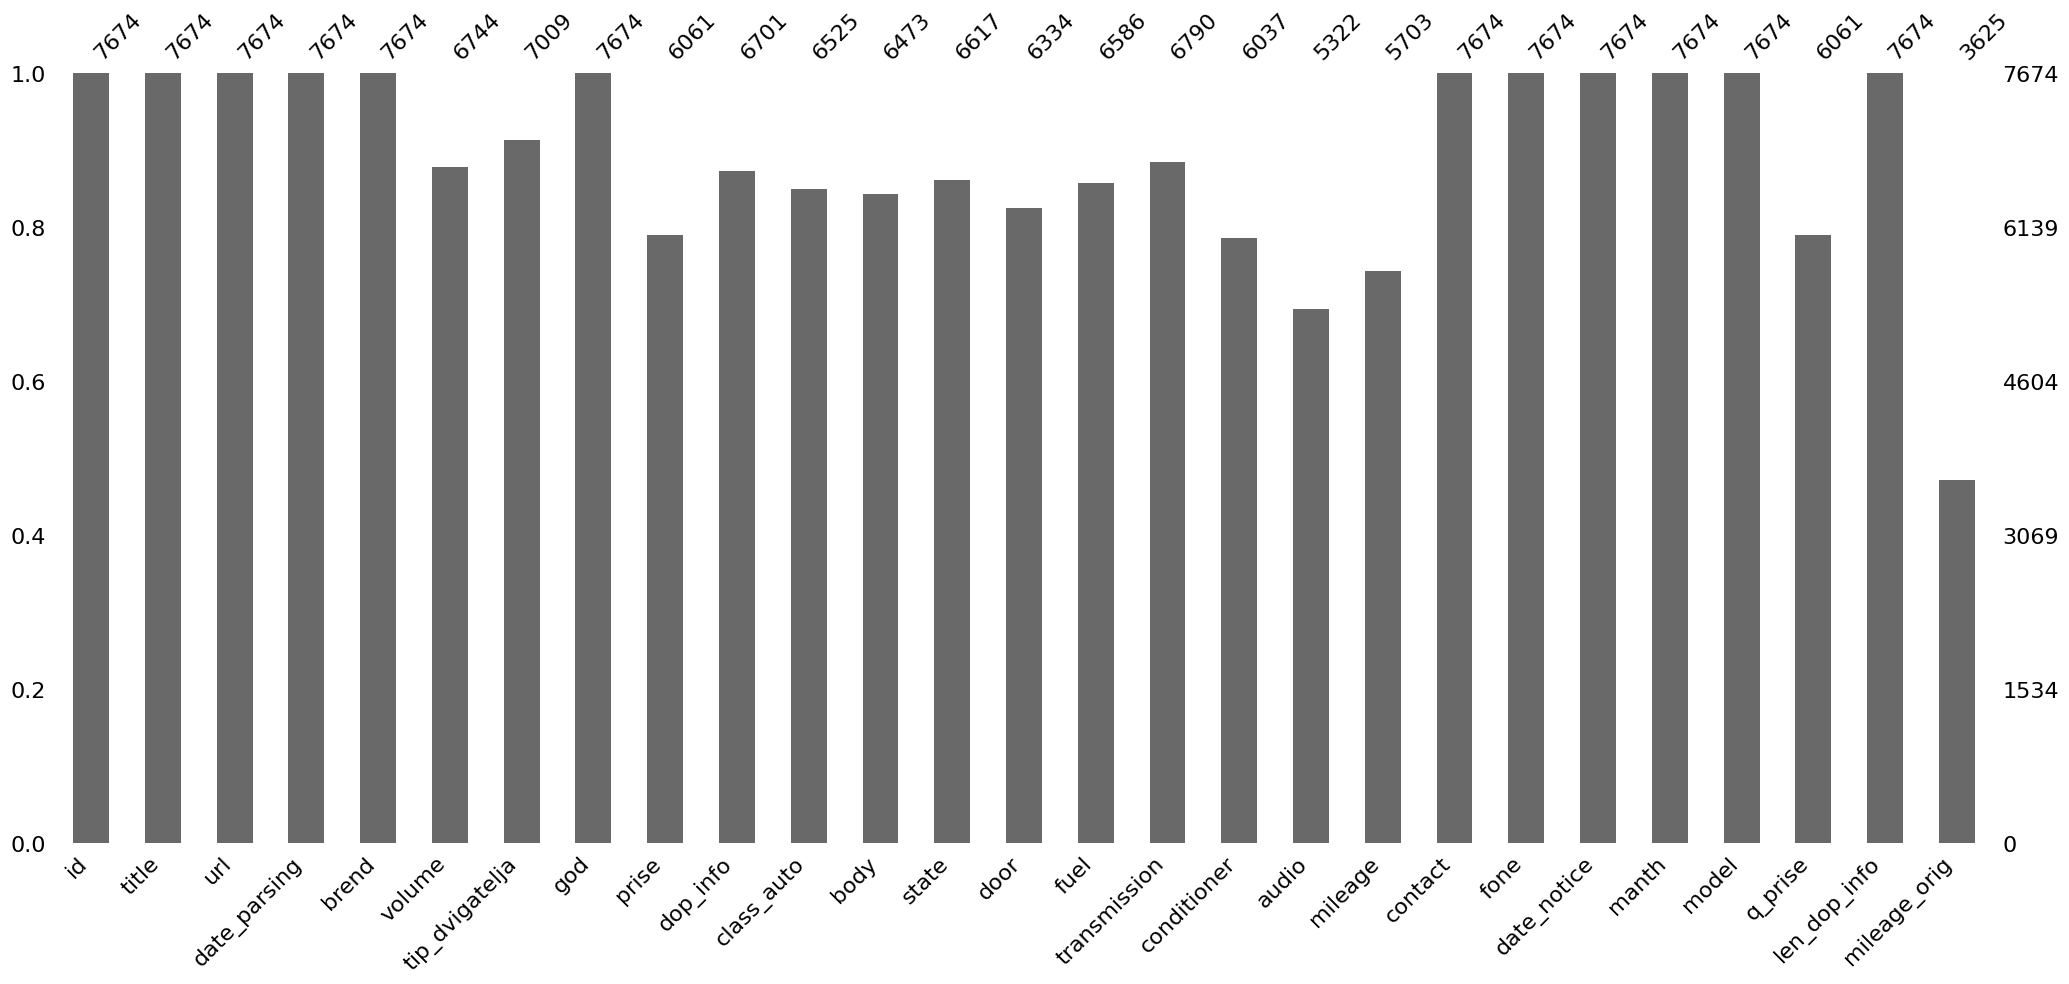

In [107]:
msno.bar(df)

<Axes: >

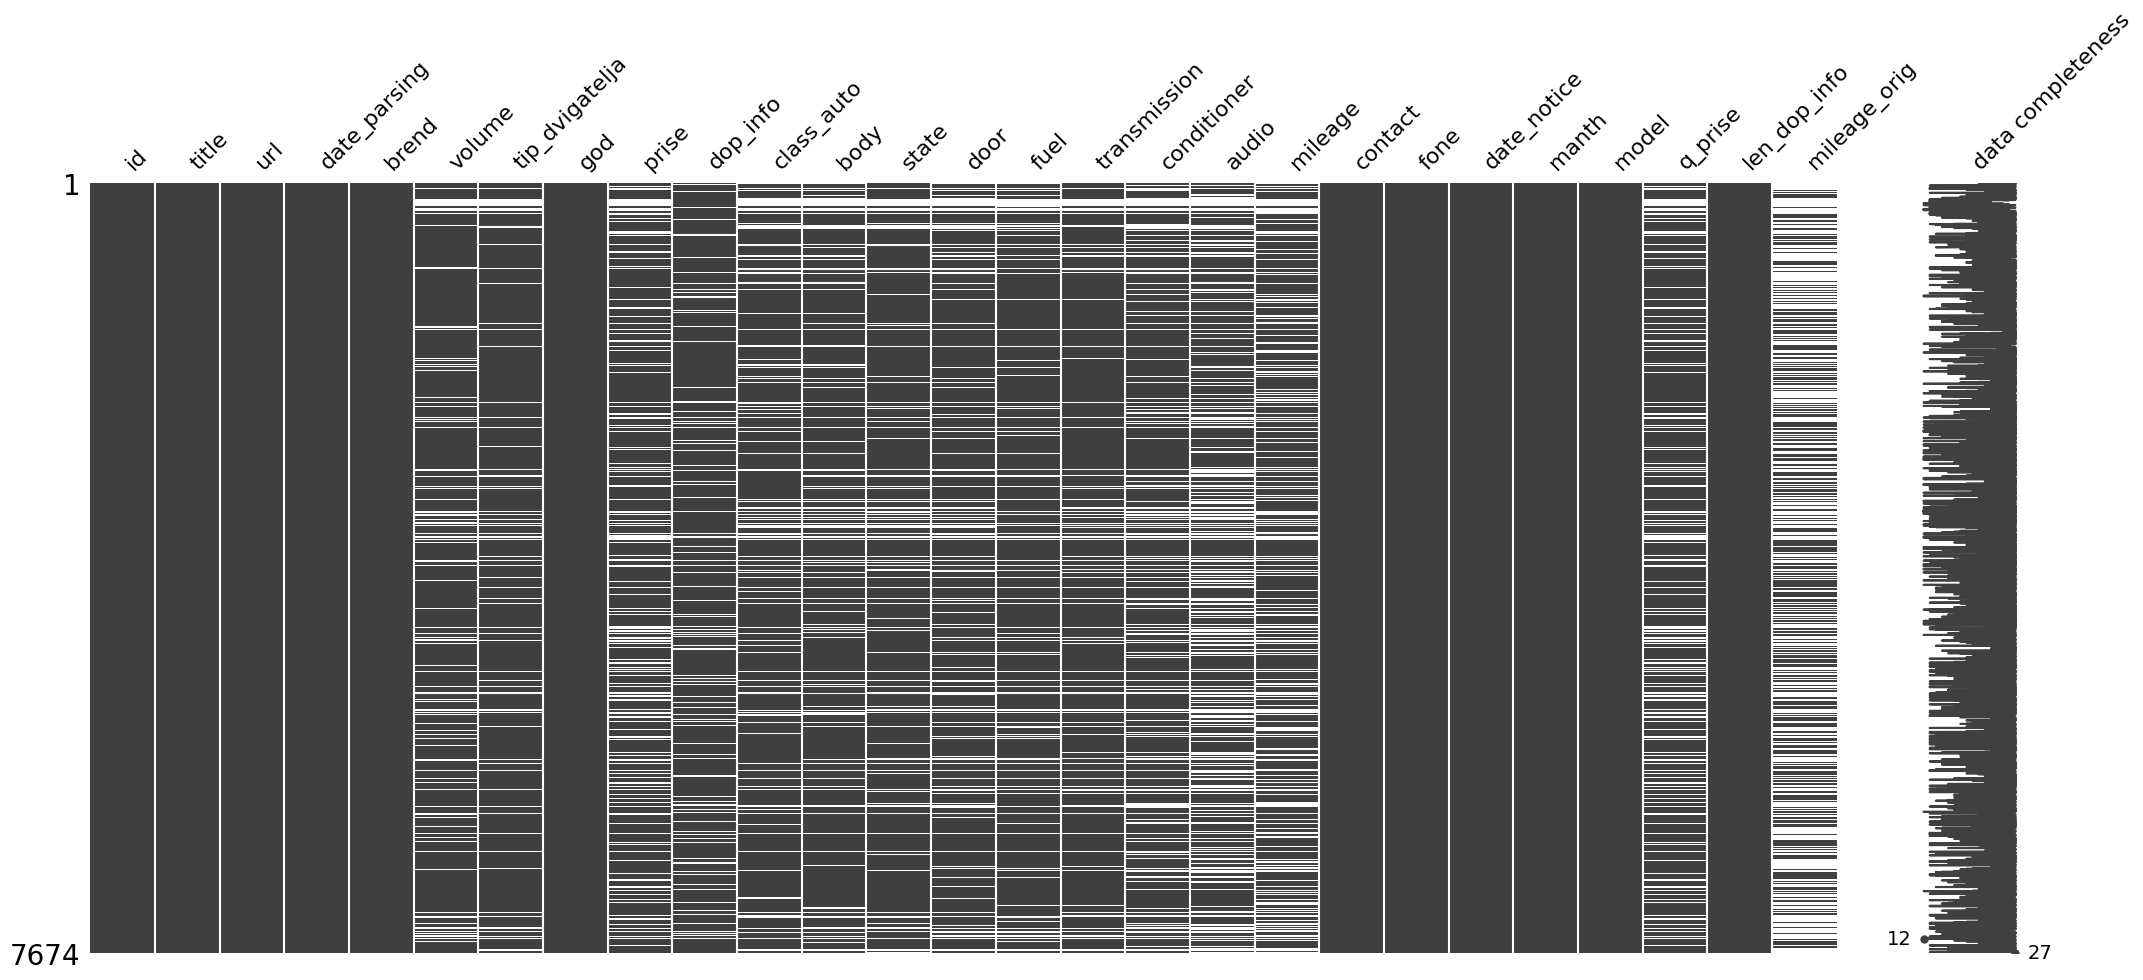

In [108]:
msno.matrix(df, labels=True)

Создаем списки с фичами, таргетом, списки с удаляемыми фичами

In [109]:
df.columns

Index(['id', 'title', 'url', 'date_parsing', 'brend', 'volume',
       'tip_dvigatelja', 'god', 'prise', 'dop_info', 'class_auto', 'body',
       'state', 'door', 'fuel', 'transmission', 'conditioner', 'audio',
       'mileage', 'contact', 'fone', 'date_notice', 'manth', 'model',
       'q_prise', 'len_dop_info', 'mileage_orig'],
      dtype='object')

In [111]:
target = ['prise']
targets = 'prise'
features = ['id', 'brend', 'volume',
       'tip_dvigatelja', 'god', 'body', 'q_prise',
       'state', 'door', 'fuel', 'transmission', 'conditioner', 'audio',
       'mileage', 'contact', 'fone', 'date_notice', 'manth', 'model',
       'len_dop_info', 'mileage_orig']
delete_features = ['id', 'title', 'url', 'date_parsing', 'dop_info', 'class_auto']
categorical_ordinal_features = []
numerical_features = []

In [112]:
for i in features:
    if (df[i].isna().mean()*100) > passs :
        delete_features.append(i)      

In [113]:
features, categorical_features, numerical_features, df = del_features(delete_features, 
                                                                            features, 
                                                                            categorical_ordinal_features, 
                                                                            numerical_features, df)

['id', 'title', 'url', 'date_parsing', 'dop_info', 'class_auto']
OK


In [114]:
df_prediction = df[df['prise'].isna()]

In [115]:
df = df[~(df['prise'].isna())]

In [116]:
(df.isna().mean()* 100).round(2).reset_index().sort_values(by=0, ascending=False)

index     0
20    mileage_orig 48.16
11           audio 25.99
12         mileage 18.89
10     conditioner 16.60
7             door 12.41
5             body 11.14
6            state  8.79
8             fuel  8.56
9     transmission  6.24
1           volume  6.10
2   tip_dvigatelja  3.58
16           manth  0.00
19    len_dop_info  0.00
18         q_prise  0.00
17           model  0.00
4            prise  0.00
15     date_notice  0.00
14            fone  0.00
13         contact  0.00
3              god  0.00
0            brend  0.00

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6061 entries, 0 to 9005
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   brend           6061 non-null   object        
 1   volume          5691 non-null   float64       
 2   tip_dvigatelja  5844 non-null   object        
 3   god             6061 non-null   int64         
 4   prise           6061 non-null   float64       
 5   body            5386 non-null   object        
 6   state           5528 non-null   object        
 7   door            5309 non-null   object        
 8   fuel            5542 non-null   object        
 9   transmission    5683 non-null   object        
 10  conditioner     5055 non-null   object        
 11  audio           4486 non-null   object        
 12  mileage         4916 non-null   float64       
 13  contact         6061 non-null   object        
 14  fone            6061 non-null   object        
 15  date_noti

Оставили данные только о легковых автомобилях с указаной ценой, удалили не нужные признаки. В данных больше всего пропусков в признаке объем двигателя в большей степени это связано с неправильным вводом данной информации, у части данных этот признак получилось исправить. Это сделано для понимания влияния данного признака на цену автомобиля.

# Анализ

In [115]:
#from ydata_profiling import ProfileReport
#profile = ProfileReport(df, title='Аналитический отчет по датасету', 
#                        explorative=True, 
#                        correlations={'auto': {'calculate': False}})
#profile.to_file('dataset_analysis_report.html')

## Разбиение данных

In [171]:
for col in df.columns:
    print(f'{col}: {df[col].nunique()}')

brend: 62
volume: 248
tip_dvigatelja: 5
god: 48
prise: 606
class_auto: 2
body: 14
state: 6
door: 3
fuel: 4
transmission: 6
conditioner: 3
audio: 4
mileage: 706
contact: 1208
fone: 4011
date_notice: 6092
manth: 26
model: 574
len_dop_info: 975
mileage_orig: 693


Уникальные записи помогут нам разделить категориальные и числовые данные. В будущем это будет полезно для пайплайна. Признак `пол` и `одышцианприст` имеет всего 2 уникальных значений, и мы будем использовать это значение как порог для разделения данных на категории.

In [173]:
print('delete_features=[')
for column in df.columns:
    if df[column].dtype != 'object' and len(df[column].dropna().unique())<2:
        print(f"    '{column}',")
print(']\ncategorical_nominal_features = [')
for column in df.columns:
    if df[column].dtype == 'object' or (len(df[column].dropna().unique())>=2 and len(df[column].unique())<=16):
        print(f"    '{column}',")
print(']\ncategorical_ordinal_features = [\n')
print(']\nnumerical_features = [')
for column in df.columns:
    if df[column].dtype != 'object' and len(df[column].dropna().unique())>16:
        print(f"    '{column}',")
print(']')

delete_features=[
]
categorical_nominal_features = [
    'brend',
    'tip_dvigatelja',
    'class_auto',
    'body',
    'state',
    'door',
    'fuel',
    'transmission',
    'conditioner',
    'audio',
    'contact',
    'fone',
    'model',
]
categorical_ordinal_features = [

]
numerical_features = [
    'volume',
    'god',
    'prise',
    'mileage',
    'date_notice',
    'manth',
    'len_dop_info',
    'mileage_orig',
]


In [174]:
delete_features=[
    'date_notice',    

]
categorical_nominal_features = [
    'brend',
    'tip_dvigatelja',
    'class_auto',
    'body',
    'door',
    'fuel',
    'transmission',
    'contact',
    'fone',
    'model',
    'manth',
]
categorical_ordinal_features = [
    'state',
    'conditioner',
    'audio',

]
numerical_features = [
    'volume',
    'god',
    'mileage',
    'len_dop_info',
    'mileage_orig',
]

In [175]:
categorical_nominal_features, categorical_ordinal_features, numerical_features, df = del_features(delete_features, 
                                                                                                  categorical_nominal_features, 
                                                                                                  categorical_ordinal_features, 
                                                                                                  numerical_features, 
                                                                                                  df)

['date_notice']
OK


In [176]:
len(categorical_nominal_features)

11

In [177]:
len(numerical_features)

5

## Таргет

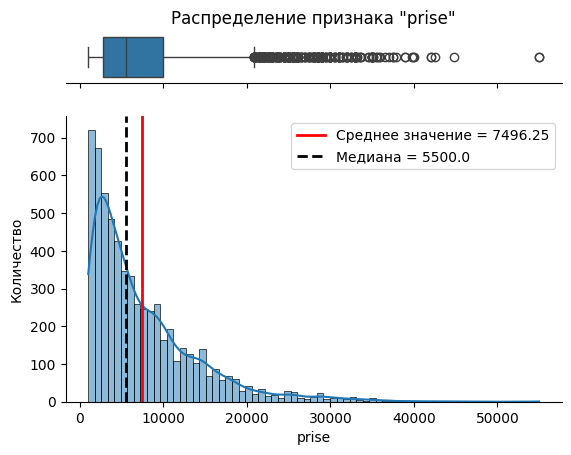

In [179]:
hist_underbox(data=df[targets],title=f'Распределение признака "{targets}"')

In [180]:
df[targets].value_counts(normalize=True)

prise
2000.00    0.02
2500.00    0.02
3500.00    0.02
4500.00    0.02
1500.00    0.02
           ... 
18800.00   0.00
39900.00   0.00
29850.00   0.00
30400.00   0.00
3420.00    0.00
Name: proportion, Length: 606, dtype: float64

Классы в целевой переменной распределены не нормально и имеют выбросы

## Категориальные признаки

In [183]:
categorical_nominal_features

['brend',
 'tip_dvigatelja',
 'class_auto',
 'body',
 'door',
 'fuel',
 'transmission',
 'contact',
 'fone',
 'model',
 'manth']

------------------------------------------------------------------------------------------------------------------------------------------------------
Зависимость признака BREND от таргета: 0.22
                  mean   median  count
brend                                 
Audi           6018.95  3300.00    301
BMW            8127.56  5500.00    433
Ford           7353.31  7500.00    336
Honda          7524.48  6150.00    194
Lexus         14604.69 14000.00    499
Mercedes-Benz  6765.26  4750.00    655
Nissan         5336.54  3199.50    220
Opel           3031.86  2800.00    248
Toyota         9175.23  7600.00    915
Volkswagen     5011.85  4180.00    861
другие         7066.34  4500.00   1557


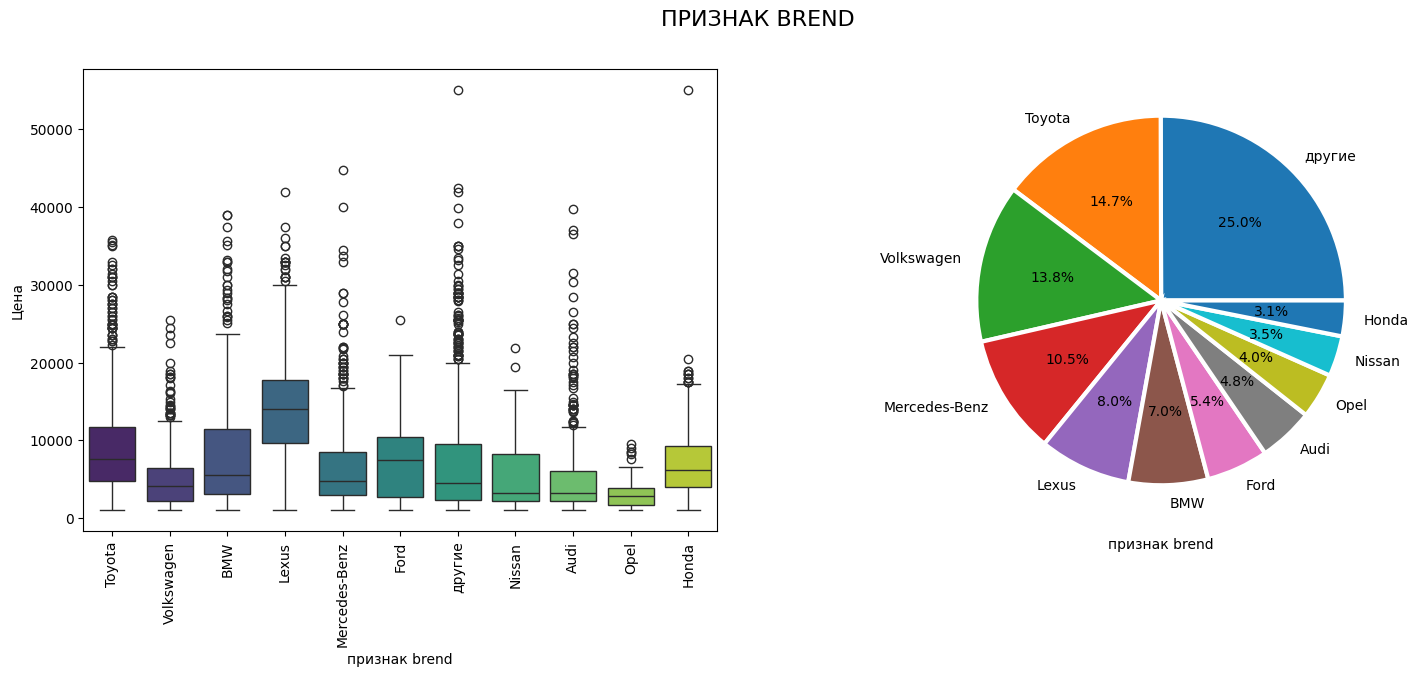

------------------------------------------------------------------------------------------------------------------------------------------------------
Зависимость признака TIP_DVIGATELJA от таргета: 0.22
                   mean   median  count
tip_dvigatelja                         
NoInfo          6800.54  4940.00    221
Бензин          7184.91  3800.00   1436
Бензин-Газ      5359.38  3800.00   1251
Гибрид         13201.71 11725.00    946
Дизель          6098.24  4700.00   2243
Электро        15794.69 14717.00    122


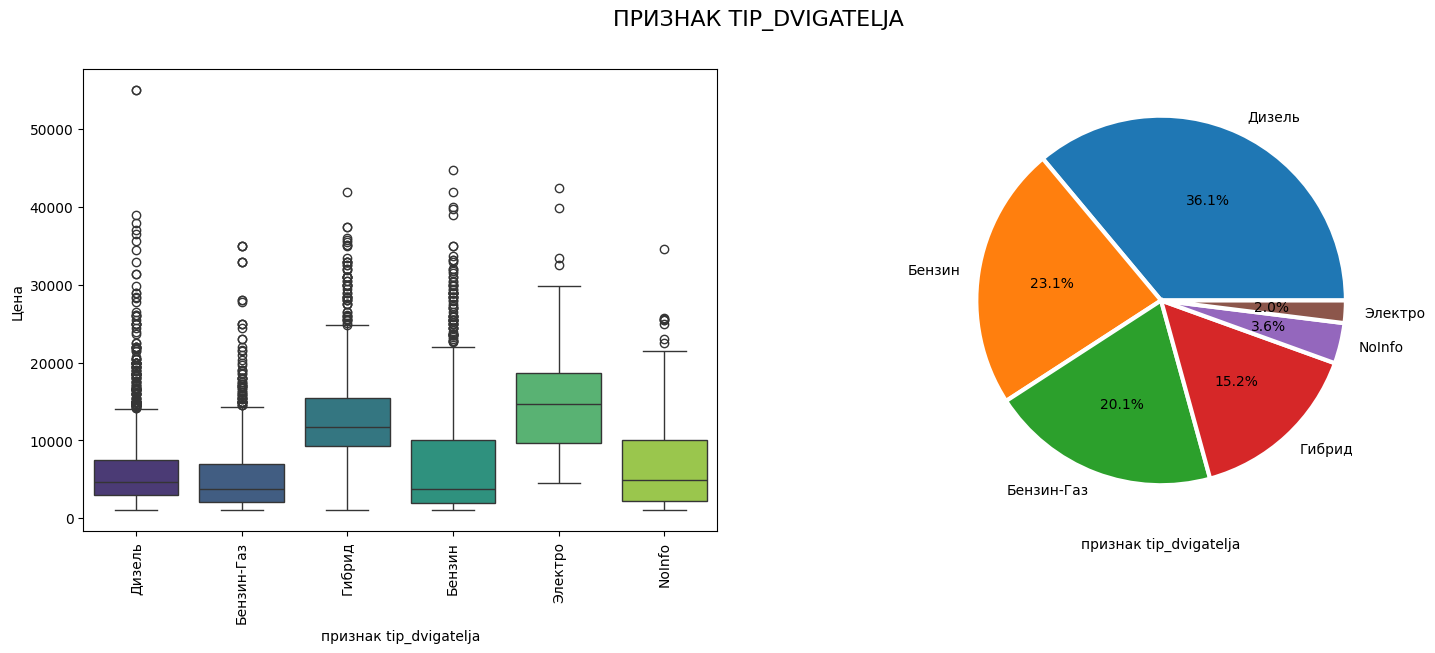

------------------------------------------------------------------------------------------------------------------------------------------------------
Зависимость признака CLASS_AUTO от таргета: 0.02
              mean  median  count
class_auto                       
NoInfo     7204.63 5200.00    639
Грузовой   7904.90 7702.50    158
Легковой   7518.71 5400.00   5422


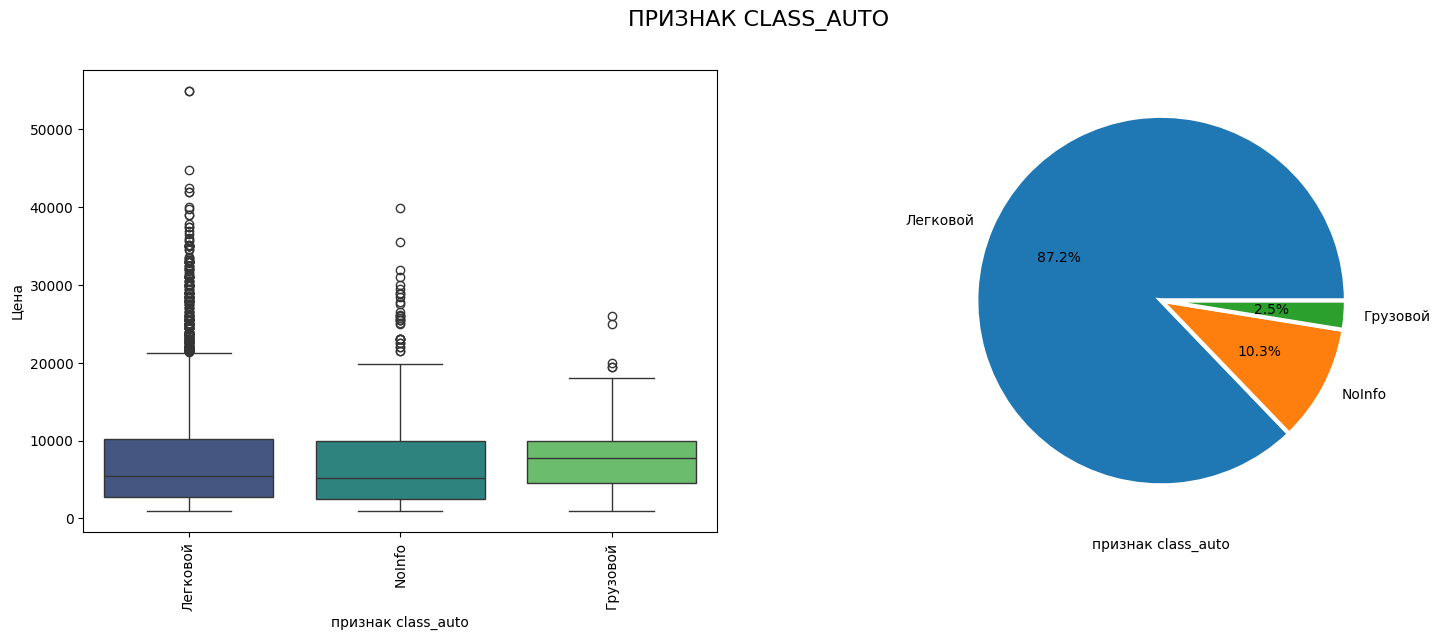

------------------------------------------------------------------------------------------------------------------------------------------------------
Зависимость признака BODY от таргета: 0.19
                 mean   median  count
body                                 
NoInfo        7502.22  5500.00    687
внедорожник  12878.92 10700.00    706
грузовой      7374.54  7200.00     96
другие        7235.10  5500.00    111
кроссовер    13915.12 12300.00    449
купе          5558.57  2950.00     56
микроавтобус  7101.79  6500.00     85
минивен       5115.96  4499.00    611
седан         7026.62  4999.00   1831
универсал     4351.46  3500.00    925
хетчбек       5562.00  4175.00    662


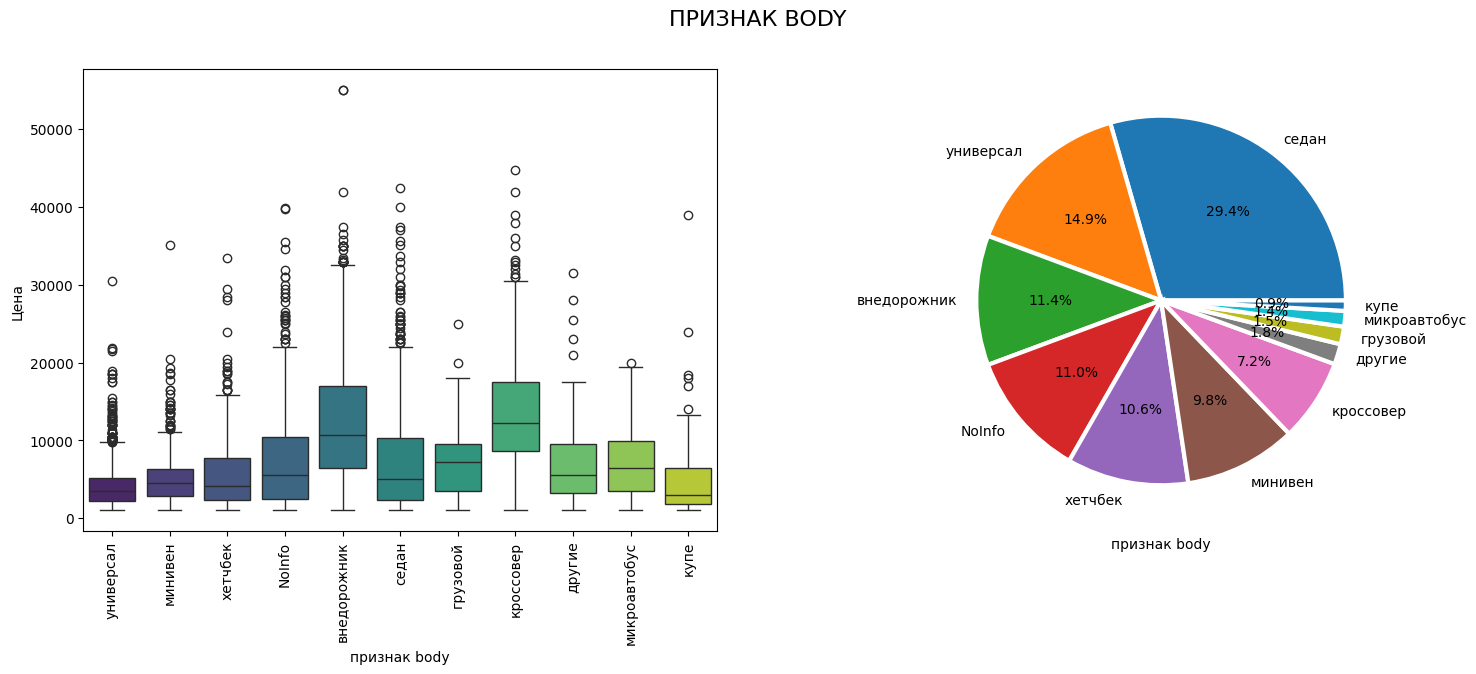

------------------------------------------------------------------------------------------------------------------------------------------------------
Зависимость признака DOOR от таргета: 0.01
          mean  median  count
door                         
2/3    5331.17 3625.00    206
4/5    7633.44 5500.00   5195
6/7    9791.90 6000.00     31
NoInfo 7066.95 5000.00    787


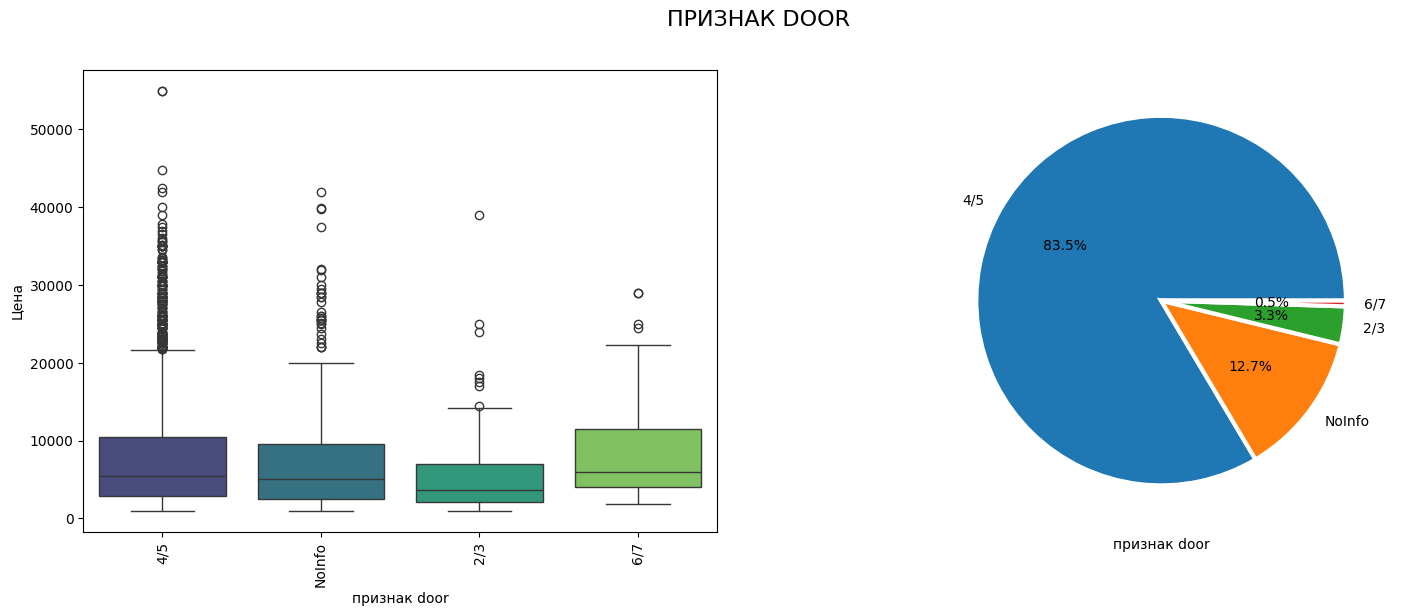

------------------------------------------------------------------------------------------------------------------------------------------------------
Зависимость признака FUEL от таргета: 0.12
            mean   median  count
fuel                            
NoInfo   7142.77  4970.00    528
бензин   8868.25  7500.00   2479
газ      5451.07  4200.00    822
дизель   6125.37  4700.00   2192
электро 14928.26 14350.00    198


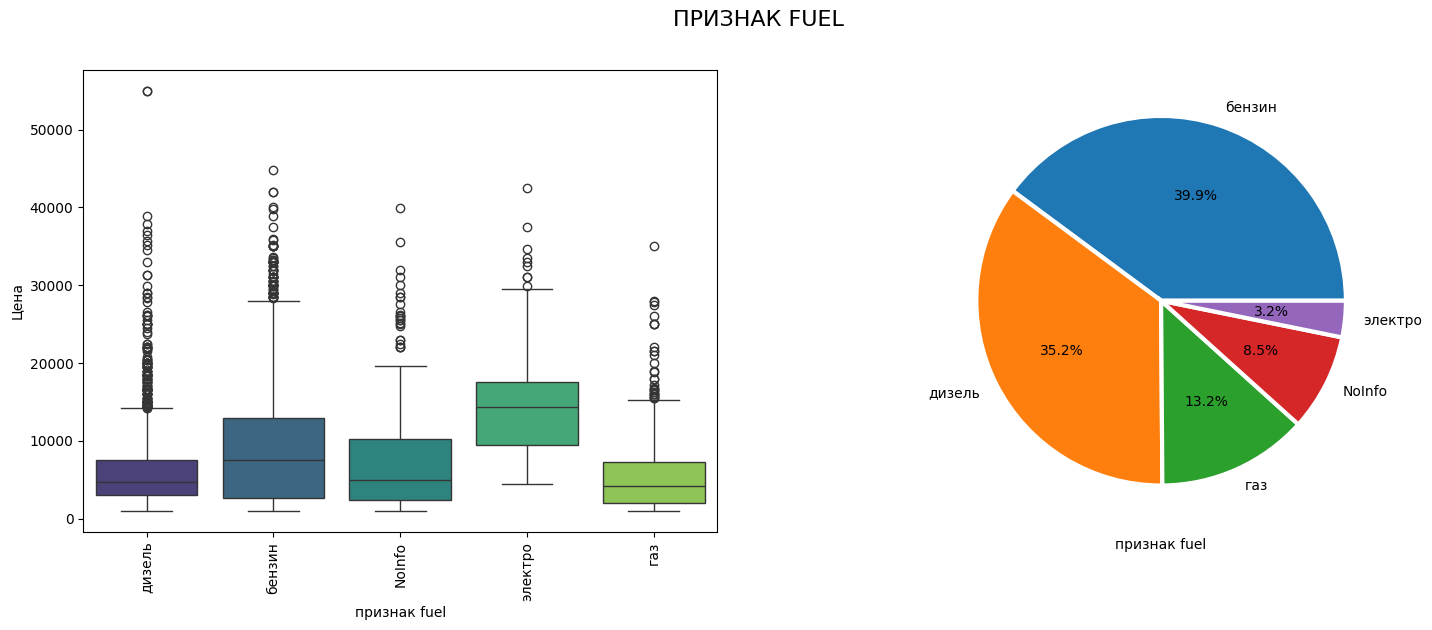

------------------------------------------------------------------------------------------------------------------------------------------------------
Зависимость признака TRANSMISSION от таргета: 0.31
                    mean  median  count
transmission                           
4-ёхступ.мех.    2797.20 1775.00     50
5-тиступ.мех.    3194.51 2600.00   2064
6-тиступ.мех.    5885.74 5150.00    784
NoInfo           6599.27 4100.00    392
автомат         11202.14 9700.00   2876
полуавтомат      6405.00 3800.00     10
роботизированая  9373.98 7900.00     43


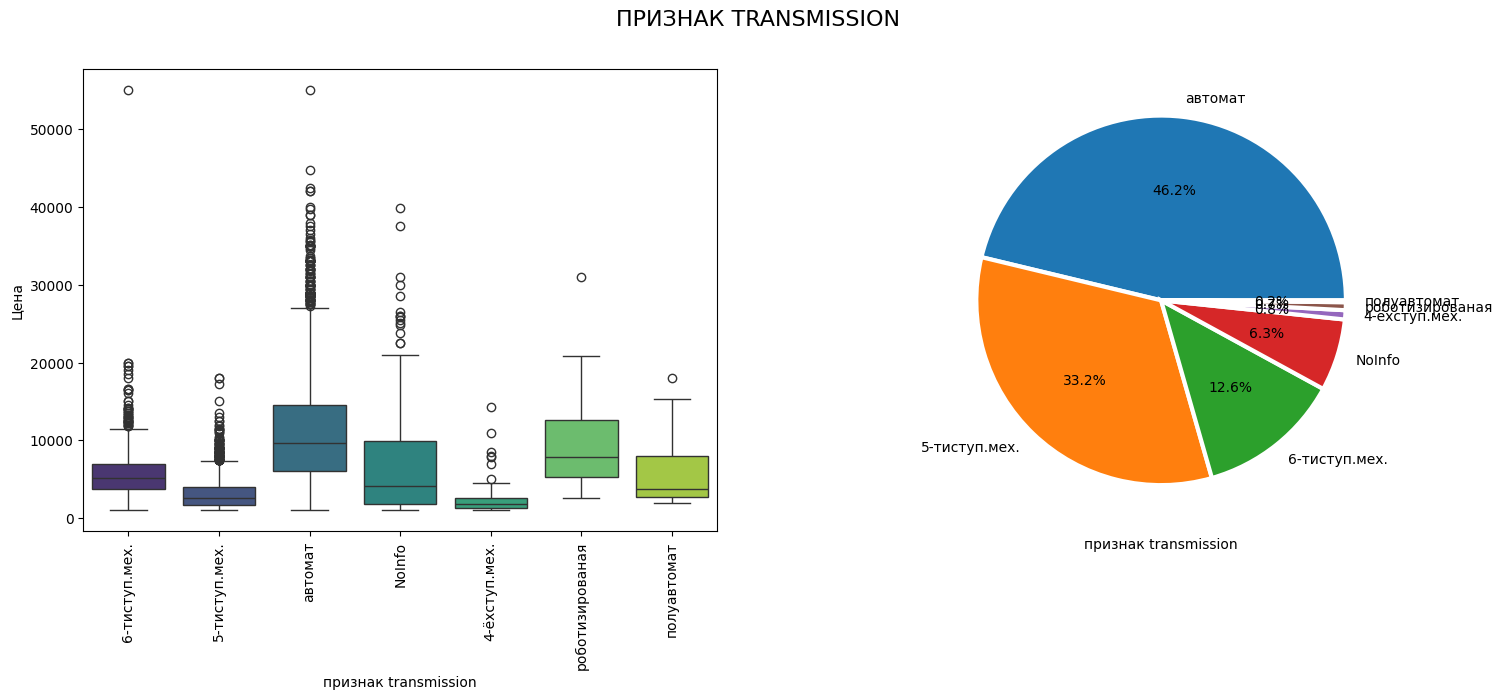

------------------------------------------------------------------------------------------------------------------------------------------------------
Зависимость признака CONTACT от таргета: 0.05
              mean   median  count
contact                           
USAuto    12579.60 11700.00    219
usauto    10971.51  9900.00    195
Александр  6263.00  4600.00    345
Андрей     6981.65  4750.00    182
Владимир   6333.23  4500.00    116
Дмитрий    6291.70  4650.00    178
Евгений    6416.46  4750.00    122
Игорь     11337.13 10000.00    171
Олег       7247.69  5949.50    176
Сергей     7346.14  5500.00    306
другие     7173.64  5000.00   4209


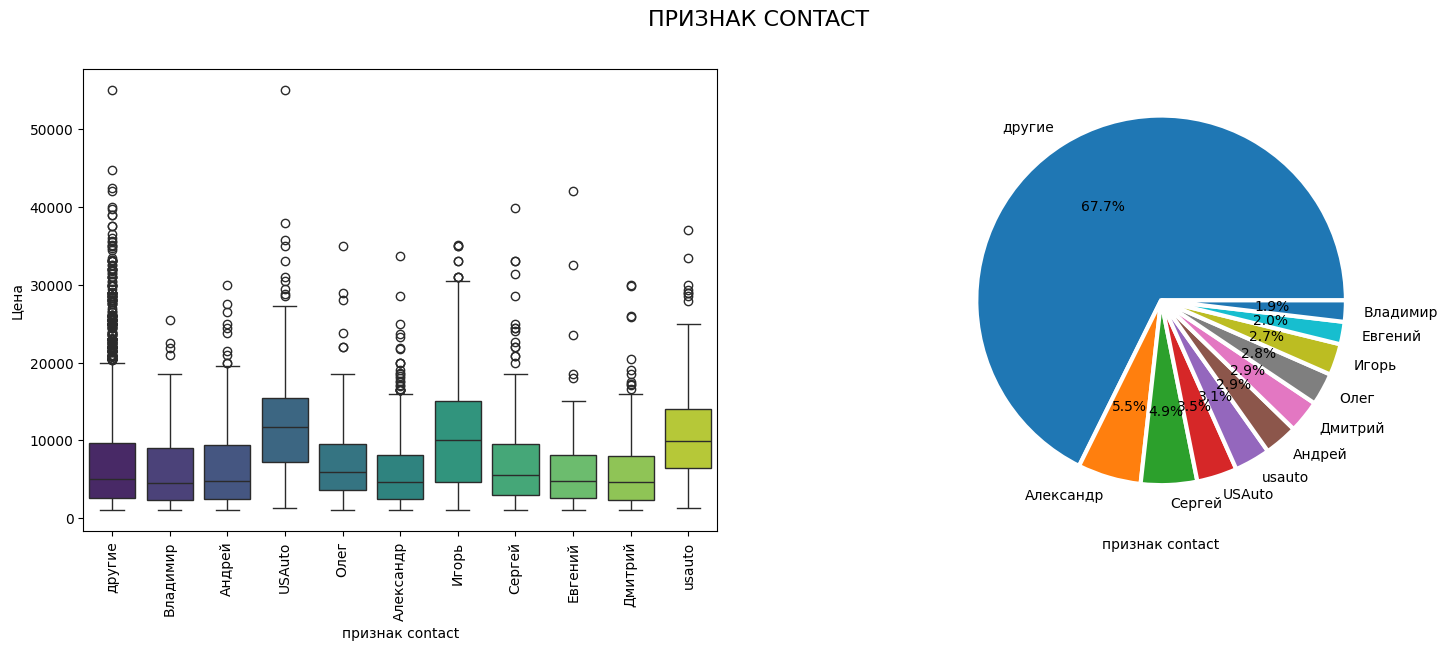

------------------------------------------------------------------------------------------------------------------------------------------------------
Зависимость признака FONE от таргета: 0.09
             mean   median  count
fone                             
77507809  1259.62  1200.00     26
77511713  8951.20  9400.00     20
77727210  9450.00  7500.00     16
77739797 12475.06 11500.00    505
77751105 15907.33 15900.00     15
77751188  6103.92  4590.00     37
77766577  6652.69  6099.50     54
77766745  7577.14  6250.00     21
77873962 10562.50 10500.00     24
77902820  7513.86  7700.00     22
другие    7036.81  5000.00   5479


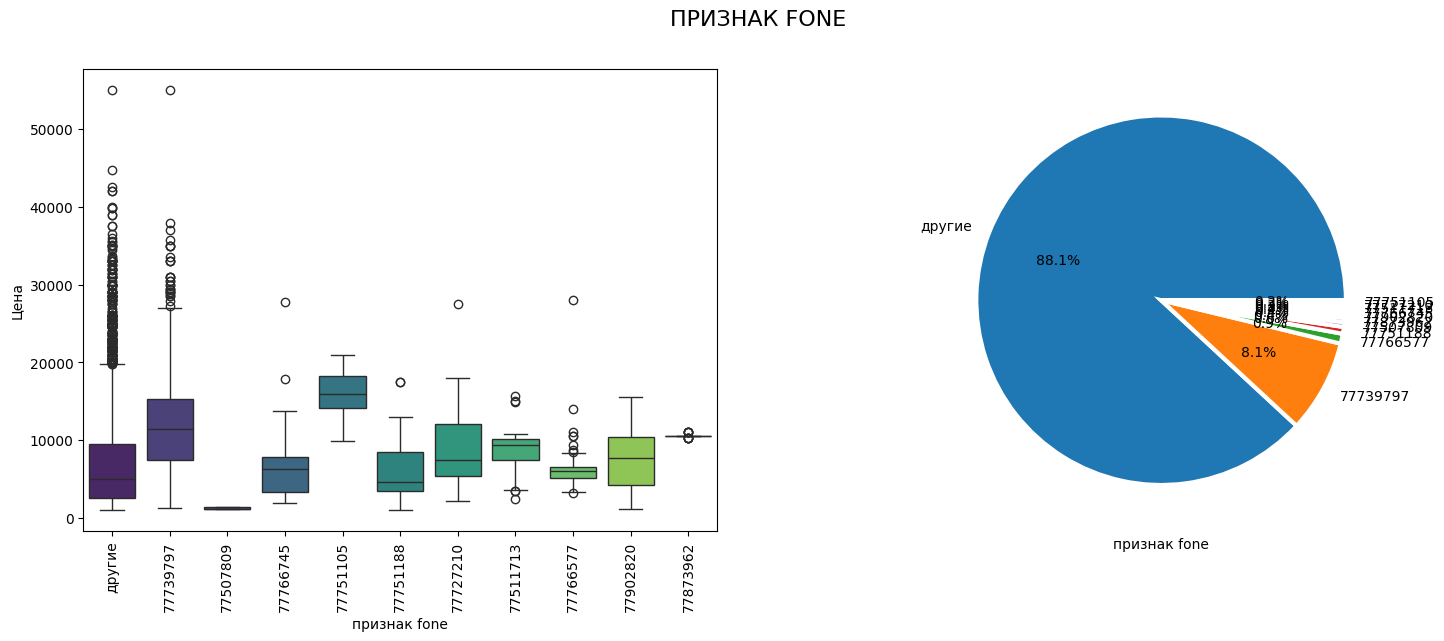

------------------------------------------------------------------------------------------------------------------------------------------------------
Зависимость признака MODEL от таргета: 0.21
            mean   median  count
model                           
A6       5906.50  3500.00    122
Avensis  4894.41  4545.00    174
Camry    9467.23  9974.50    170
Fusion  11697.17 11700.00    111
Golf     3942.34  3500.00    149
Passat   3752.06  2600.00    335
Prius    7305.96  6600.00    119
RX 400h 10068.45  9900.00    111
RX 450h 17924.17 17100.00    155
X5      11072.28  8825.00    110
другие   7358.26  5000.00   4663


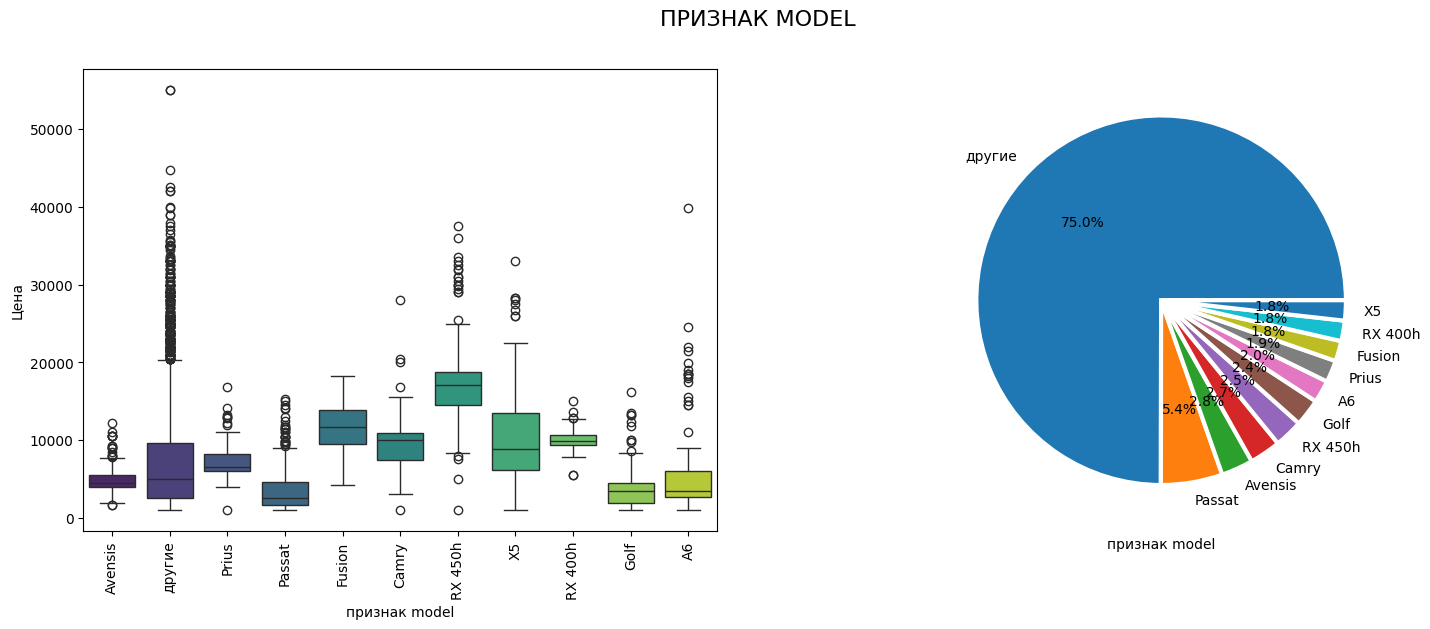

------------------------------------------------------------------------------------------------------------------------------------------------------
Зависимость признака MANTH от таргета: 0.04
           mean  median  count
manth                         
2024-03 7221.46 4800.00    195
2024-04 8218.65 5700.00    198
2024-06 8536.53 6400.00    222
2024-07 9490.35 8000.00    263
2024-08 7964.65 5800.00    255
2024-09 8476.99 6000.00    286
2024-10 8389.40 6550.00    344
2024-11 8218.55 6000.00    447
2024-12 8491.66 6900.00    647
2025-01 8082.31 6400.00   1186
другие  6019.23 4190.00   2176


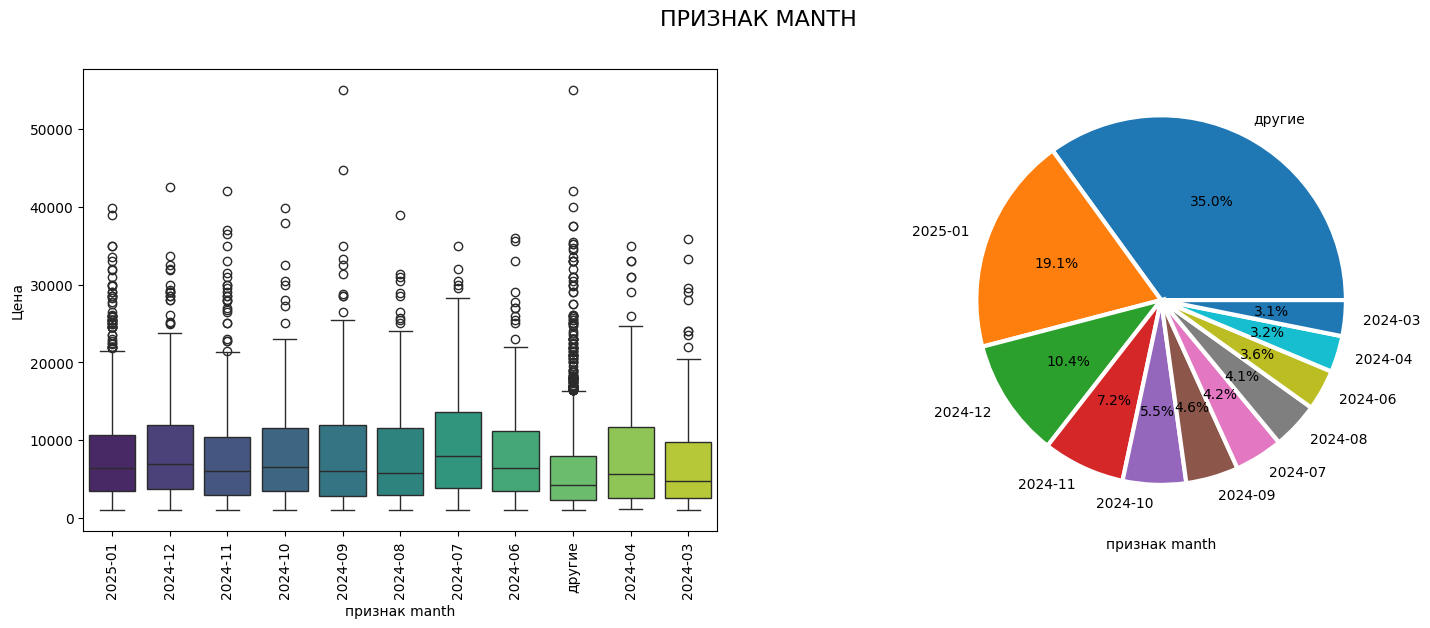

In [184]:
show_categorical_feature_by_list(df, categorical_nominal_features, targets, 10)

In [185]:
for i in categorical_nominal_features:
    print(df[i].value_counts(dropna=False))
    print('-'*100)

brend
Toyota           915
Volkswagen       861
Mercedes-Benz    655
Lexus            499
BMW              433
Ford             336
Audi             301
Opel             248
Nissan           220
Honda            194
Mazda            182
Mitsubishi       173
Hyundai          148
Renault          105
Chevrolet        102
Volvo             74
Kia               69
Skoda             59
Infiniti          52
ВАЗ               50
Chrysler          49
Tesla             48
Peugeot           47
SEAT              43
ГАЗ               35
Lincoln           34
Citroen           34
Jeep              32
Fiat              23
Dacia             21
Land              18
Dodge             16
Suzuki            16
Porsche           13
Subaru            13
Alfa              11
Acura             10
Rover             10
SsangYong          8
Smart              7
Iveko              6
Daihatsu           5
Mini               5
Saab               4
УАЗ                4
Kawasaki           3
Jawa               3
Jaguar 

Бинарные признаки несбалансированы

------------------------------------------------------------------------------------------------------------------------------------------------------
Зависимость признака STATE от таргета: 0.18
                       mean   median  count
state                                      
NoInfo              6553.98  4400.00    541
Битыйавто           1978.89  1200.00      9
Новый              12608.69 11000.00     62
Отличное            9927.69  8500.00   3331
Плохое              2000.00  2000.00      1
Удовлетворительное  2091.48  1550.00    150
Хорошее             4183.09  3200.00   2125


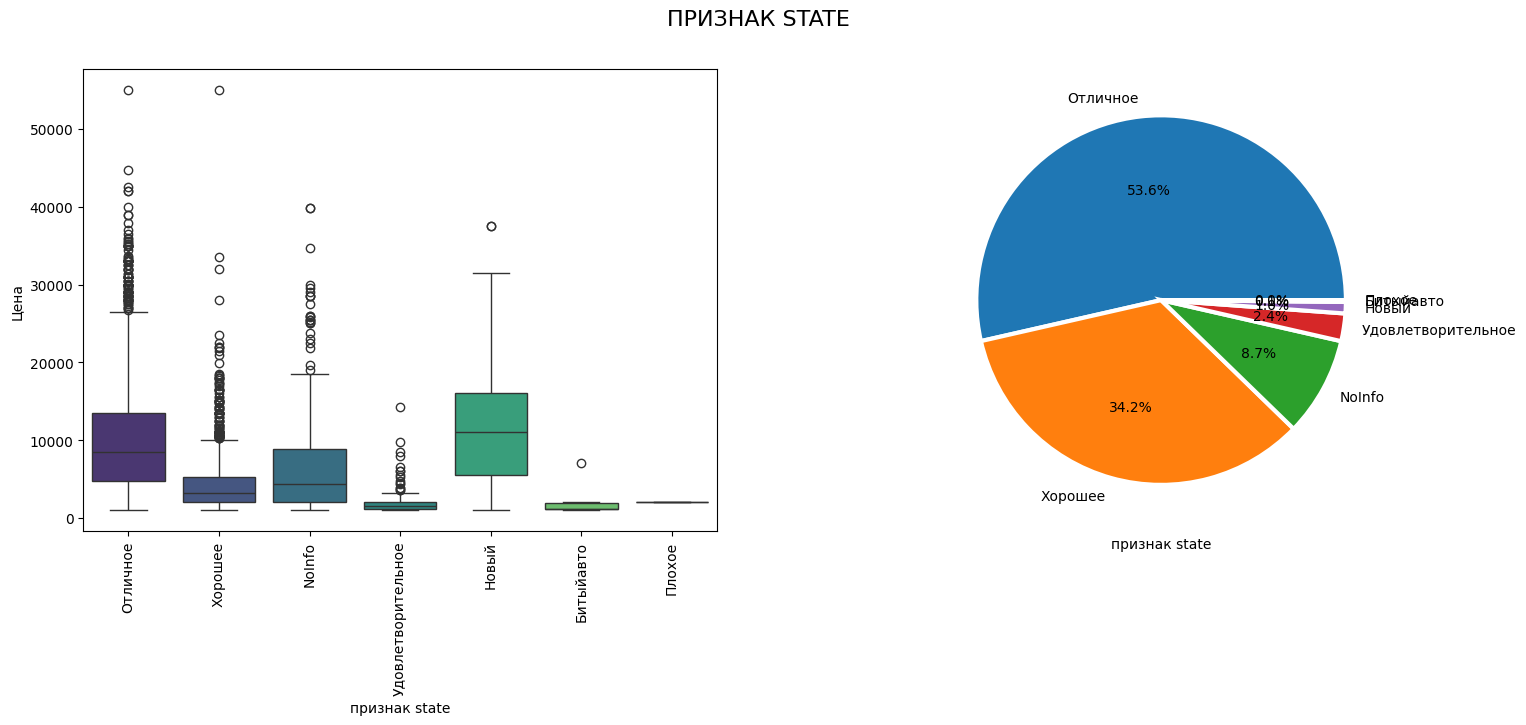

------------------------------------------------------------------------------------------------------------------------------------------------------
Зависимость признака CONDITIONER от таргета: 0.2
                    mean  median  count
conditioner                            
NoInfo           5248.21 3050.00   1058
безкондиционера  2742.77 1700.00    403
климатконтроль  10000.41 8500.00   3241
кондиционер      4976.85 3800.00   1517


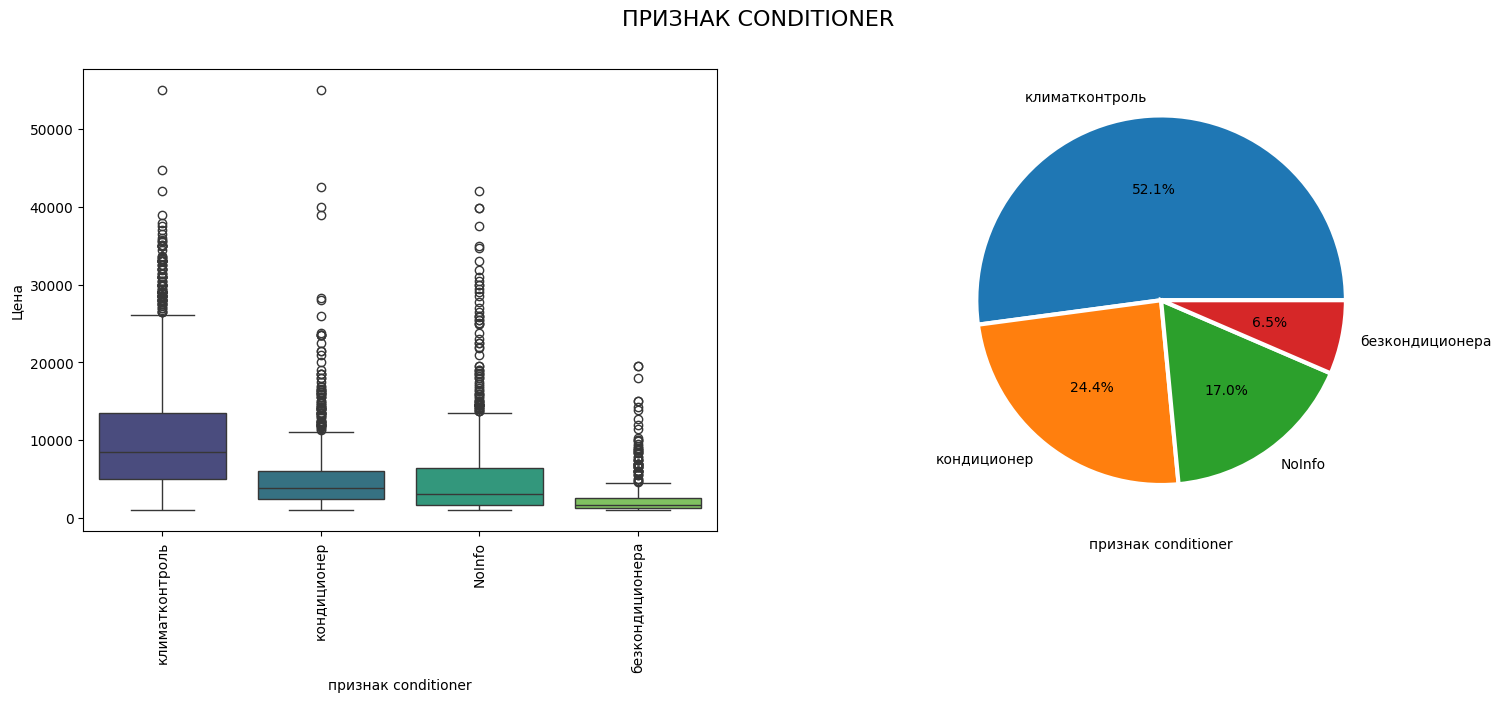

------------------------------------------------------------------------------------------------------------------------------------------------------
Зависимость признака AUDIO от таргета: 0.12
                                        mean   median  count
audio                                                       
NoInfo                               6505.89  4250.00   1642
автомагнитола                        4427.59  3050.00   1049
автомагнитолаCD/MP3(безUSB)          5346.61  4800.00    833
автомагнитолаCD/MP3(сUSBиBluetooth)  9528.19  8500.00   2369
автомагнитолаHi-End                 13085.68 11999.50    326


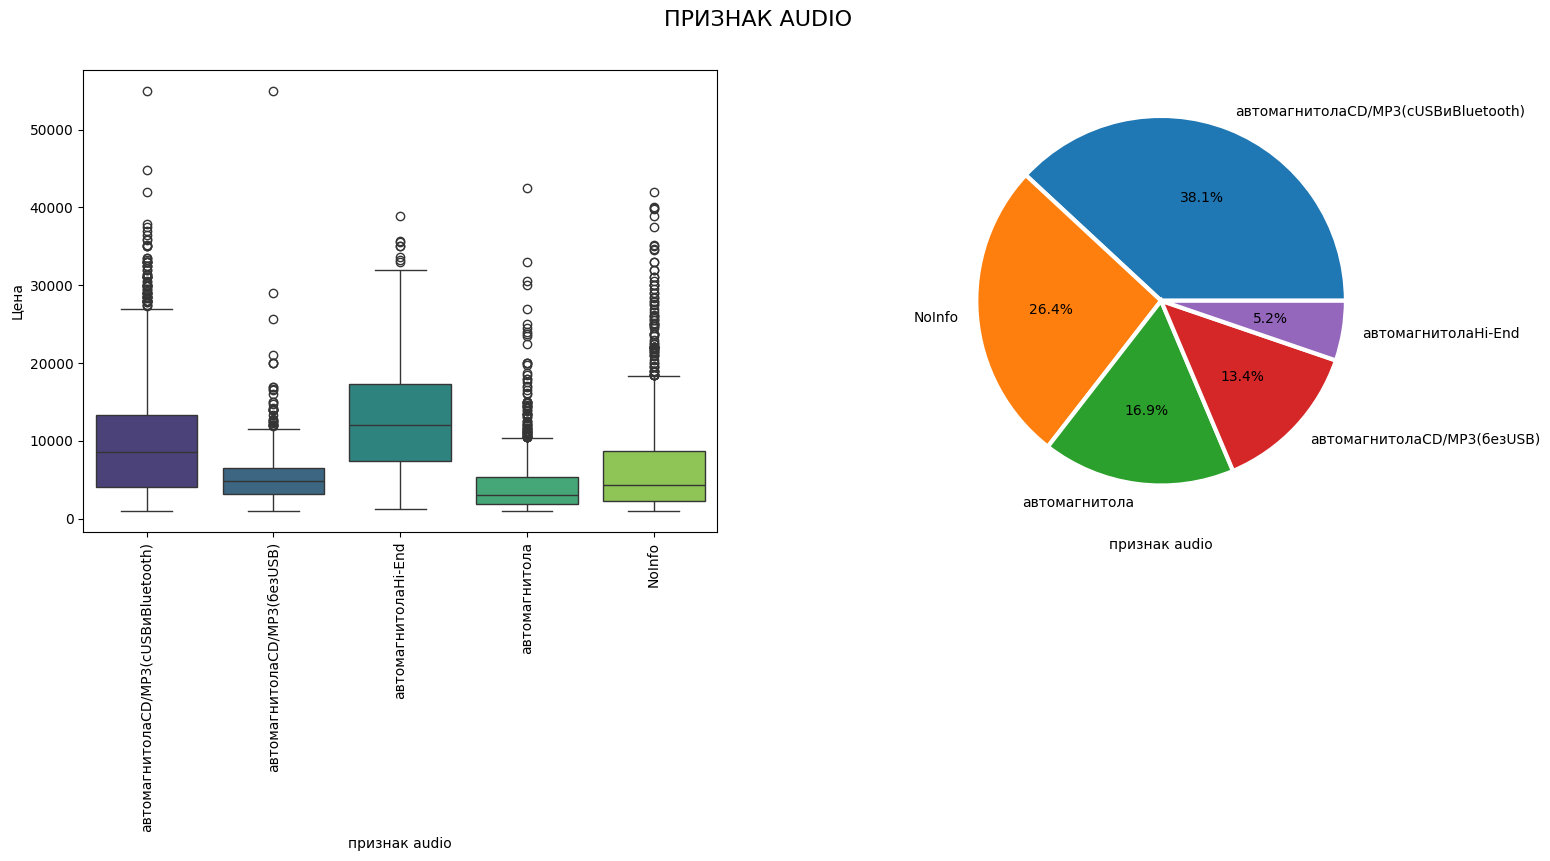

In [187]:
show_categorical_feature_by_list(df, categorical_ordinal_features, targets, 10)

In [188]:
for i in categorical_ordinal_features:
    print(df[i].value_counts(dropna=False))
    print('-'*100)

state
Отличное              3331
Хорошее               2125
NaN                    541
Удовлетворительное     150
Новый                   62
Битыйавто                9
Плохое                   1
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
conditioner
климатконтроль     3241
кондиционер        1517
NaN                1058
безкондиционера     403
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
audio
автомагнитолаCD/MP3(сUSBиBluetooth)    2369
NaN                                    1642
автомагнитола                          1049
автомагнитолаCD/MP3(безUSB)             833
автомагнитолаHi-End                     326
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------


Порядковых категориальных признаков нет

## Числовые признаки

In [191]:
numerical_features

['volume', 'god', 'mileage', 'len_dop_info', 'mileage_orig']

In [192]:
df[numerical_features].head()

volume   god   mileage  len_dop_info  mileage_orig
0 2000.00  2009 212000.00           334     212000.00
1 2000.00  2007 190000.00             3           NaN
2 1800.00  2009 157000.00             3     157000.00
3 2000.00  1997       NaN            64           NaN
4 4600.00  2012       NaN           354           NaN

<Figure size 640x480 with 0 Axes>

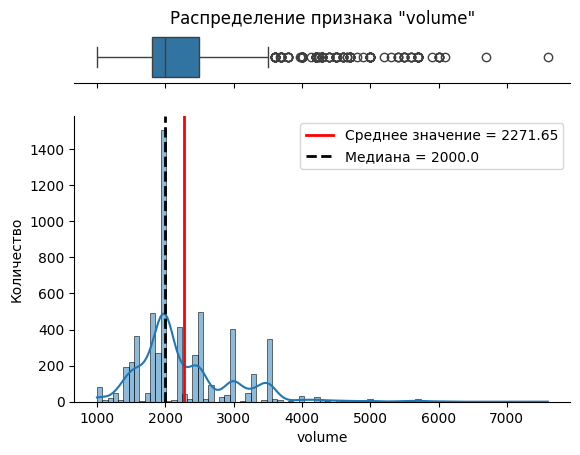

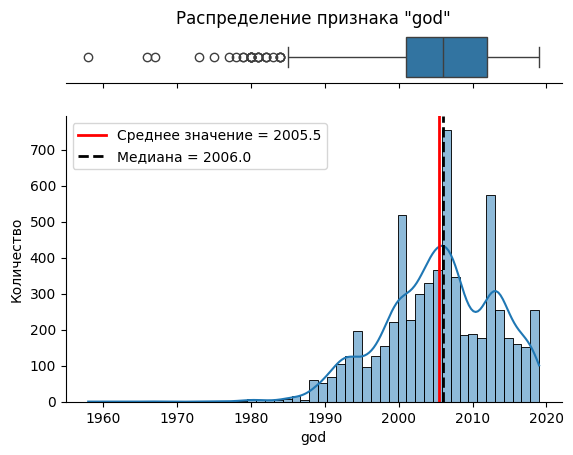

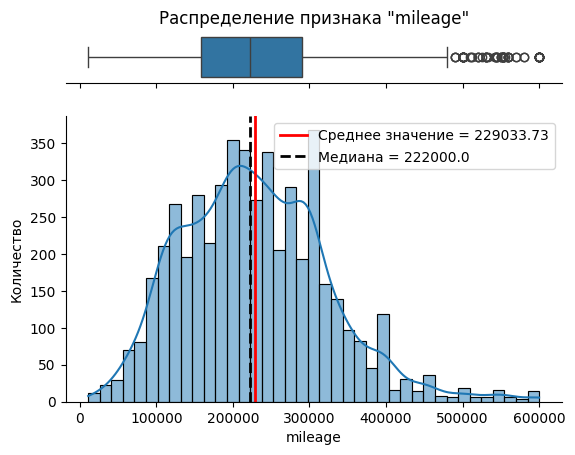

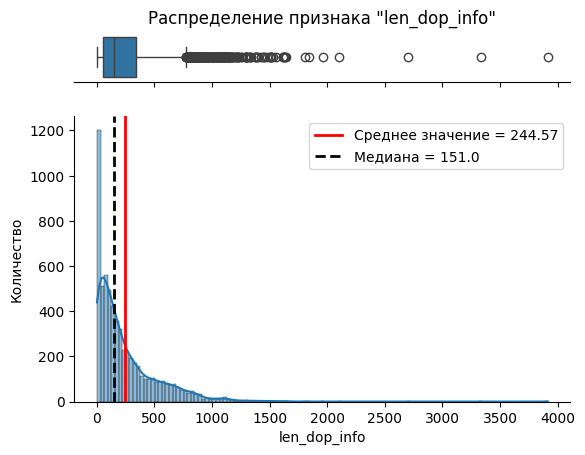

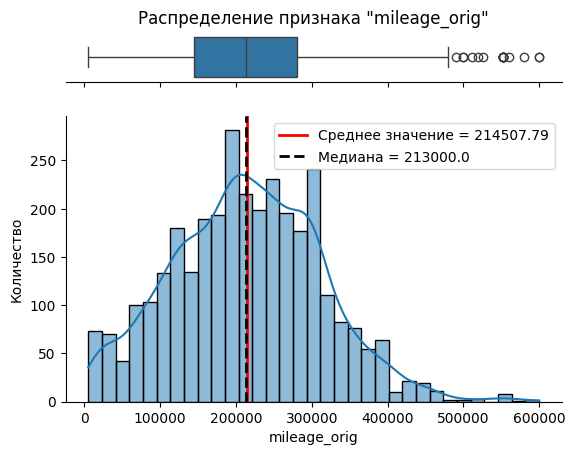

In [193]:
for i in range(len(numerical_features)):
    col = numerical_features[i]
    plt.figure(i)
    hist_underbox(data=df[col],title=f'Распределение признака "{col}"')

**После анализа количественных признаков мы можем сделать следующие выводы:**
* В значениях имеются некоторые выбросы, посмотрим сколько строк с выбрасами

Некоторые количественные данные распределены не нормально

явного деления количественных признаков датасета по таргету не проссматривается.

## Корреляционный анализ

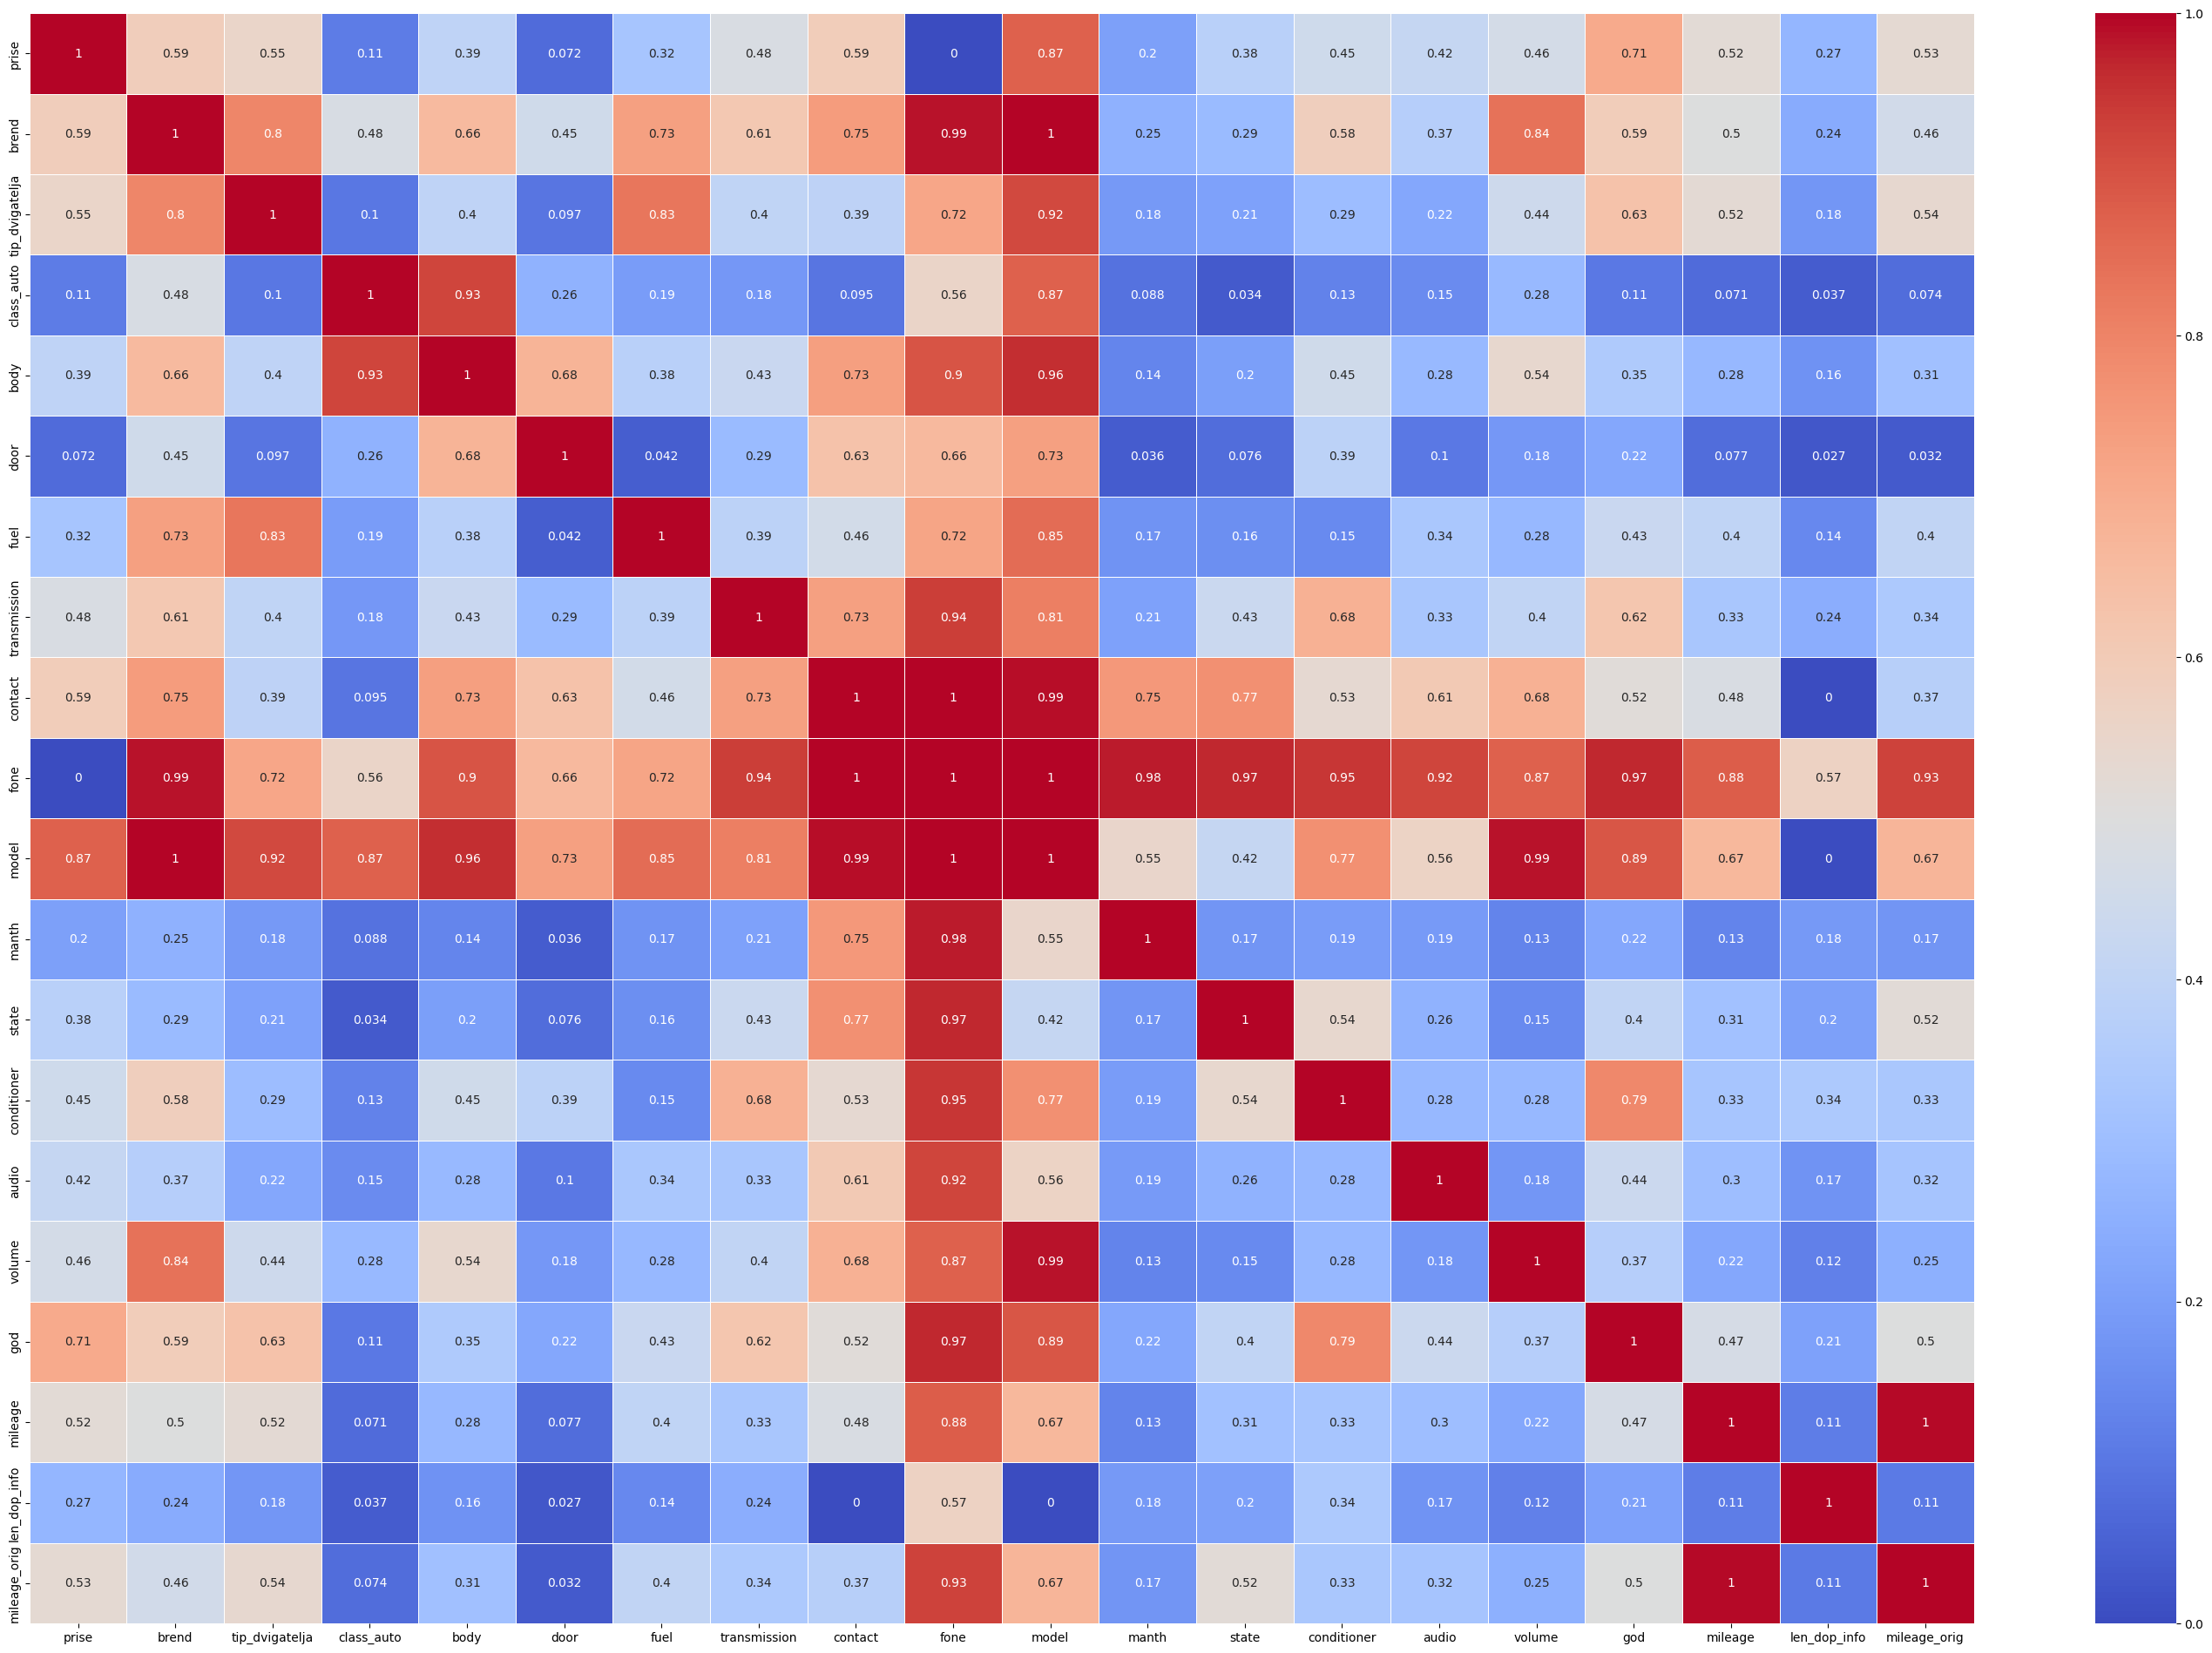

In [198]:
all_features = target + categorical_nominal_features + categorical_ordinal_features + numerical_features
interval_cols = target + numerical_features
cor_matrix = df[all_features].phik_matrix(interval_cols=interval_cols, )
plt.figure(figsize=(36, 24))
sns.heatmap(cor_matrix, 
            annot=True, 
            linewidths=0.5, 
            cmap='coolwarm')
plt.show()

Наиболее сильно влияют на целевой признак следующие признаки:

In [200]:
cor_matrix[target].sort_values(by=target,ascending=False).head(10)

prise
prise            1.00
model            0.87
god              0.71
contact          0.59
brend            0.59
tip_dvigatelja   0.55
mileage_orig     0.53
mileage          0.52
transmission     0.48
volume           0.46

Мультиколлинеарность наблюдается у следующих признаков:

In [202]:
mult_col = []
for column in cor_matrix.columns:
    for i in cor_matrix.columns:
        value = cor_matrix[column][i]
        if column != i and value > multicol :
            if cor_matrix[targets][column] > cor_matrix[targets][i]:
                mult_col.append([column, cor_matrix[targets][column], i, cor_matrix[targets][i], value])
            elif cor_matrix[targets][column] < cor_matrix[targets][i]:
                mult_col.append([i, cor_matrix[targets][i], column, cor_matrix[targets][column], value])
            else:
                if column < i:
                    mult_col.append([column, cor_matrix[targets][column], i, cor_matrix[targets][i], value])
                else:
                    mult_col.append([i, cor_matrix[targets][i], column, cor_matrix[targets][column], value])        

            
t = pd.DataFrame(mult_col, columns=['first', 'f_target_corr', 'second',
                                    's_target_corr', 'f_s_corr']).sort_values('f_target_corr',
                                                                              ascending=False).reset_index(drop=True)
t = t.drop_duplicates()
delete_features = t.second.unique()
t

first  f_target_corr second  s_target_corr  f_s_corr
0    model           0.87  brend           0.59      1.00
1    model           0.87   fone           0.00      1.00
4  contact           0.59   fone           0.00      1.00

In [203]:
delete_features

array(['brend', 'fone'], dtype=object)

categorical_nominal_features, categorical_ordinal_features, numerical_features, no_anomalies_df = del_features(delete_features, 
                                                                                                  categorical_nominal_features, 
                                                                                                  categorical_ordinal_features, 
                                                                                                  numerical_features, 
                                                                                                  df)

Удаляем следующие мултиколениарные признаки 'ксрлж' 'кдолж' 'устьелла' 'ствол_ла' 'рост' 'бса'

Проверим, сколько осталось количественныхи котегориальных признаков

In [207]:
len(categorical_nominal_features)

11

In [208]:
len(categorical_ordinal_features)

3

In [209]:
categorical_features = categorical_nominal_features + categorical_ordinal_features
len(categorical_features)

14

In [210]:
len(numerical_features)

5

В данных осталось 13 количественных признаков и 8 котегориальных

## Промежуточные выводы

* Классы в целевой переменной не сбалансированны и сильно отличаются
* Бинарные признаки не сбалансированны
* Порядковых категориальных признаков нет
* Некоторые количественные данные распределены не нормально
* В значениях имеются некоторые выбросы, удаляем их из данных но сохраняем эти выбросы в отдельном датасете. 

# Обучение моделей

## Деление на выборки

In [216]:
X = df.drop(columns=targets)
x_col = X.columns
y = df[targets]

In [217]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TS,
    random_state=RS,
    )   

In [218]:
X_train['manth'] = X_train['manth'].astype(str)
X_test['manth'] = X_test['manth'].astype(str)

In [219]:
target_encoder = TargetEncoder(smoothing=5)
X_train_target_encoded = target_encoder.fit_transform(X_train[categorical_nominal_features], y_train)
X_test_target_encoded = target_encoder.transform(X_test[categorical_nominal_features])

In [220]:
X_train[categorical_ordinal_features] = X_train[categorical_ordinal_features].fillna('no_info')
X_test[categorical_ordinal_features] = X_test[categorical_ordinal_features].fillna('no_info')

In [221]:
categories = [['Новый', 'Отличное', 'Хорошее', 'Удовлетворительное', 'Плохое', 'Битыйавто', 'no_info'],  # Порядок для 'цвет'
              ['климатконтроль', 'кондиционер', 'безкондиционера', 'no_info'],
              ['автомагнитолаHi-End', 'автомагнитолаCD/MP3(сUSBиBluetooth)', 'автомагнитолаCD/MP3(безUSB)', 'автомагнитола', 'no_info']]

ordinal_encoder = OrdinalEncoder(categories=categories)
X_train_ordinal_encoded = ordinal_encoder.fit_transform(X_train[categorical_ordinal_features])
X_test_ordinal_encoded = ordinal_encoder.transform(X_test[categorical_ordinal_features])

In [222]:
X_train_ordinal_encoded = pd.DataFrame(data=X_train_ordinal_encoded, 
                                      index=X_train.index, 
                                      columns=categorical_ordinal_features)
X_test_ordinal_encoded = pd.DataFrame(data=X_test_ordinal_encoded, 
                                      index=X_test.index, 
                                      columns=categorical_ordinal_features)

In [223]:
X_train = pd.concat([X_train[numerical_features],
                     X_train_target_encoded,
                     X_train_ordinal_encoded],
                    axis=1)
X_test = pd.concat([X_test[numerical_features],
                     X_test_target_encoded,
                     X_test_ordinal_encoded],
                    axis=1)

In [224]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1866 entries, 3054 to 4045
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   volume          1745 non-null   float64
 1   god             1866 non-null   int64  
 2   mileage         1514 non-null   float64
 3   len_dop_info    1866 non-null   int64  
 4   mileage_orig    976 non-null    float64
 5   brend           1866 non-null   float64
 6   tip_dvigatelja  1866 non-null   float64
 7   class_auto      1866 non-null   float64
 8   body            1866 non-null   float64
 9   door            1866 non-null   float64
 10  fuel            1866 non-null   float64
 11  transmission    1866 non-null   float64
 12  contact         1866 non-null   float64
 13  fone            1866 non-null   float64
 14  model           1866 non-null   float64
 15  manth           1866 non-null   float64
 16  state           1866 non-null   float64
 17  conditioner     1866 non-null   flo

In [225]:
try:
    with open("models.pkl", "rb") as f:
        loaded_data = models.load(f)
except:
    models = {}
scor = ['MAE', 'MSE', 'MAPE', 'RMSE']
scorer = [mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score]
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'r2']
columns_results_models_v1=['model', 'cv', 'train', 'test', 'test_MAE', 'training_time', 'prediction_time', 'best_parametrs']

try:
    results_models_v1 = pd.read_csv('results_models_v1.csv')
except:
    results_models_v1 = pd.DataFrame(columns=['model', 'cv', 'train', 'test', 'test_MAE', 'training_time', 'prediction_time', 'best_parametrs'])
    results_models_v1.to_csv('results_models_v1.csv', index=False)
    
    #base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    #public_key = 'https://disk.yandex.ru/d/_DkUx8Y5KO9tcw' 
    # Получаем загрузочную ссылку
    #final_url = base_url + urlencode(dict(public_key=public_key))
    #response_file = requests.get(final_url)
    #download_url = response_file.json()['href'] 
    #results_models_v1 = pd.read_csv(download_url)
    
results_models_v1.head()

Empty DataFrame
Columns: [model, cv, train, test, test_MAE, training_time, prediction_time, best_parametrs]
Index: []

Поделили данные на обучающие и тестовые, выбрали метрики 'MAE', 'MSE', 'MAPE', 'RMSE'

## Построение пайплана

In [228]:
categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy='most_frequent')),
        ("onehot", OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
        #("selection", SelectKBest(score_func=f_classif, k="all")),
    ])
numerical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy='median')),
        ("scaler", StandardScaler()),
        #("selection", SelectKBest(score_func=f_classif, k="all")),
    ])

preprocessor = ColumnTransformer(transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features),        
    ],)

## Построение модели 

#### Случайный лес `RandomForestClassifier`

Модель RandomForestRegressor_0.999MAEstart
----------------------------------------------------------------------
метрика - neg_mean_absolute_error
метрика модели на трейне: 442.04
метрика модели на тесте: 2387.89
MAE модели на тесте: 2387.89
метрика лучшей модели на кроссвалидации: -992.11
----------------------------------------------------------------------
Время обучения: 8466.77 сек.
Время предсказания: 0.09 сек.
Лучшие параметры: {'regressor__n_estimators': 150, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 25, 'regressor__bootstrap': True, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'median'}


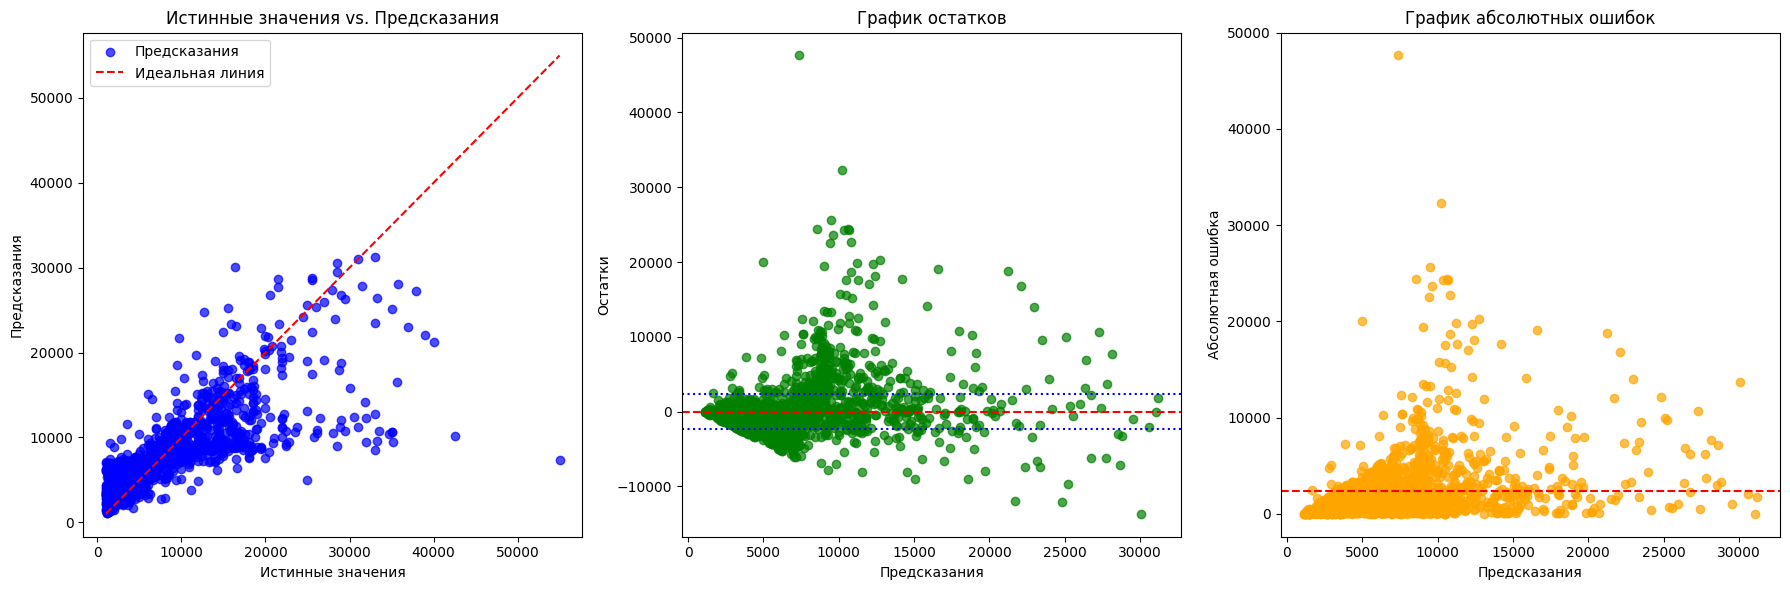

Модель RandomForestRegressor_0.999MSEstart
----------------------------------------------------------------------
метрика - neg_mean_squared_error
метрика модели на трейне: 964914.64
метрика модели на тесте: 16568177.9
MAE модели на тесте: 2384.7
метрика лучшей модели на кроссвалидации: -4248548.89
----------------------------------------------------------------------
Время обучения: 8483.46 сек.
Время предсказания: 0.07 сек.
Лучшие параметры: {'regressor__n_estimators': 125, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 15, 'regressor__bootstrap': True, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'most_frequent', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'most_frequent'}


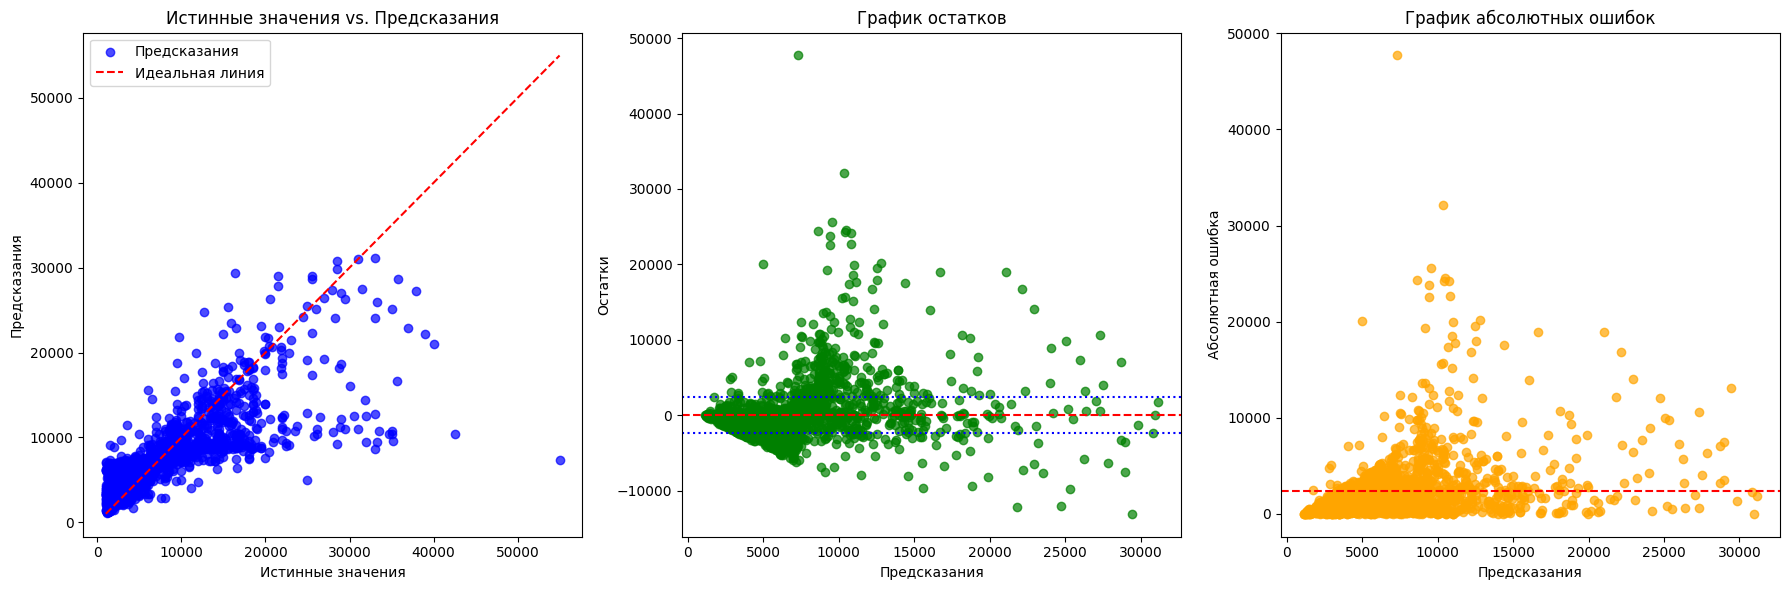

Модель RandomForestRegressor_0.999MAPEstart
----------------------------------------------------------------------
метрика - neg_mean_absolute_percentage_error
метрика модели на трейне: 0.07
метрика модели на тесте: 0.49
MAE модели на тесте: 2377.89
метрика лучшей модели на кроссвалидации: -0.15
----------------------------------------------------------------------
Время обучения: 8464.36 сек.
Время предсказания: 0.05 сек.
Лучшие параметры: {'regressor__n_estimators': 75, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 25, 'regressor__bootstrap': True, 'preprocessor__num__scaler': None, 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'median'}


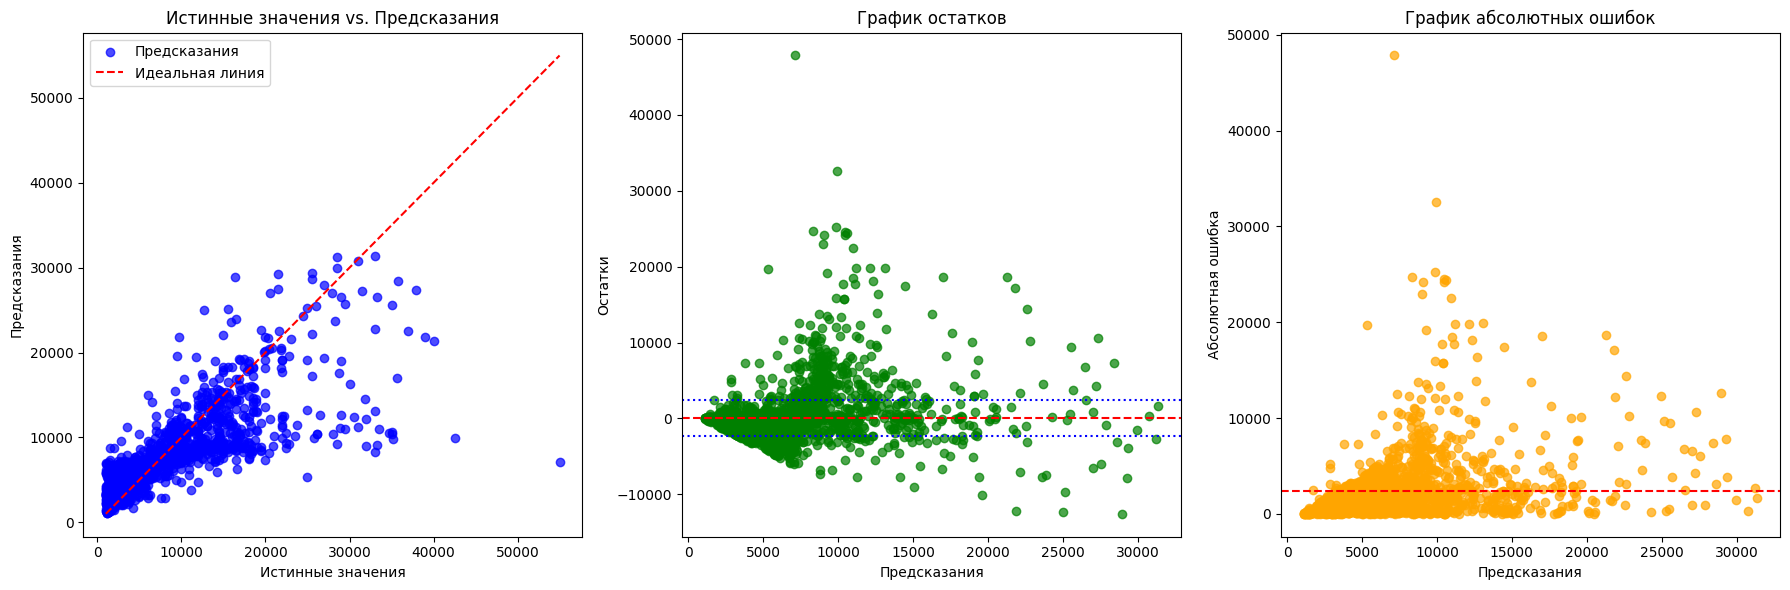

Модель RandomForestRegressor_0.999RMSEstart
----------------------------------------------------------------------
метрика - r2
метрика модели на трейне: 0.98
метрика модели на тесте: 0.62
MAE модели на тесте: 2384.7
метрика лучшей модели на кроссвалидации: 0.9
----------------------------------------------------------------------
Время обучения: 8454.14 сек.
Время предсказания: 0.07 сек.
Лучшие параметры: {'regressor__n_estimators': 125, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 15, 'regressor__bootstrap': True, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'most_frequent', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'most_frequent'}


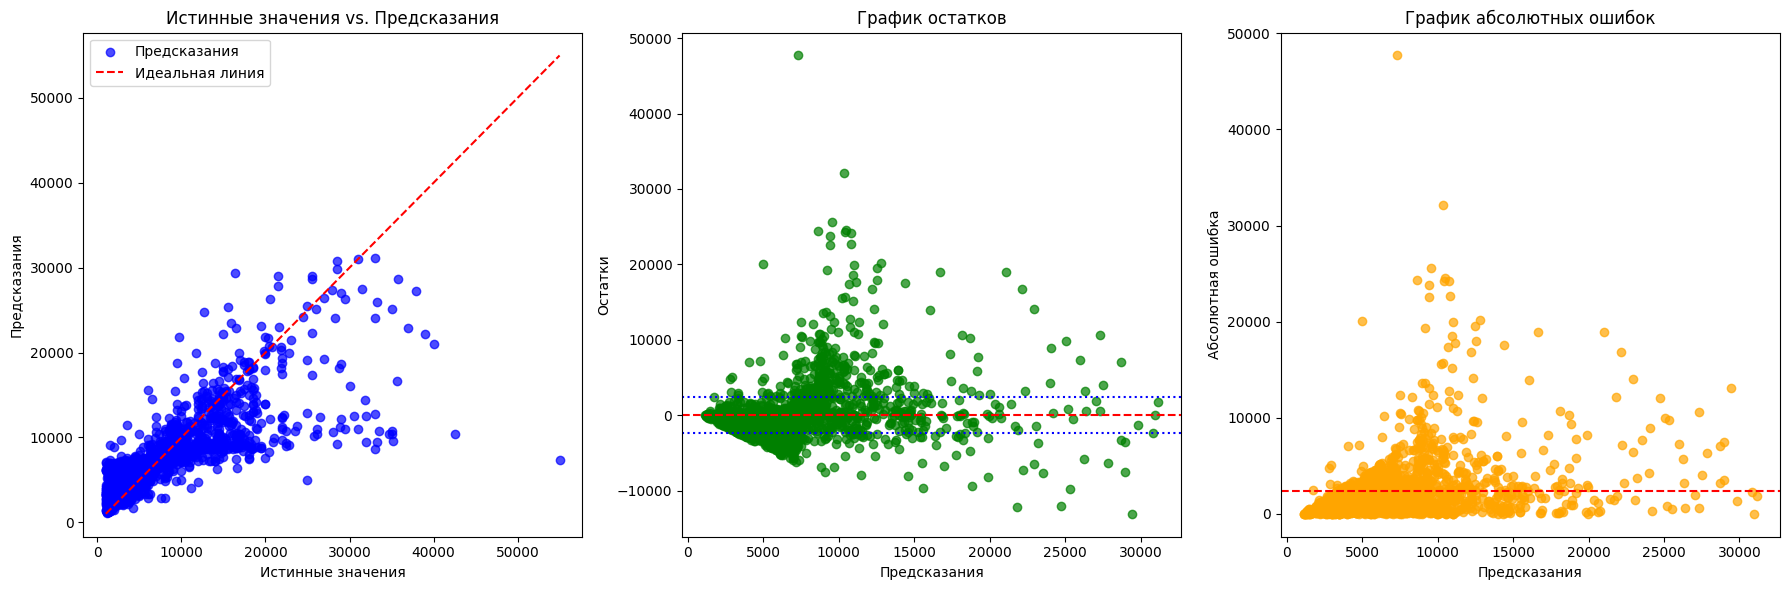

CPU times: total: 4min 37s
Wall time: 9h 24min 31s


model          cv     train        test  \
0  RandomForestRegressor_0.999MAPEstart       -0.15      0.07        0.49   
1   RandomForestRegressor_0.999MSEstart -4248548.89 964914.64 16568177.90   
2  RandomForestRegressor_0.999RMSEstart        0.90      0.98        0.62   
3   RandomForestRegressor_0.999MAEstart     -992.11    442.04     2387.89   

   test_MAE  training_time  prediction_time  \
0   2377.89        8464.36             0.05   
1   2384.70        8483.46             0.07   
2   2384.70        8454.14             0.07   
3   2387.89        8466.77             0.09   

                                                                                                                                                                                                                                                                                                                                    best_parametrs  
0                                            {'regressor__n_estimators': 75, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 25, 'regressor__bootstrap': True, 'preprocessor__num__scaler': None, 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'median'}  
1  {'regressor__n_estimators': 125, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 15, 'regressor__bootstrap': True, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'most_frequent', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'most_frequent'}  
2  {'regressor__n_estimators': 125, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 15, 'regressor__bootstrap': True, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'most_frequent', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'most_frequent'}  
3                {'regressor__n_estimators': 150, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 25, 'regressor__bootstrap': True, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'median'}

In [231]:
%%time
for i, j in enumerate(scor):
    model_name = 'RandomForestRegressor_' + str(multicol) + str(j) + 'start'
    models[model_name] = {}
    model = RandomForestRegressor(random_state=RS, ) 
    n_iter = 1000
    pipeline = Pipeline([
        ('preprocessor', preprocessor), 
        ('regressor', model)
    ])
    param_serch = {    
        #'regressor__n_estimators': [75],
        #'regressor__max_depth': [None],
        #'regressor__min_samples_leaf': [5],
        #'regressor__bootstrap': [False],
        #          
        #'preprocessor__cat__onehot': [None],
        #'preprocessor__num__scaler': [None],
        #                  
        #'preprocessor__cat__imputer__strategy': ['mean'],
        #'preprocessor__num__imputer__strategy': ['median'],
    
        'regressor__n_estimators': [50, 75, 100, 125, 150],
        'regressor__max_depth': [None, 5, 10, 15, 20, 25],
        'regressor__min_samples_leaf': [1, 2, 3, 4, 5],
        'regressor__bootstrap': [True, False],
        
        'preprocessor__cat__onehot': [OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), None],
        'preprocessor__num__scaler': [StandardScaler(with_mean=False), RobustScaler(with_centering=False), None],
                      
        'preprocessor__cat__imputer__strategy': ['mean', 'median', 'most_frequent', ],
        'preprocessor__num__imputer__strategy': ['mean', 'median', 'most_frequent', ],
    }
    results_models_v1, models  = create_ren_model(model_name, pipeline, 
                                                         param_serch, X_train, 
                                                         X_test, y_train, 
                                                         y_test, scorer[i], scoring[i],
                                                         models, results_models_v1, 
                                                         RS, n_iter)
rm = results_models_v1[results_models_v1['model'].str.contains('RandomForestRegressor', case=False, na=False)].sort_values('test_MAE', ascending=True).reset_index(drop=True)
rm

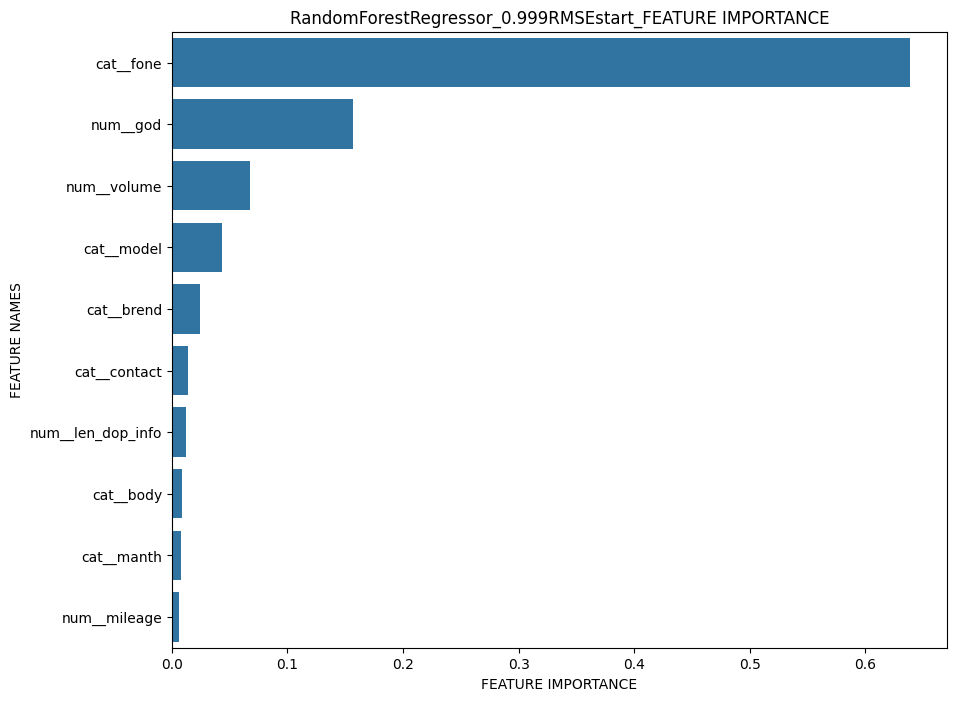

In [232]:
plot_feature_importance_10(models[rm.loc[0,'model']]['best_model'][1].feature_importances_, 
                           models[rm.loc[0,'model']]['best_model'][0].get_feature_names_out(), 
                           model_name + '_')

#### Градиентный бустинг `Catboost`

Модель CatBoostRegressor_0.999MAEstart
----------------------------------------------------------------------
метрика - neg_mean_absolute_error
метрика модели на трейне: 680.81
метрика модели на тесте: 1343.11
MAE модели на тесте: 1343.11
метрика лучшей модели на кроссвалидации: -1259.82
----------------------------------------------------------------------
Время обучения: 1161.92 сек.
Время предсказания: 2.14 сек.
Лучшие параметры: {'regressor__iterations': 1000, 'regressor__depth': 10, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'median'}


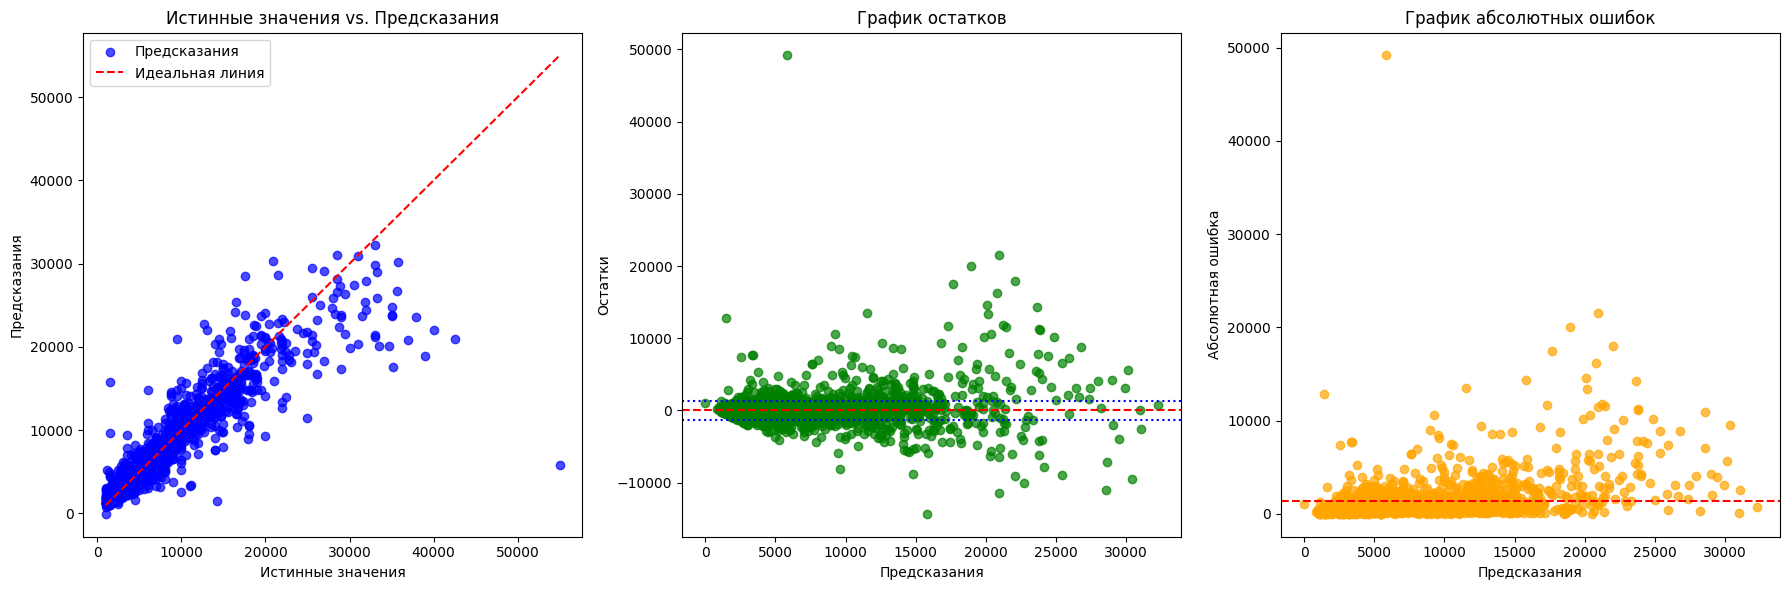

Модель CatBoostRegressor_0.999MSEstart
----------------------------------------------------------------------
метрика - neg_mean_squared_error
метрика модели на трейне: 1292051.9
метрика модели на тесте: 6838643.32
MAE модели на тесте: 1354.77
метрика лучшей модели на кроссвалидации: -4767229.56
----------------------------------------------------------------------
Время обучения: 1137.9 сек.
Время предсказания: 2.15 сек.
Лучшие параметры: {'regressor__iterations': 1000, 'regressor__depth': 8, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'mean'}


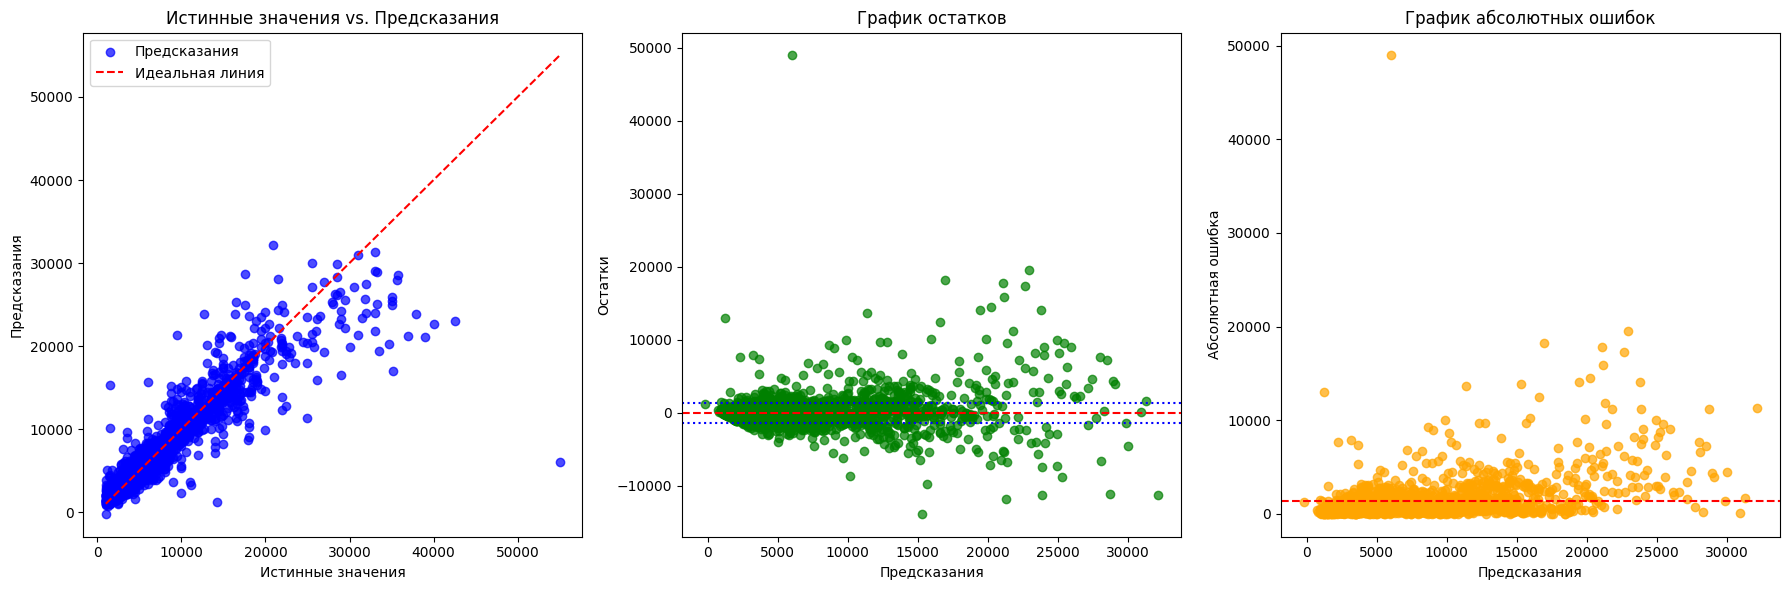

Модель CatBoostRegressor_0.999MAPEstart
----------------------------------------------------------------------
метрика - neg_mean_absolute_percentage_error
метрика модели на трейне: 0.14
метрика модели на тесте: 0.22
MAE модели на тесте: 1343.11
метрика лучшей модели на кроссвалидации: -0.22
----------------------------------------------------------------------
Время обучения: 1178.08 сек.
Время предсказания: 2.11 сек.
Лучшие параметры: {'regressor__iterations': 1000, 'regressor__depth': 10, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'median'}


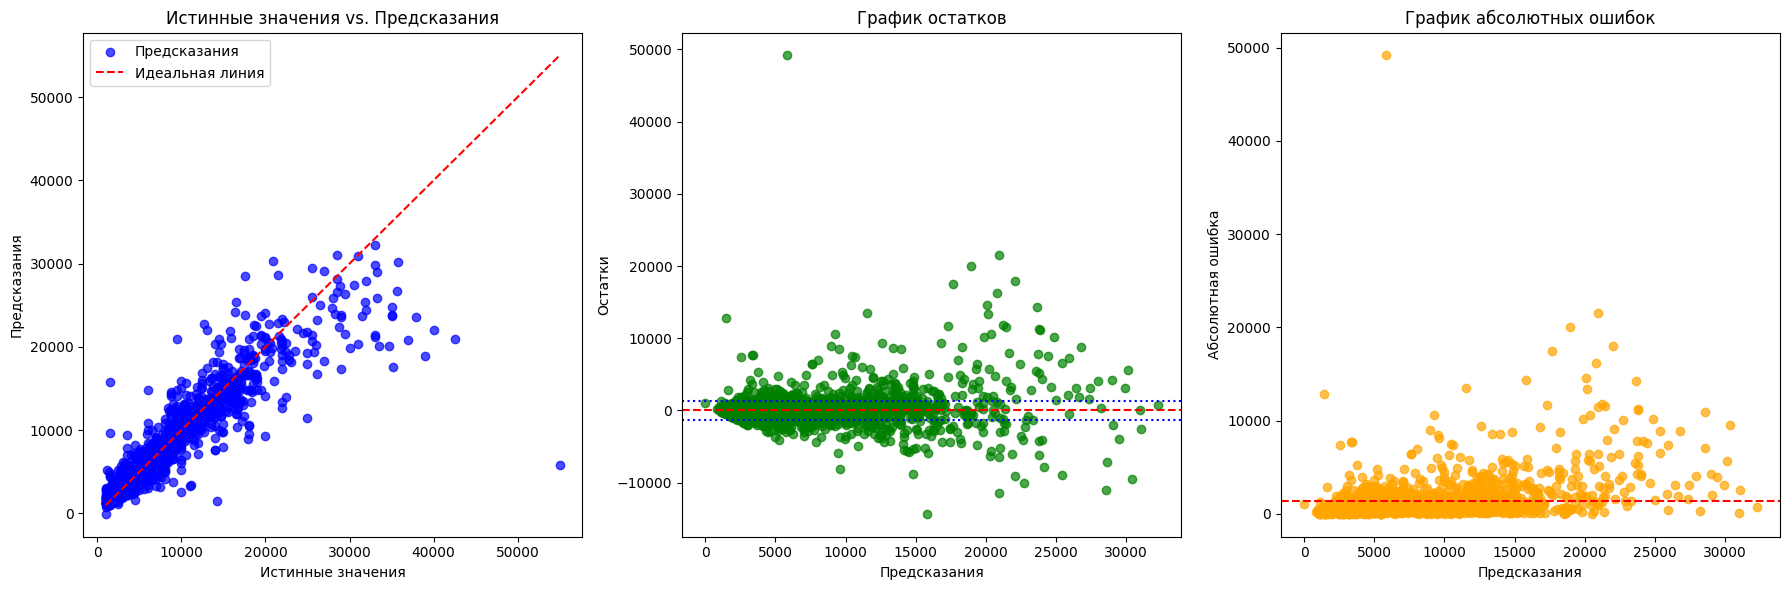

Модель CatBoostRegressor_0.999RMSEstart
----------------------------------------------------------------------
метрика - r2
метрика модели на трейне: 0.97
метрика модели на тесте: 0.84
MAE модели на тесте: 1354.77
метрика лучшей модели на кроссвалидации: 0.88
----------------------------------------------------------------------
Время обучения: 1139.04 сек.
Время предсказания: 2.14 сек.
Лучшие параметры: {'regressor__iterations': 1000, 'regressor__depth': 8, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'mean'}


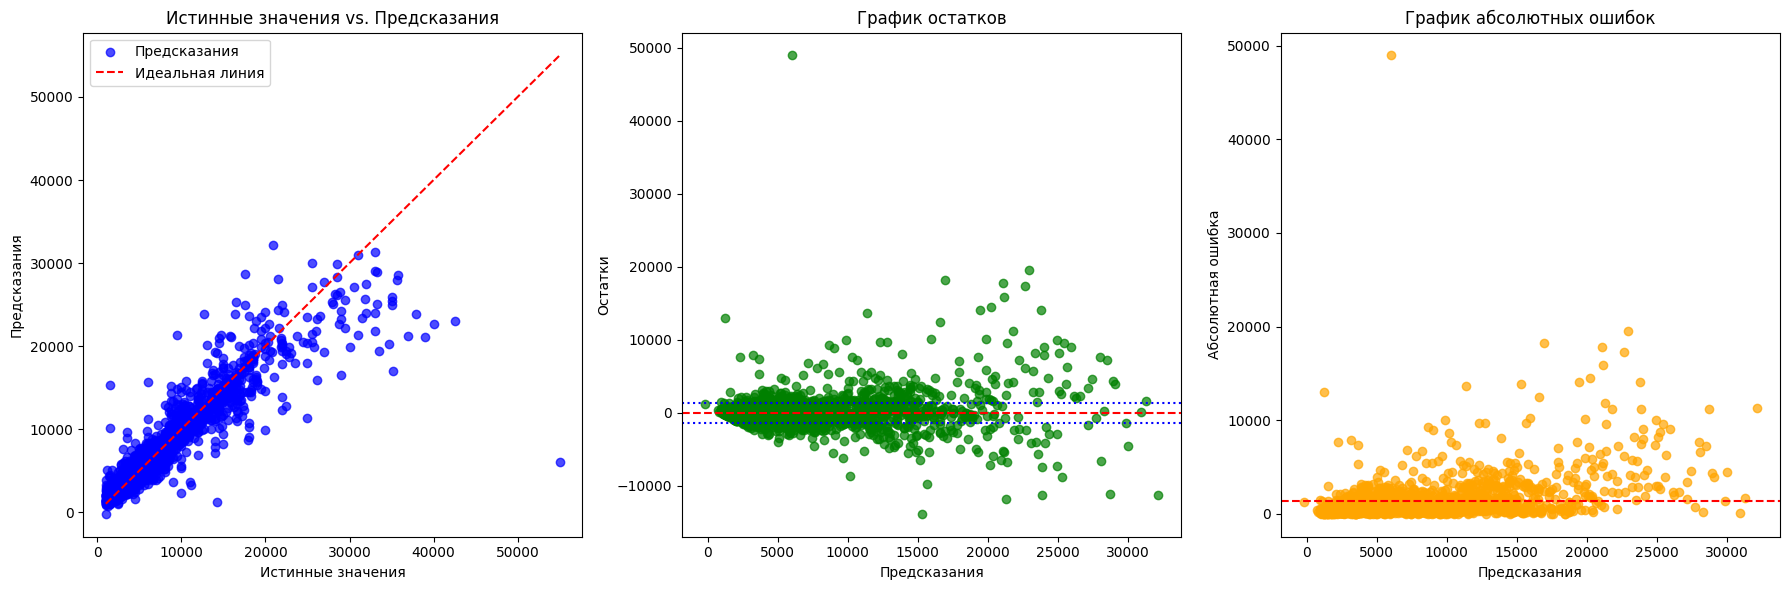

CPU times: total: 9min 43s
Wall time: 1h 17min 19s


model          cv      train       test  \
0   CatBoostRegressor_0.999MAEstart    -1259.83     680.81    1343.11   
1  CatBoostRegressor_0.999MAPEstart       -0.22       0.14       0.22   
2   CatBoostRegressor_0.999MSEstart -4767229.56 1292051.90 6838643.32   
3  CatBoostRegressor_0.999RMSEstart        0.88       0.97       0.84   

   test_MAE  training_time  prediction_time  \
0   1343.11        1161.92             2.14   
1   1343.11        1178.08             2.11   
2   1354.77        1137.90             2.15   
3   1354.77        1139.04             2.14   

                                                                                                                                                                                                                                                                                                                      best_parametrs  
0  {'regressor__iterations': 1000, 'regressor__depth': 10, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'median'}  
1  {'regressor__iterations': 1000, 'regressor__depth': 10, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'median'}  
2       {'regressor__iterations': 1000, 'regressor__depth': 8, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'mean'}  
3       {'regressor__iterations': 1000, 'regressor__depth': 8, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'mean'}

In [234]:
%%time
for i, j in enumerate(scor):
    model_name = 'CatBoostRegressor_' + str(multicol) + str(j) + 'start'
    models[model_name] = {}
    model = CatBoostRegressor(random_state=RS, silent=True,  )
    n_iter = 75
    pipeline = Pipeline([
        ('preprocessor', preprocessor), 
        ('regressor', model)
    ])
    param_serch = { 
        #'regressor__depth': [10],
        #'regressor__iterations': [100],
        #
        'preprocessor__cat__onehot': [OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)],
        'preprocessor__num__scaler': [StandardScaler(with_mean=False)],
        #
        #'preprocessor__cat__imputer__strategy': ['mean'],
        #'preprocessor__num__imputer__strategy': ['mean'],  
    #
        'regressor__depth': [3,4,5,6,7,8,9,10],
        'regressor__iterations': [100,300,400,500,600,700,800,900,1000],
        
        #'preprocessor__cat__onehot': [OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), None],
        #'preprocessor__num__scaler': [StandardScaler(with_mean=False), RobustScaler(with_centering=False), None],
        
        'preprocessor__cat__imputer__strategy': ['mean', 'median', 'constant', ],
        'preprocessor__num__imputer__strategy': ['mean', 'median', 'constant', ],   
    }
    results_models_v1, models  = create_ren_model(model_name, pipeline, 
                                                         param_serch, X_train, 
                                                         X_test, y_train, 
                                                         y_test, scorer[i], scoring[i],
                                                         models, results_models_v1, 
                                                         RS, n_iter)
rm = results_models_v1[results_models_v1['model'].str.contains('CatBoost', case=False, na=False)].sort_values('test_MAE', ascending=True).reset_index(drop=True)
rm

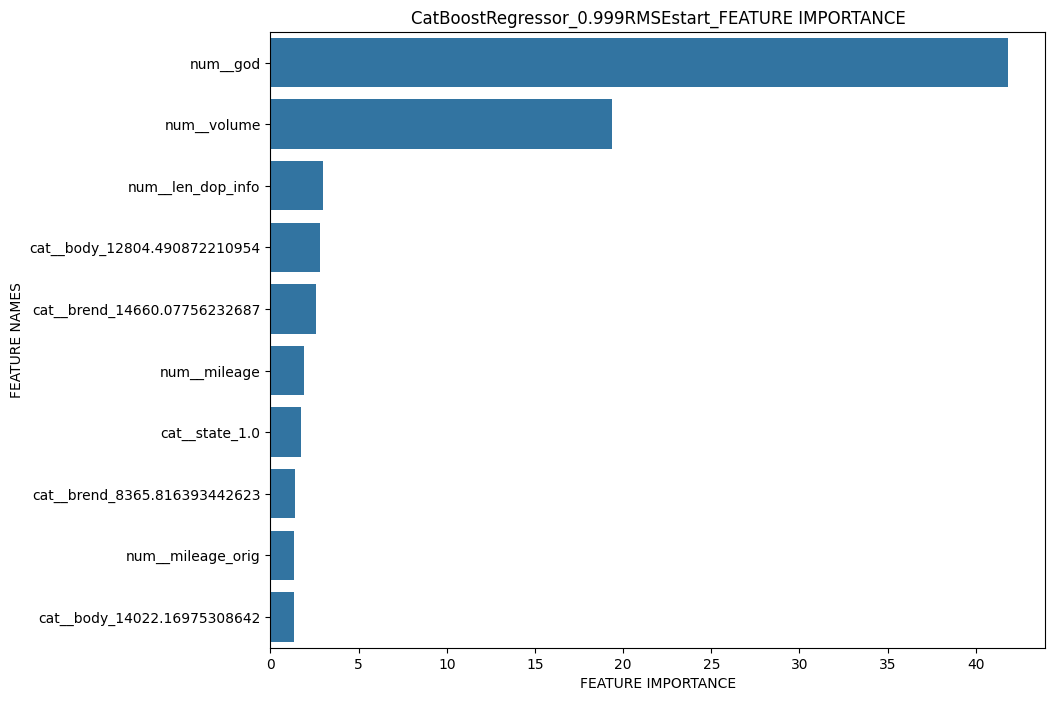

In [235]:
plot_feature_importance_10(models[rm.loc[0,'model']]['best_model'][1].feature_importances_, 
                           models[rm.loc[0,'model']]['best_model'][0].get_feature_names_out(), 
                           model_name + '_')

#### Градиентный бустинг `LGBMClassifier`

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1743
[LightGBM] [Info] Number of data points in the train set: 4353, number of used features: 19
[LightGBM] [Info] Start training from score 7457.110039
Модель LGBMRegressor_0.999MAEstart
----------------------------------------------------------------------
метрика - neg_mean_absolute_error
метрика модели на трейне: 306.02
метрика модели на тесте: 2101.03
MAE модели на тесте: 2101.03
метрика лучшей модели на кроссвалидации: -1035.84
----------------------------------------------------------------------
Время обучения: 518.2 сек.
Время предсказания: 0.02 сек.
Лучшие параметры: {'regressor__num_leaves': 150, 'regressor__n_estimators': 100, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': None, 'preprocessor__

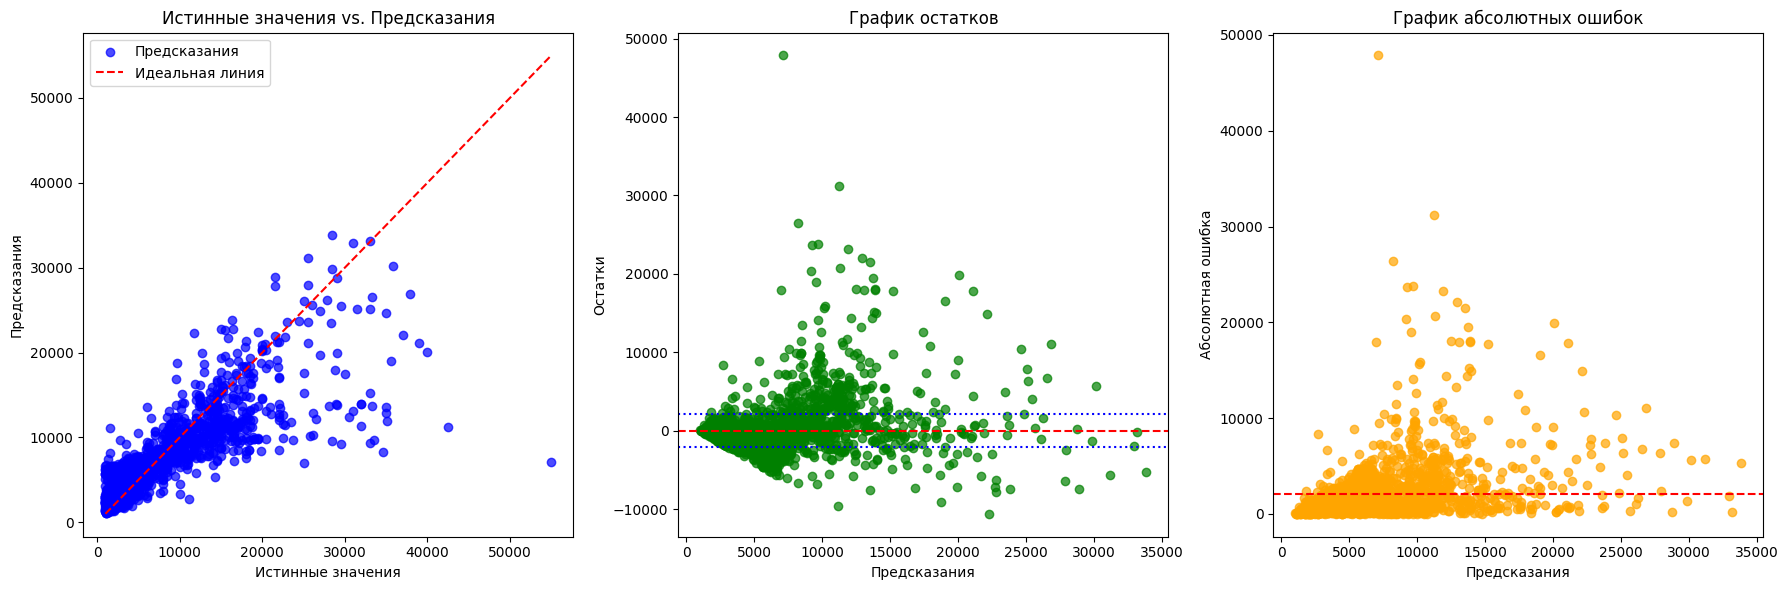

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1744
[LightGBM] [Info] Number of data points in the train set: 4353, number of used features: 19
[LightGBM] [Info] Start training from score 7457.110039
Модель LGBMRegressor_0.999MSEstart
----------------------------------------------------------------------
метрика - neg_mean_squared_error
метрика модели на трейне: 543816.32
метрика модели на тесте: 13861144.0
MAE модели на тесте: 2241.89
метрика лучшей модели на кроссвалидации: -3778971.24
----------------------------------------------------------------------
Время обучения: 516.28 сек.
Время предсказания: 0.02 сек.
Лучшие параметры: {'regressor__num_leaves': 31, 'regressor__n_estimators': 200, 'preprocessor__num__scaler': RobustScaler(with_centering=False), 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__cat__onehot': None, 'prepr

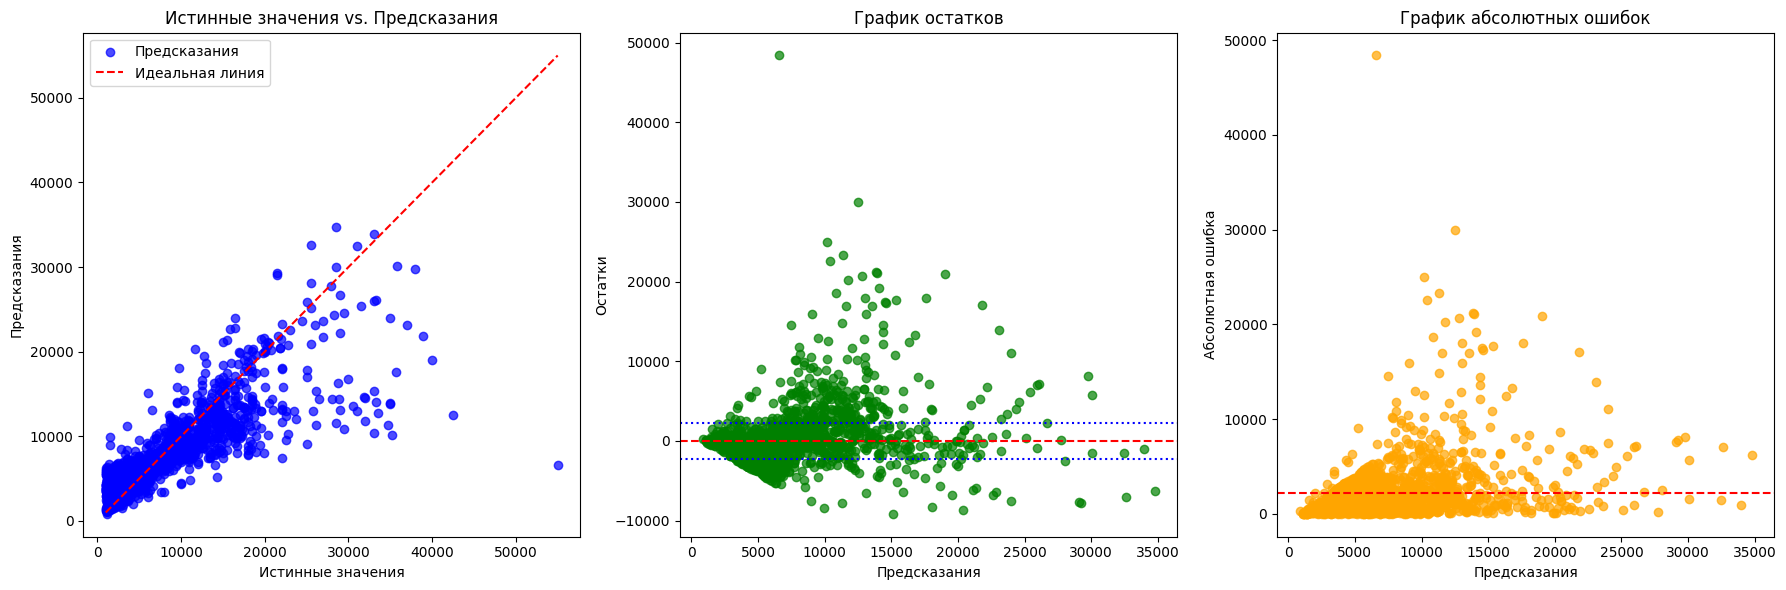

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1743
[LightGBM] [Info] Number of data points in the train set: 4353, number of used features: 19
[LightGBM] [Info] Start training from score 7457.110039
Модель LGBMRegressor_0.999MAPEstart
----------------------------------------------------------------------
метрика - neg_mean_absolute_percentage_error
метрика модели на трейне: 0.06
метрика модели на тесте: 0.4
MAE модели на тесте: 2110.51
метрика лучшей модели на кроссвалидации: -0.16
----------------------------------------------------------------------
Время обучения: 516.17 сек.
Время предсказания: 0.01 сек.
Лучшие параметры: {'regressor__num_leaves': 150, 'regressor__n_estimators': 75, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': None, 'preprocesso

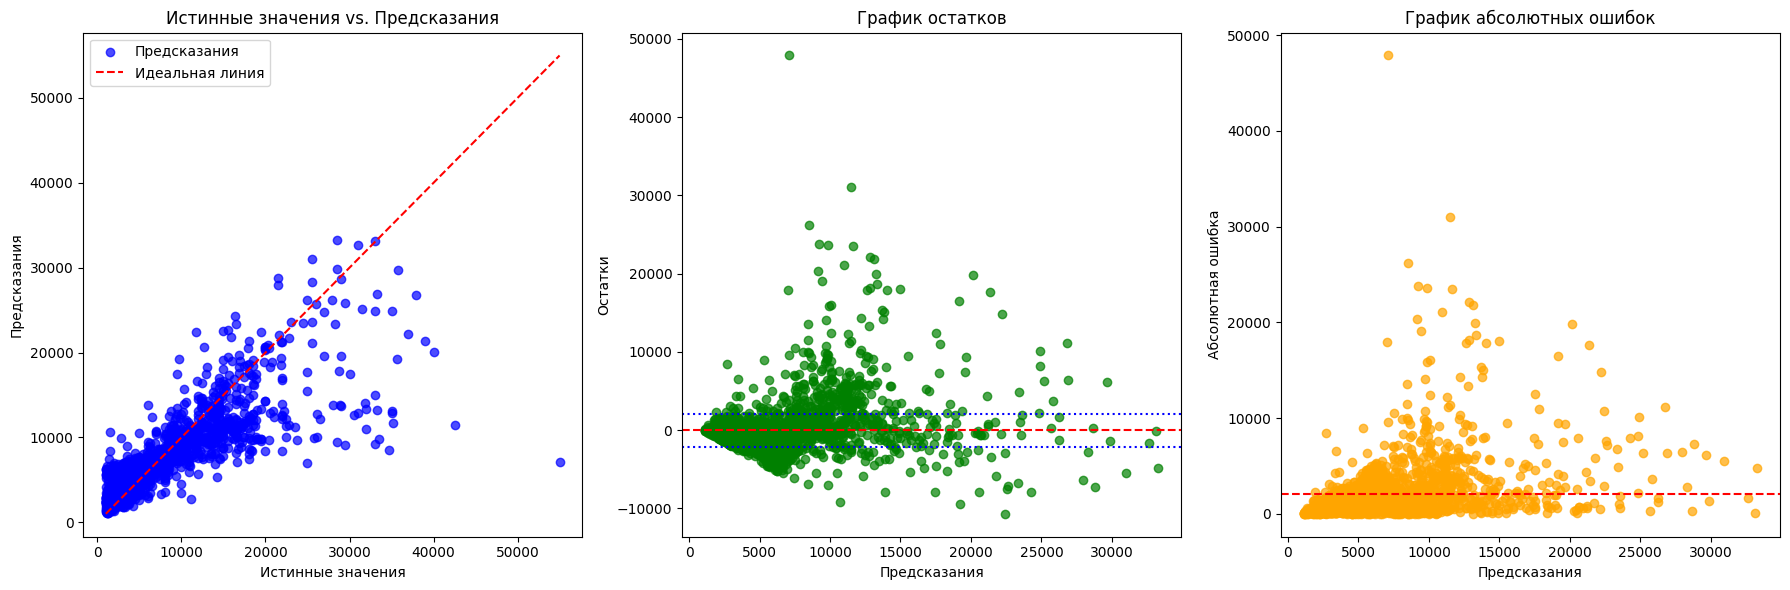

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1744
[LightGBM] [Info] Number of data points in the train set: 4353, number of used features: 19
[LightGBM] [Info] Start training from score 7457.110039
Модель LGBMRegressor_0.999RMSEstart
----------------------------------------------------------------------
метрика - r2
метрика модели на трейне: 0.99
метрика модели на тесте: 0.68
MAE модели на тесте: 2241.89
метрика лучшей модели на кроссвалидации: 0.91
----------------------------------------------------------------------
Время обучения: 515.95 сек.
Время предсказания: 0.02 сек.
Лучшие параметры: {'regressor__num_leaves': 31, 'regressor__n_estimators': 200, 'preprocessor__num__scaler': RobustScaler(with_centering=False), 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'me

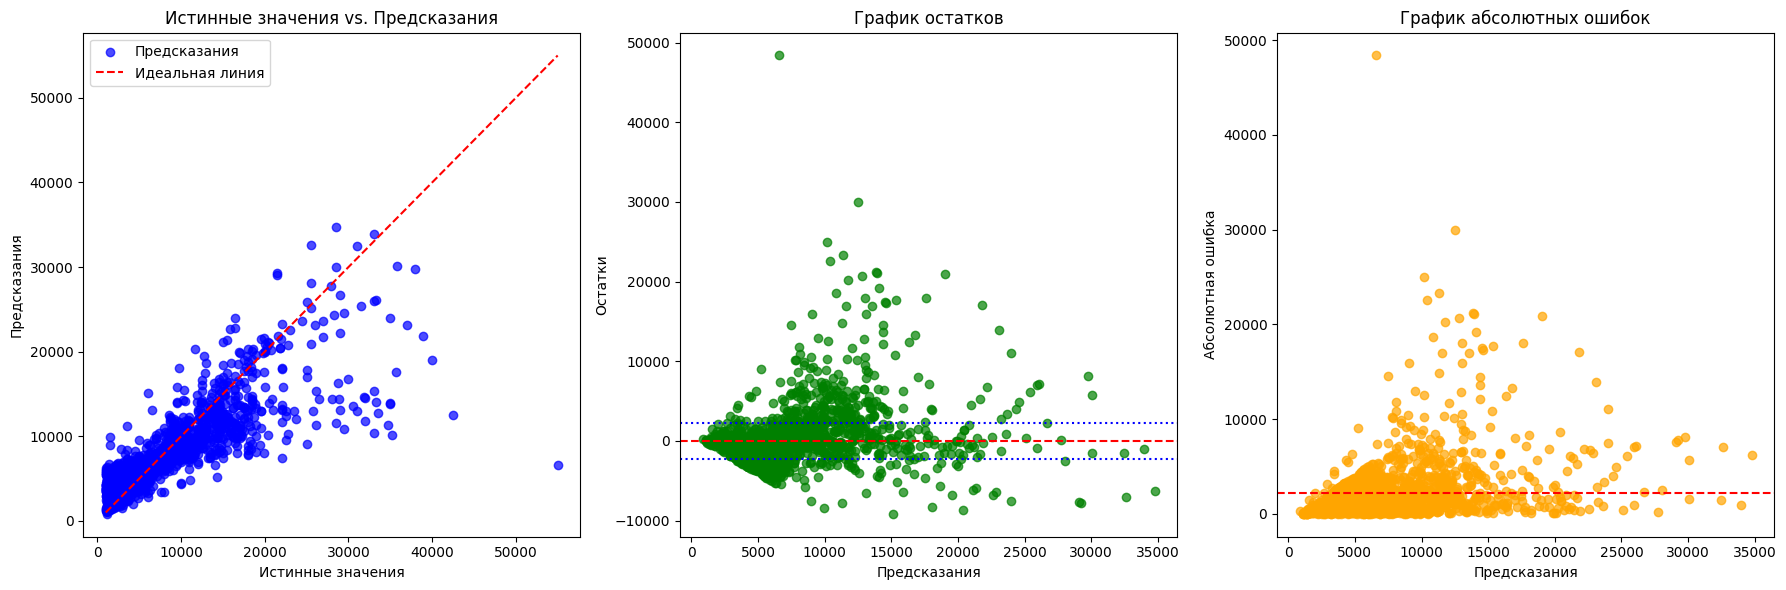

CPU times: total: 2min 15s
Wall time: 34min 29s


model          cv     train        test  test_MAE  \
0   LGBMRegressor_0.999MAEstart    -1035.84    306.02     2101.03   2101.03   
1  LGBMRegressor_0.999MAPEstart       -0.16      0.06        0.40   2110.51   
2   LGBMRegressor_0.999MSEstart -3778971.24 543816.32 13861144.00   2241.89   
3  LGBMRegressor_0.999RMSEstart        0.91      0.99        0.68   2241.89   

   training_time  prediction_time  \
0         518.20             0.02   
1         516.17             0.01   
2         516.28             0.02   
3         515.95             0.02   

                                                                                                                                                                                                                                                         best_parametrs  
0   {'regressor__num_leaves': 150, 'regressor__n_estimators': 100, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'median'}  
1  {'regressor__num_leaves': 150, 'regressor__n_estimators': 75, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'constant'}  
2   {'regressor__num_leaves': 31, 'regressor__n_estimators': 200, 'preprocessor__num__scaler': RobustScaler(with_centering=False), 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'median'}  
3   {'regressor__num_leaves': 31, 'regressor__n_estimators': 200, 'preprocessor__num__scaler': RobustScaler(with_centering=False), 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'median'}

In [237]:
%%time
for i, j in enumerate(scor):
    model_name = 'LGBMRegressor_' + str(multicol) + str(j) + 'start'
    models[model_name] = {}
    model = LGBMRegressor(random_state=RS, )
    n_iter = 1000
    pipeline = Pipeline([
        ('preprocessor', preprocessor), 
        ('regressor', model)
    ])
    param_serch = {    
        #'regressor__n_estimators': [50],
        #'regressor__num_leaves': [31],    
       #
        #'preprocessor__cat__onehot': [OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)],
        #'preprocessor__num__scaler': [StandardScaler(with_mean=False)],
    #
        #'preprocessor__cat__imputer__strategy': ['mean'],
        #'preprocessor__num__imputer__strategy': ['mean'],    
    
        'regressor__n_estimators': [50,75,100,125,150,175,200],
        'regressor__num_leaves': [31,40,50,75,100,150],
    
        'preprocessor__cat__onehot': [OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), None],
        'preprocessor__num__scaler': [StandardScaler(with_mean=False), RobustScaler(with_centering=False), None],
    
        'preprocessor__cat__imputer__strategy': ['mean', 'median', 'constant', ],
        'preprocessor__num__imputer__strategy': ['mean', 'median', 'constant', ],  
    }
    results_models_v1, models  = create_ren_model( model_name, pipeline, 
                                                         param_serch, X_train, 
                                                         X_test, y_train, 
                                                         y_test, scorer[i], scoring[i],
                                                         models, results_models_v1, 
                                                         RS, n_iter)
rm = results_models_v1[results_models_v1['model'].str.contains('LGBM', case=False, na=False)].sort_values('test_MAE', ascending=True).reset_index(drop=True)
rm

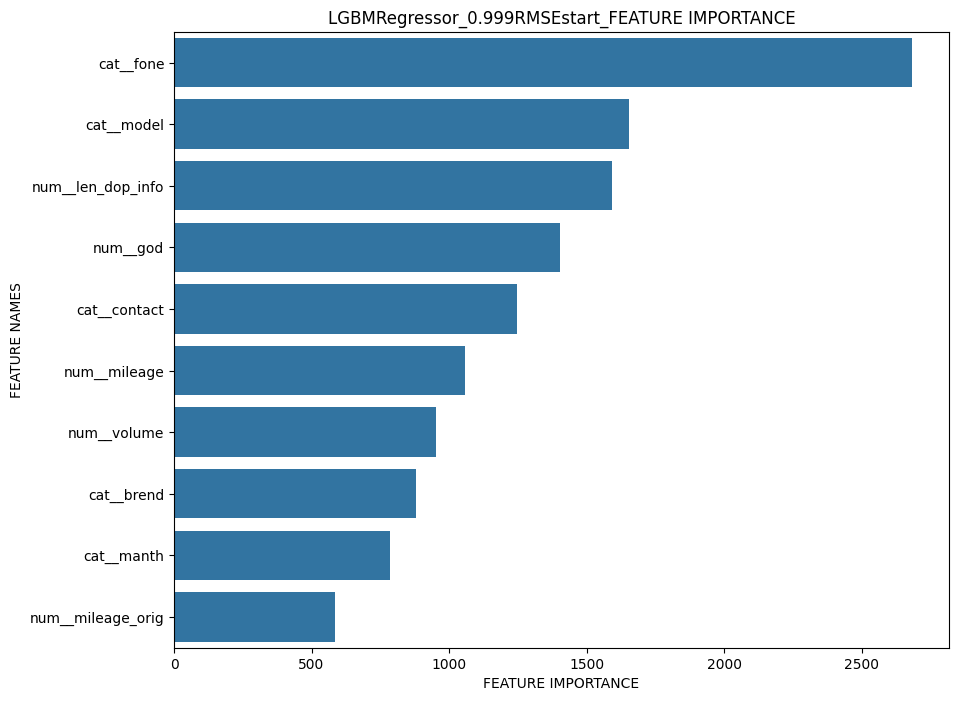

In [238]:
plot_feature_importance_10(models[rm.loc[0,'model']]['best_model'][1].feature_importances_, 
                           models[rm.loc[0,'model']]['best_model'][0].get_feature_names_out(), 
                           model_name + '_')

#### Дерево решений `DecisionTreeClassifier`

Модель DecisionTreeRegressor_0.999MAEstart
----------------------------------------------------------------------
метрика - neg_mean_absolute_error
метрика модели на трейне: 604.16
метрика модели на тесте: 2541.94
MAE модели на тесте: 2541.94
метрика лучшей модели на кроссвалидации: -1283.83
----------------------------------------------------------------------
Время обучения: 182.11 сек.
Время предсказания: 0.01 сек.
Лучшие параметры: {'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 4, 'regressor__max_depth': 30, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'median'}


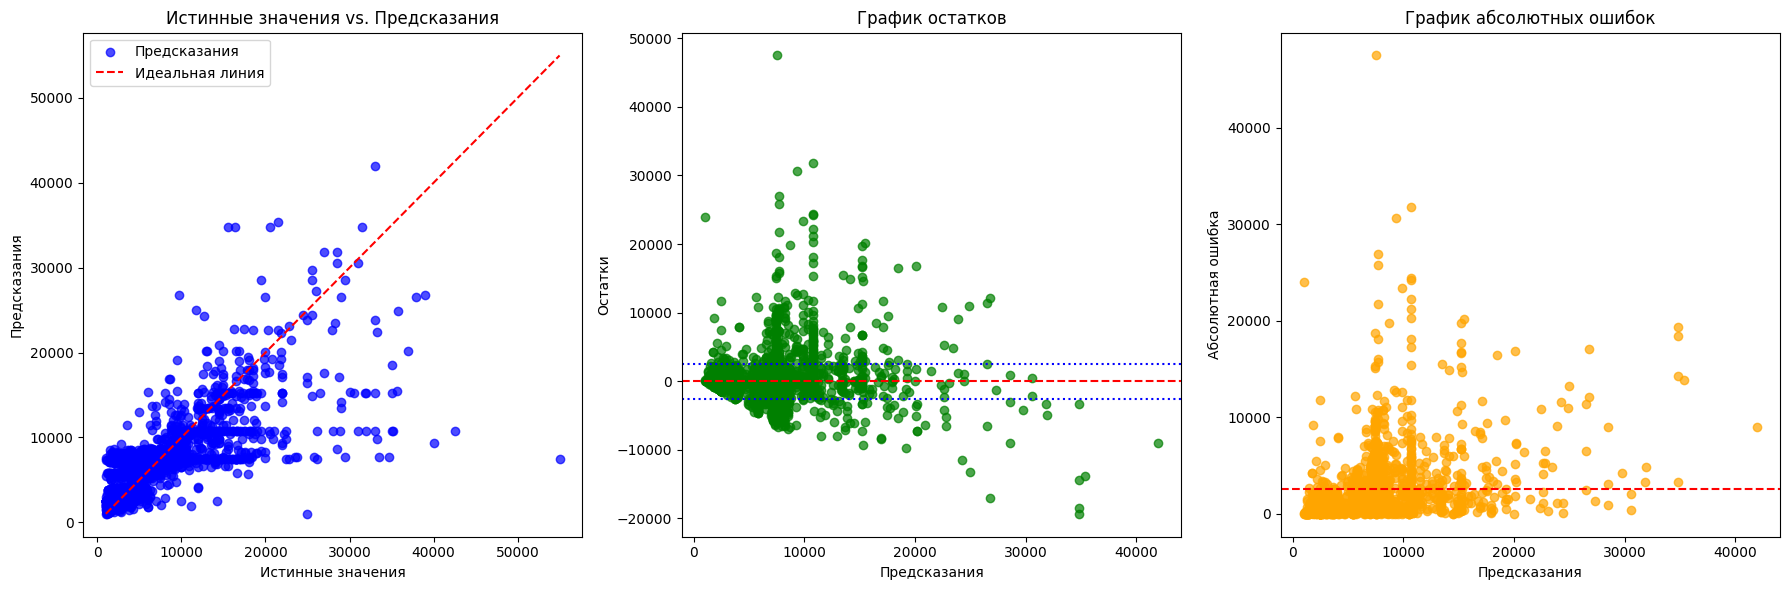

Модель DecisionTreeRegressor_0.999MSEstart
----------------------------------------------------------------------
метрика - neg_mean_squared_error
метрика модели на трейне: 1858824.92
метрика модели на тесте: 19673567.94
MAE модели на тесте: 2593.42
метрика лучшей модели на кроссвалидации: -6499175.4
----------------------------------------------------------------------
Время обучения: 180.6 сек.
Время предсказания: 0.01 сек.
Лучшие параметры: {'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 4, 'regressor__max_depth': 15, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'mean'}


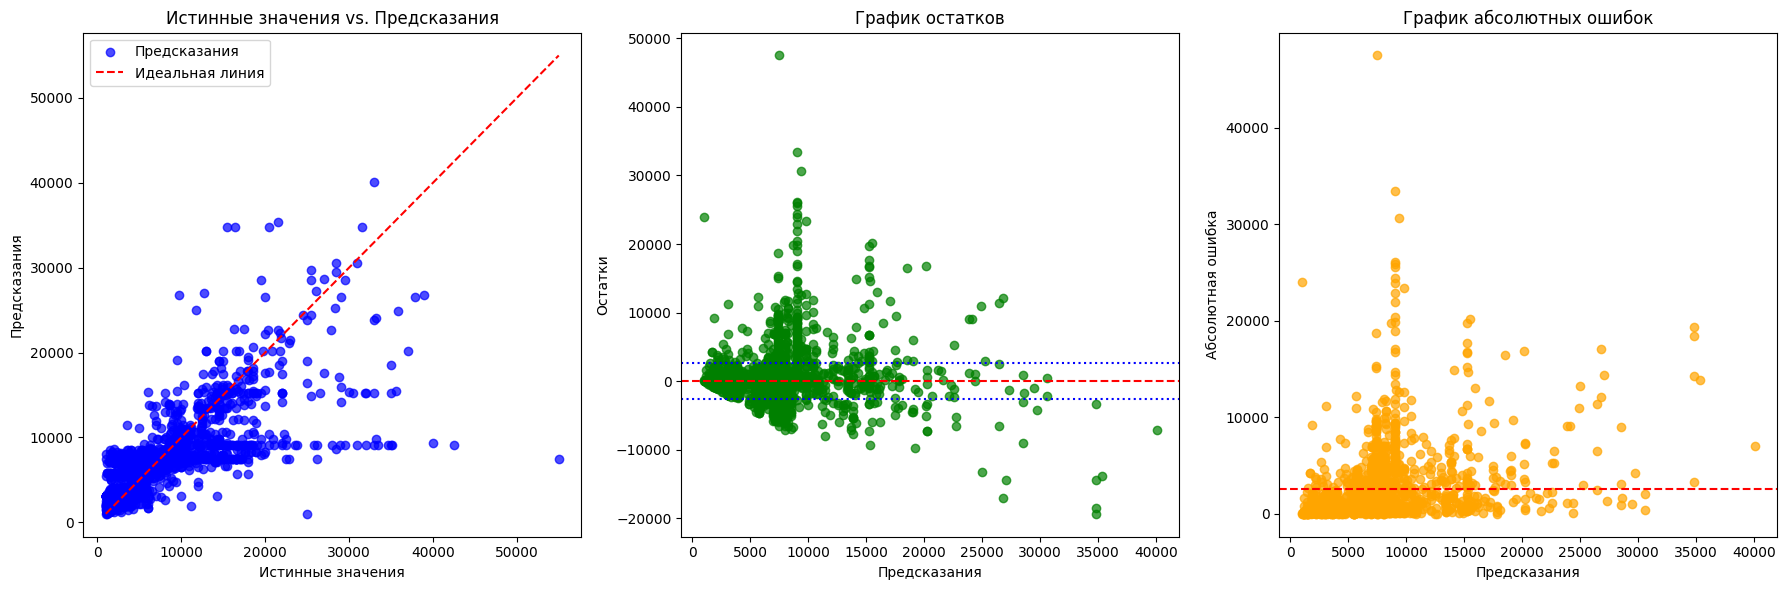

Модель DecisionTreeRegressor_0.999MAPEstart
----------------------------------------------------------------------
метрика - neg_mean_absolute_percentage_error
метрика модели на трейне: 0.07
метрика модели на тесте: 0.45
MAE модели на тесте: 2582.65
метрика лучшей модели на кроссвалидации: -0.18
----------------------------------------------------------------------
Время обучения: 180.19 сек.
Время предсказания: 0.01 сек.
Лучшие параметры: {'regressor__min_samples_split': 9, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 20, 'preprocessor__num__scaler': None, 'preprocessor__num__imputer__strategy': 'constant', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'median'}


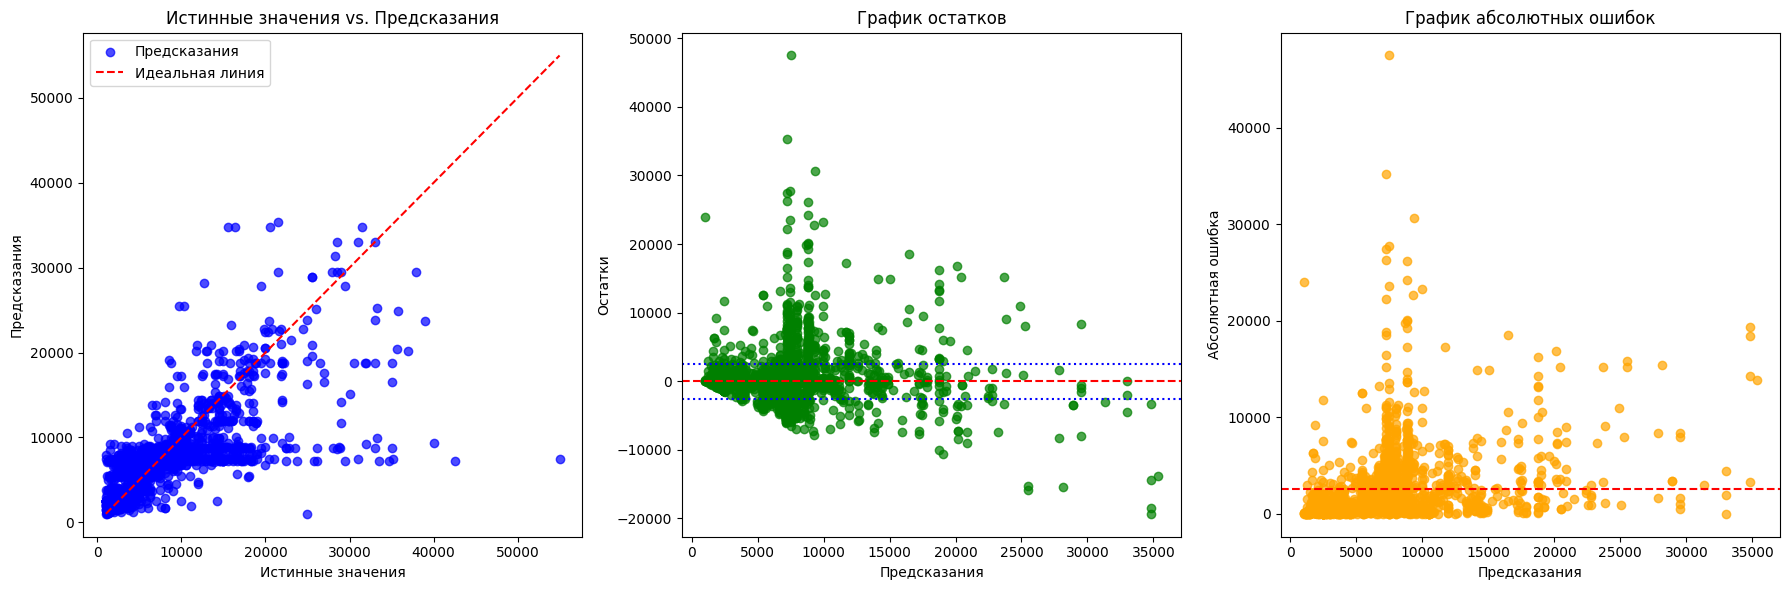

Модель DecisionTreeRegressor_0.999RMSEstart
----------------------------------------------------------------------
метрика - r2
метрика модели на трейне: 0.95
метрика модели на тесте: 0.55
MAE модели на тесте: 2593.42
метрика лучшей модели на кроссвалидации: 0.84
----------------------------------------------------------------------
Время обучения: 181.31 сек.
Время предсказания: 0.01 сек.
Лучшие параметры: {'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 4, 'regressor__max_depth': 15, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'mean'}


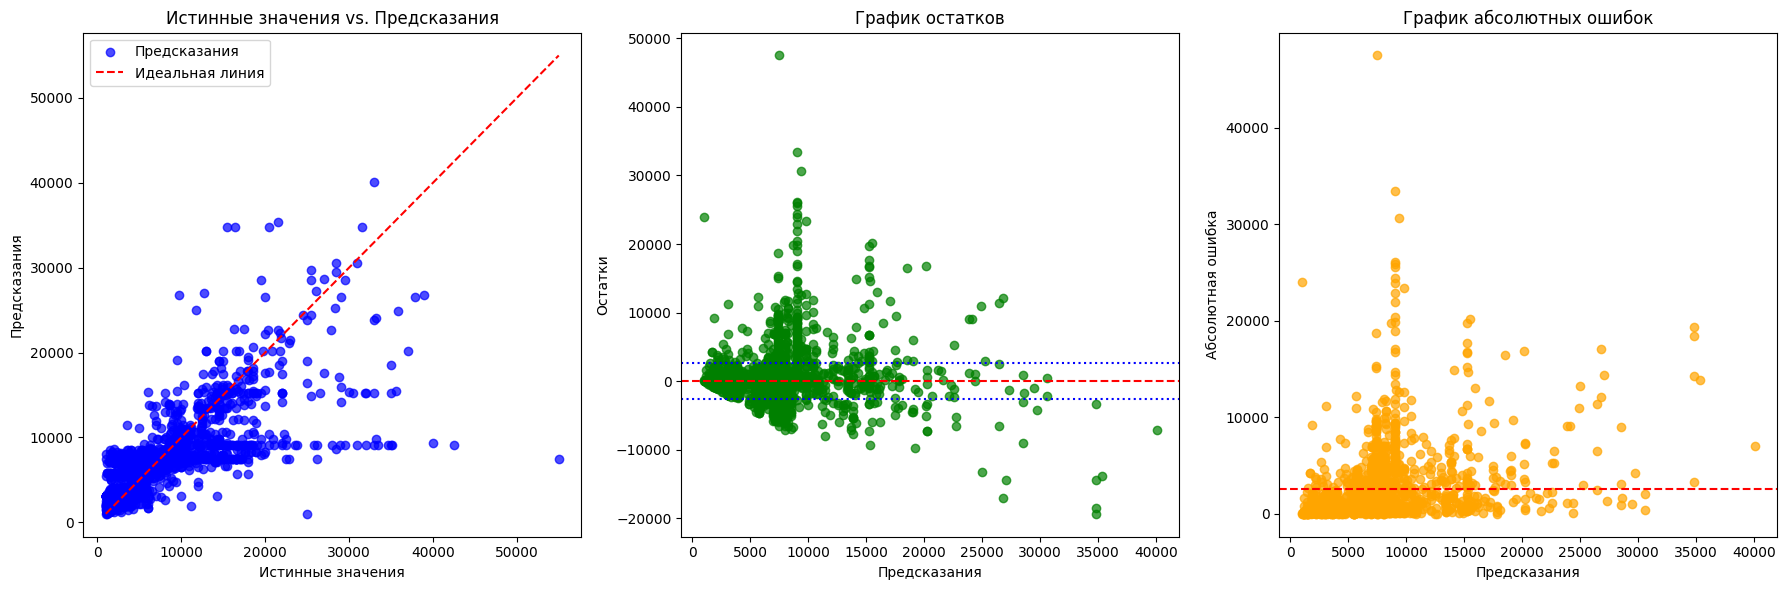

CPU times: total: 2min 23s
Wall time: 12min 6s


model          cv      train        test  \
0   DecisionTreeRegressor_0.999MAEstart    -1283.83     604.16     2541.94   
1  DecisionTreeRegressor_0.999MAPEstart       -0.18       0.07        0.45   
2   DecisionTreeRegressor_0.999MSEstart -6499175.40 1858824.92 19673567.94   
3  DecisionTreeRegressor_0.999RMSEstart        0.84       0.95        0.55   

   test_MAE  training_time  prediction_time  \
0   2541.94         182.11             0.01   
1   2582.65         180.19             0.01   
2   2593.42         180.60             0.01   
3   2593.42         181.31             0.01   

                                                                                                                                                                                                                                                                                           best_parametrs  
0  {'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 4, 'regressor__max_depth': 30, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'median'}  
1                           {'regressor__min_samples_split': 9, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 20, 'preprocessor__num__scaler': None, 'preprocessor__num__imputer__strategy': 'constant', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'median'}  
2   {'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 4, 'regressor__max_depth': 15, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'mean'}  
3   {'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 4, 'regressor__max_depth': 15, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': None, 'preprocessor__cat__imputer__strategy': 'mean'}

In [240]:
%%time
for i, j in enumerate(scor):
    model_name = 'DecisionTreeRegressor_' + str(multicol) + str(j) + 'start'
    models[model_name] = {}
    model = DecisionTreeRegressor(random_state=RS, )
    n_iter = 1000
    pipeline = Pipeline([
        ('preprocessor', preprocessor), 
        ('regressor', model)
    ])
    param_serch = {
        #'regressor__max_depth': [20],
        #'regressor__min_samples_split': [2],
        #'regressor__min_samples_leaf': [1],
                                
        #'preprocessor__cat__onehot': [OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)],
        #'preprocessor__num__scaler': [StandardScaler(with_mean=False)],
                        
        #'preprocessor__cat__imputer__strategy': ['mean'],
        #'preprocessor__num__imputer__strategy': ['mean'],
        
        'regressor__max_depth': [5, 10, 15, 20, 25, 30, None],
        'regressor__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
        'regressor__min_samples_leaf': [1, 2, 3, 4, 5],
               
        'preprocessor__cat__onehot': [OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), None],
        'preprocessor__num__scaler': [StandardScaler(with_mean=False), RobustScaler(with_centering=False), None],
                   
        'preprocessor__cat__imputer__strategy': ['mean', 'median', 'constant', ],
        'preprocessor__num__imputer__strategy': ['mean', 'median', 'constant', ],     
    
        #'preprocessor__cat__selection__k': [49,45,40,35,30,25,20,15,10,5],
        #'preprocessor__num__selection__k': [20,15,10,5],
    }
    results_models_v1, models  = create_ren_model( model_name, pipeline, 
                                                         param_serch, X_train, 
                                                         X_test, y_train, 
                                                         y_test, scorer[i], scoring[i],
                                                         models, results_models_v1, 
                                                         RS, n_iter)
rm = results_models_v1[results_models_v1['model'].str.contains('DecisionTree', case=False, na=False)].sort_values('test_MAE', ascending=True).reset_index(drop=True)
rm

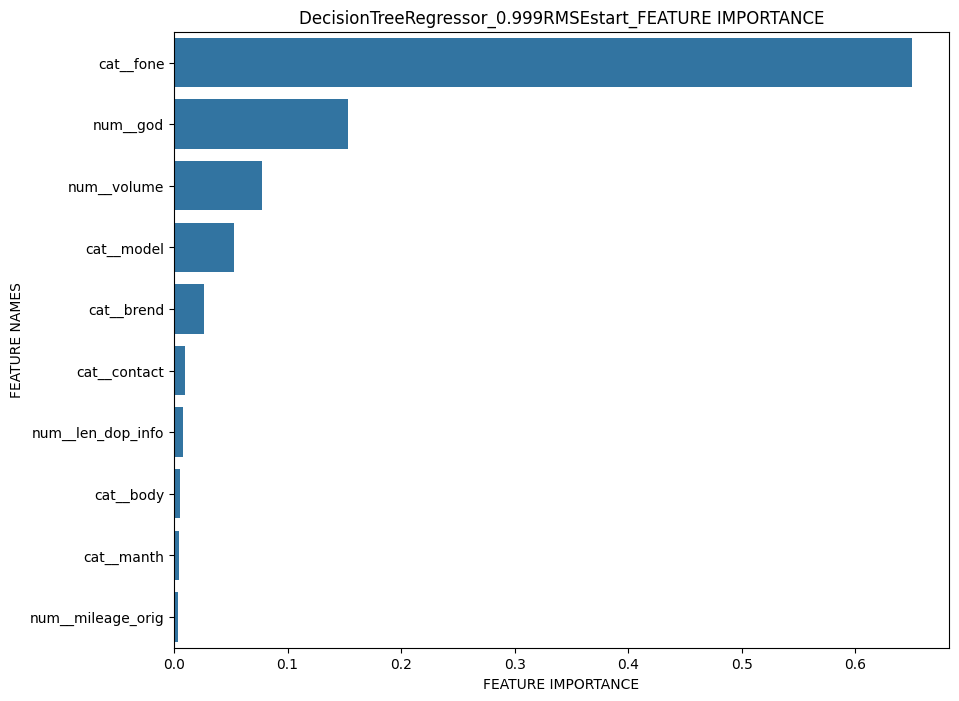

In [241]:
plot_feature_importance_10(models[rm.loc[0,'model']]['best_model'][1].feature_importances_, 
                           models[rm.loc[0,'model']]['best_model'][0].get_feature_names_out(), 
                           model_name + '_')

#### Логистическая регрессия `LogisticRegression`

In [243]:
from sklearn.linear_model import LinearRegression

Модель LinearRegression_0.999MAEstart
----------------------------------------------------------------------
метрика - neg_mean_absolute_error
метрика модели на трейне: 995.69
метрика модели на тесте: 2375.86
MAE модели на тесте: 2375.86
метрика лучшей модели на кроссвалидации: -2178.18
----------------------------------------------------------------------
Время обучения: 229.4 сек.
Время предсказания: 0.07 сек.
Лучшие параметры: {'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'mean'}


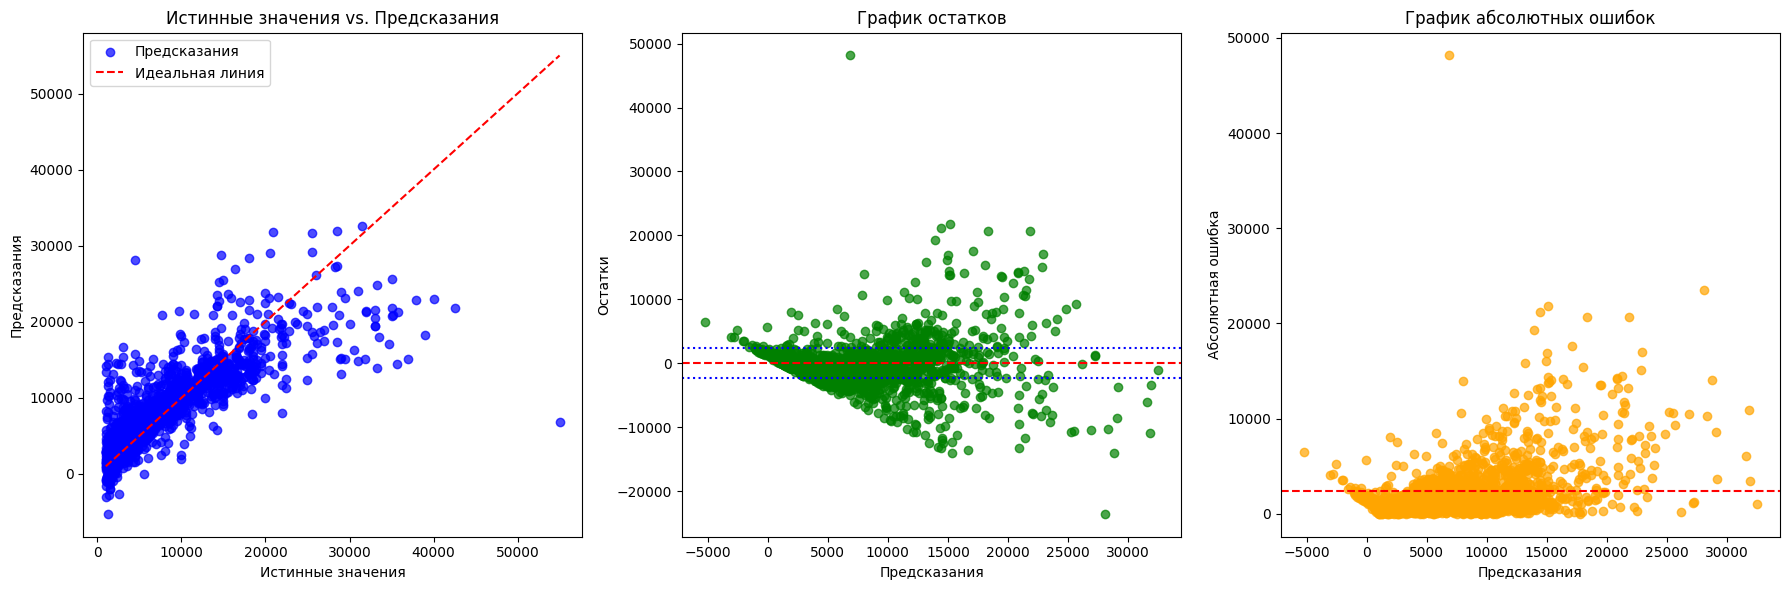

Модель LinearRegression_0.999MSEstart
----------------------------------------------------------------------
метрика - neg_mean_squared_error
метрика модели на трейне: 2593013.5
метрика модели на тесте: 14427937.27
MAE модели на тесте: 2375.86
метрика лучшей модели на кроссвалидации: -12193967.18
----------------------------------------------------------------------
Время обучения: 230.82 сек.
Время предсказания: 0.06 сек.
Лучшие параметры: {'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'mean'}


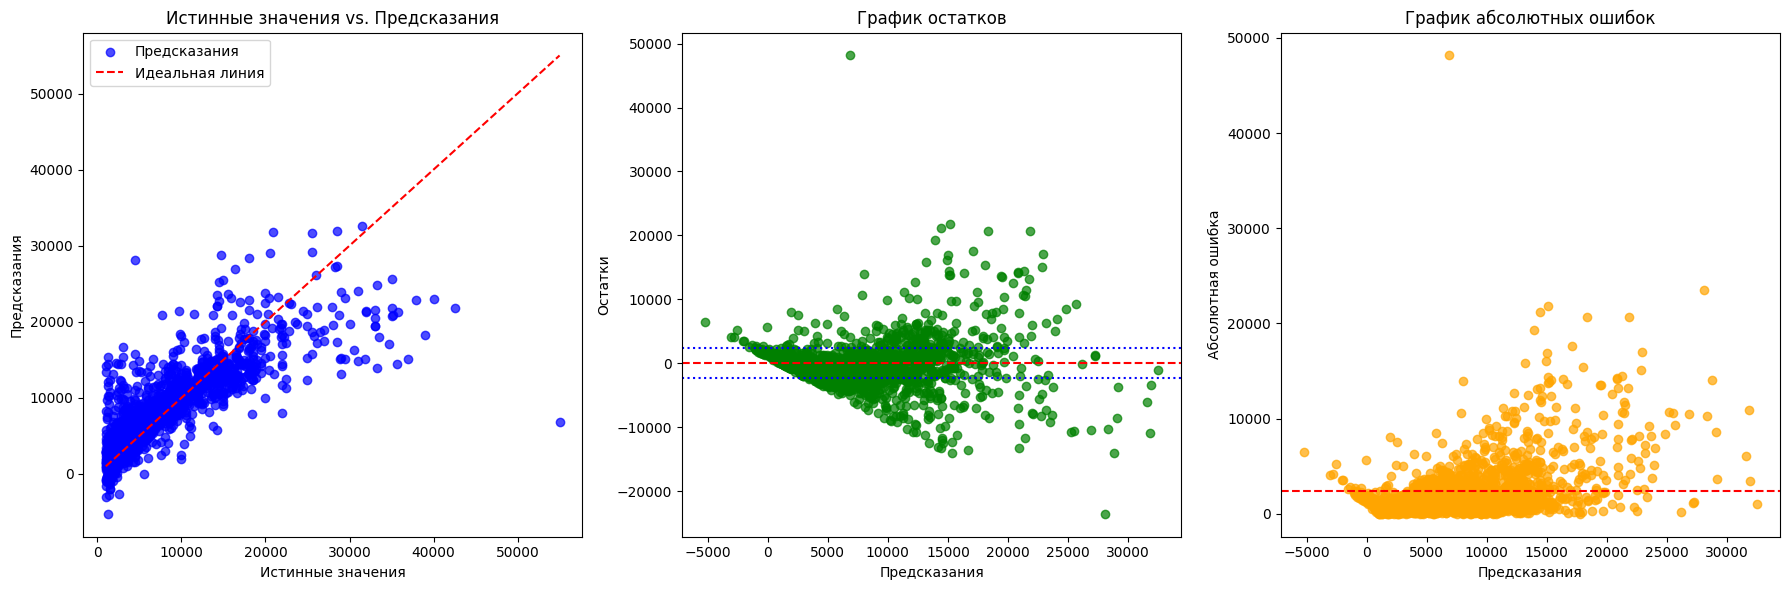

Модель LinearRegression_0.999MAPEstart
----------------------------------------------------------------------
метрика - neg_mean_absolute_percentage_error
метрика модели на трейне: 0.23
метрика модели на тесте: 0.54
MAE модели на тесте: 2368.88
метрика лучшей модели на кроссвалидации: -0.49
----------------------------------------------------------------------
Время обучения: 228.23 сек.
Время предсказания: 0.06 сек.
Лучшие параметры: {'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'mean'}


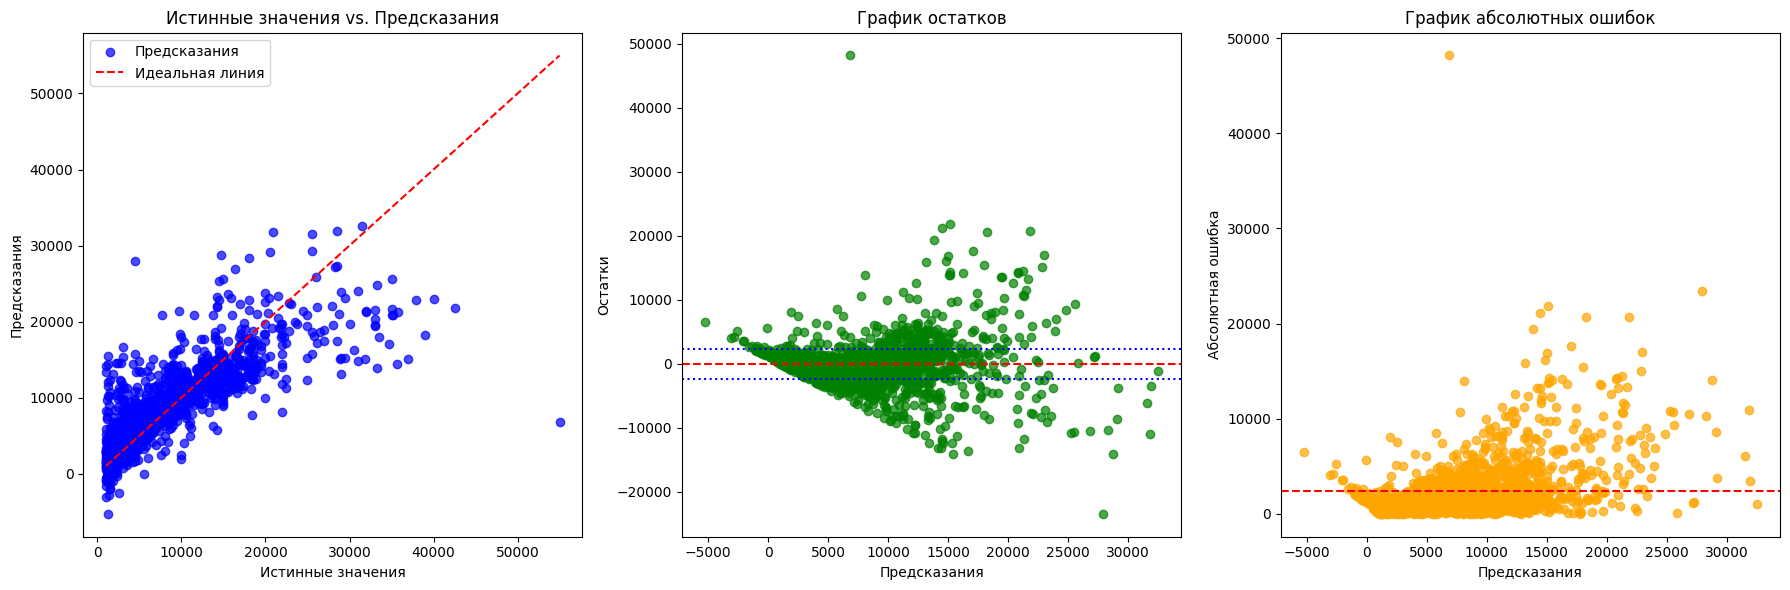

Модель LinearRegression_0.999RMSEstart
----------------------------------------------------------------------
метрика - r2
метрика модели на трейне: 0.94
метрика модели на тесте: 0.67
MAE модели на тесте: 2375.86
метрика лучшей модели на кроссвалидации: 0.7
----------------------------------------------------------------------
Время обучения: 229.31 сек.
Время предсказания: 0.06 сек.
Лучшие параметры: {'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'mean'}


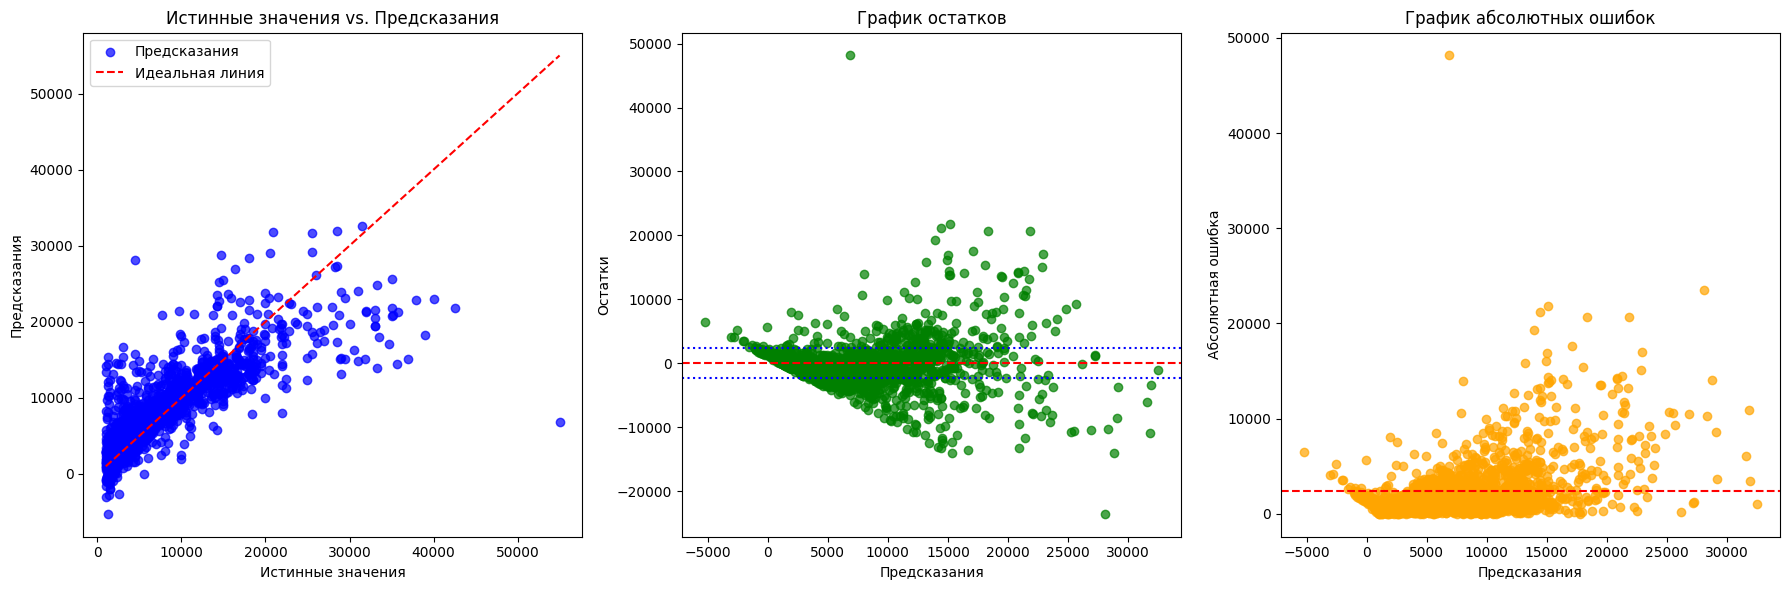

CPU times: total: 52.5 s
Wall time: 15min 20s


model           cv      train        test  \
0  LinearRegression_0.999MAPEstart        -0.49       0.23        0.54   
1   LinearRegression_0.999MAEstart     -2178.18     995.69     2375.86   
2   LinearRegression_0.999MSEstart -12193967.18 2593013.50 14427937.27   
3  LinearRegression_0.999RMSEstart         0.70       0.94        0.67   

   test_MAE  training_time  prediction_time  \
0   2368.88         228.23             0.06   
1   2375.86         229.40             0.07   
2   2375.86         230.82             0.06   
3   2375.86         229.31             0.06   

                                                                                                                                                                                                                                                             best_parametrs  
0    {'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'mean'}  
1  {'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'mean'}  
2  {'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'mean'}  
3  {'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'mean'}

In [244]:
%%time
for i, j in enumerate(scor):
    model_name = 'LinearRegression_' + str(multicol) + str(j) + 'start'
    models[model_name] = {}
    model = LinearRegression()
    n_iter = 1000
    pipeline = Pipeline([
        ('preprocessor', preprocessor), 
        ('regressor', model)
    ])
    param_serch = {    
        #'regressor__penalty':['l1','l2','elasticnet',None],
        #'regressor__C' : np.logspace(-4,4,20),
        #'regressor__solver': ['lbfgs','newton-cg'],
        #'regressor__max_iter'  : [100, 1000, 2500, 5000],
    
        'preprocessor__cat__onehot': [OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), None],
        'preprocessor__num__scaler': [StandardScaler(with_mean=False), RobustScaler(with_centering=False), None],
    
        'preprocessor__cat__imputer__strategy': ['mean', 'median', 'constant', ],
        'preprocessor__num__imputer__strategy': ['mean', 'median', 'constant', ],  
    }
    results_models_v1, models  = create_ren_model( model_name, pipeline, 
                                                         param_serch, X_train, 
                                                         X_test, y_train, 
                                                         y_test, scorer[i], scoring[i],
                                                         models, results_models_v1, 
                                                         RS, n_iter)
rm = results_models_v1[results_models_v1['model'].str.contains('LinearRegression', case=False, na=False)].sort_values('test_MAE', ascending=True).reset_index(drop=True)
rm

plot_feature_importance_10(models[rm.loc[0,'model']]['best_model'][1].feature_importances_, 
                           models[rm.loc[0,'model']]['best_model'][0].get_feature_names_out(), 
                           model_name + '_')

#### Ядерный метод опорных векторов  `SVR`

Модель SVR_0.999MAEstart
----------------------------------------------------------------------
метрика - neg_mean_absolute_error
метрика модели на трейне: 1173.66
метрика модели на тесте: 1732.17
MAE модели на тесте: 1732.17
метрика лучшей модели на кроссвалидации: -1693.96
----------------------------------------------------------------------
Время обучения: 10436.3 сек.
Время предсказания: 23.24 сек.
Лучшие параметры: {'regressor__max_iter': 5000, 'regressor__kernel': 'rbf', 'regressor__gamma': 0.1, 'regressor__C': 1000, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'constant'}


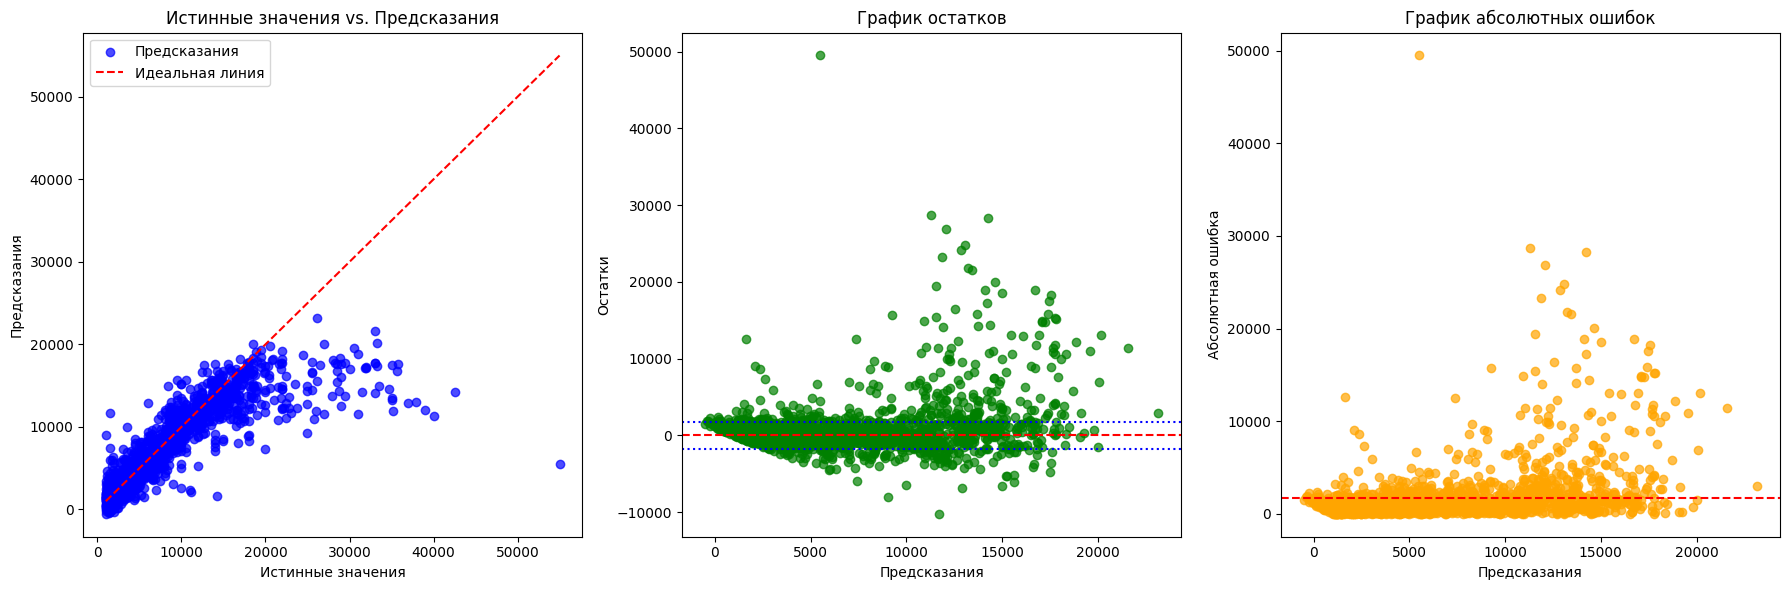

Модель SVR_0.999MSEstart
----------------------------------------------------------------------
метрика - neg_mean_squared_error
метрика модели на трейне: 6879415.48
метрика модели на тесте: 11642214.61
MAE модели на тесте: 1888.52
метрика лучшей модели на кроссвалидации: -9803940.13
----------------------------------------------------------------------
Время обучения: 10557.71 сек.
Время предсказания: 11.71 сек.
Лучшие параметры: {'regressor__max_iter': 5000, 'regressor__kernel': 'linear', 'regressor__gamma': 0.0001, 'regressor__C': 1000, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'constant'}


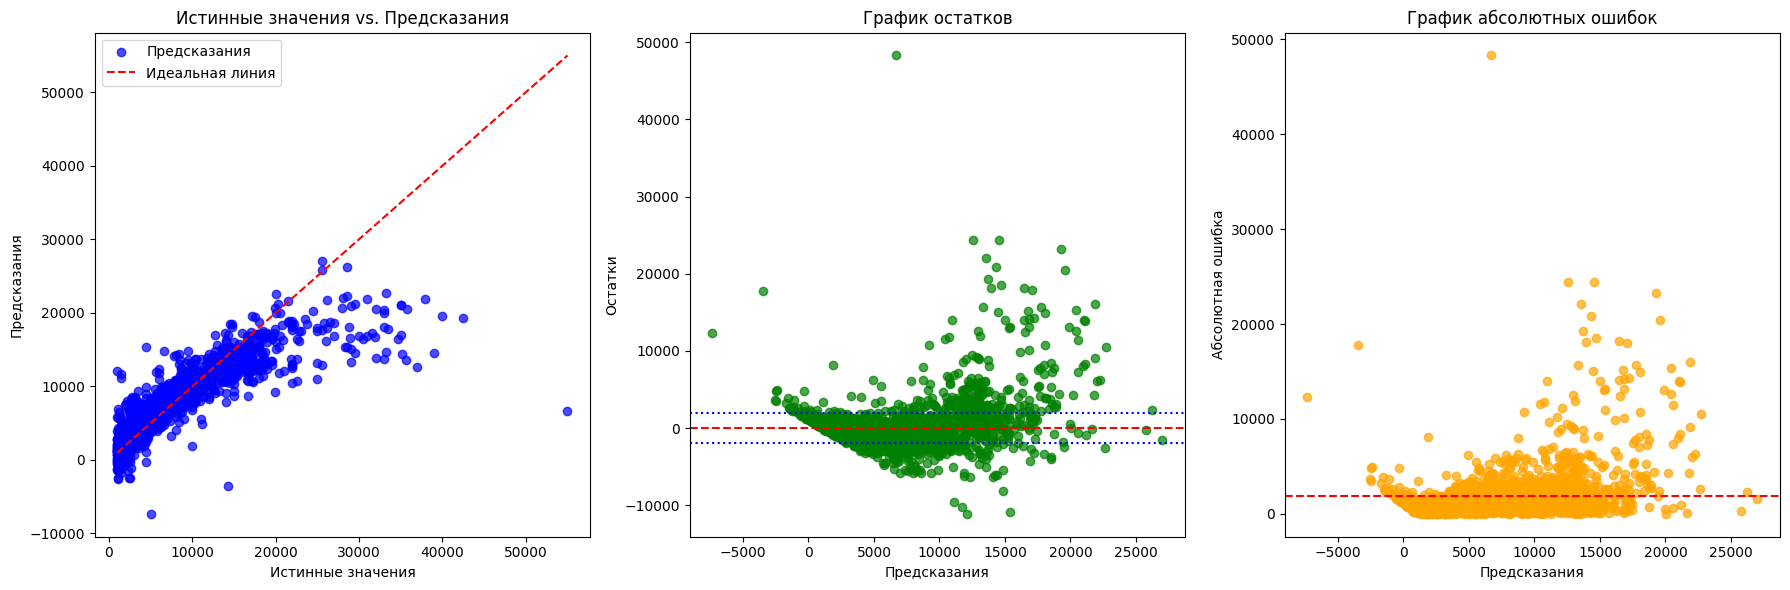

Модель SVR_0.999MAPEstart
----------------------------------------------------------------------
метрика - neg_mean_absolute_percentage_error
метрика модели на трейне: 0.14
метрика модели на тесте: 0.26
MAE модели на тесте: 1732.17
метрика лучшей модели на кроссвалидации: -0.26
----------------------------------------------------------------------
Время обучения: 10437.27 сек.
Время предсказания: 23.24 сек.
Лучшие параметры: {'regressor__max_iter': 5000, 'regressor__kernel': 'rbf', 'regressor__gamma': 0.1, 'regressor__C': 1000, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'constant'}


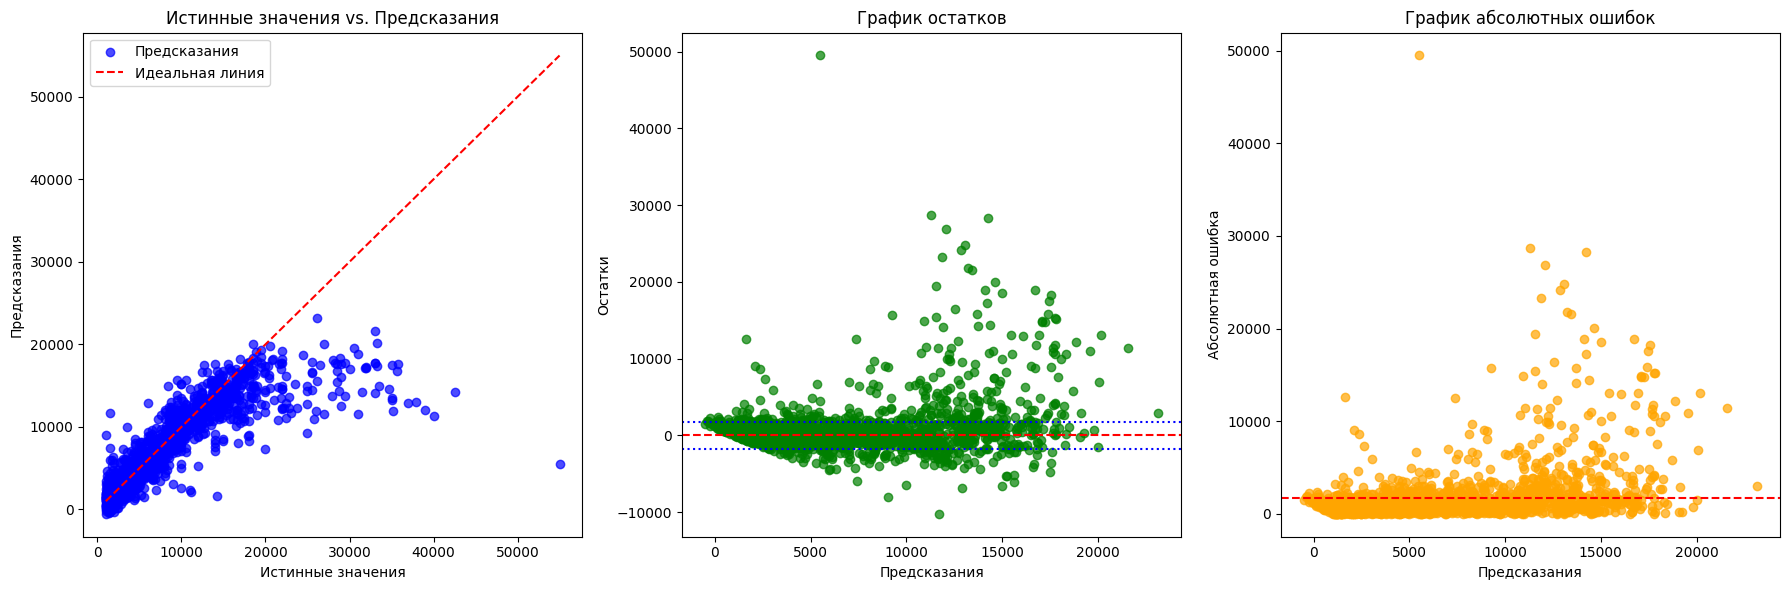

Модель SVR_0.999RMSEstart
----------------------------------------------------------------------
метрика - r2
метрика модели на трейне: 0.83
метрика модели на тесте: 0.73
MAE модели на тесте: 1888.52
метрика лучшей модели на кроссвалидации: 0.76
----------------------------------------------------------------------
Время обучения: 10455.2 сек.
Время предсказания: 11.63 сек.
Лучшие параметры: {'regressor__max_iter': 5000, 'regressor__kernel': 'linear', 'regressor__gamma': 0.0001, 'regressor__C': 1000, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'constant'}


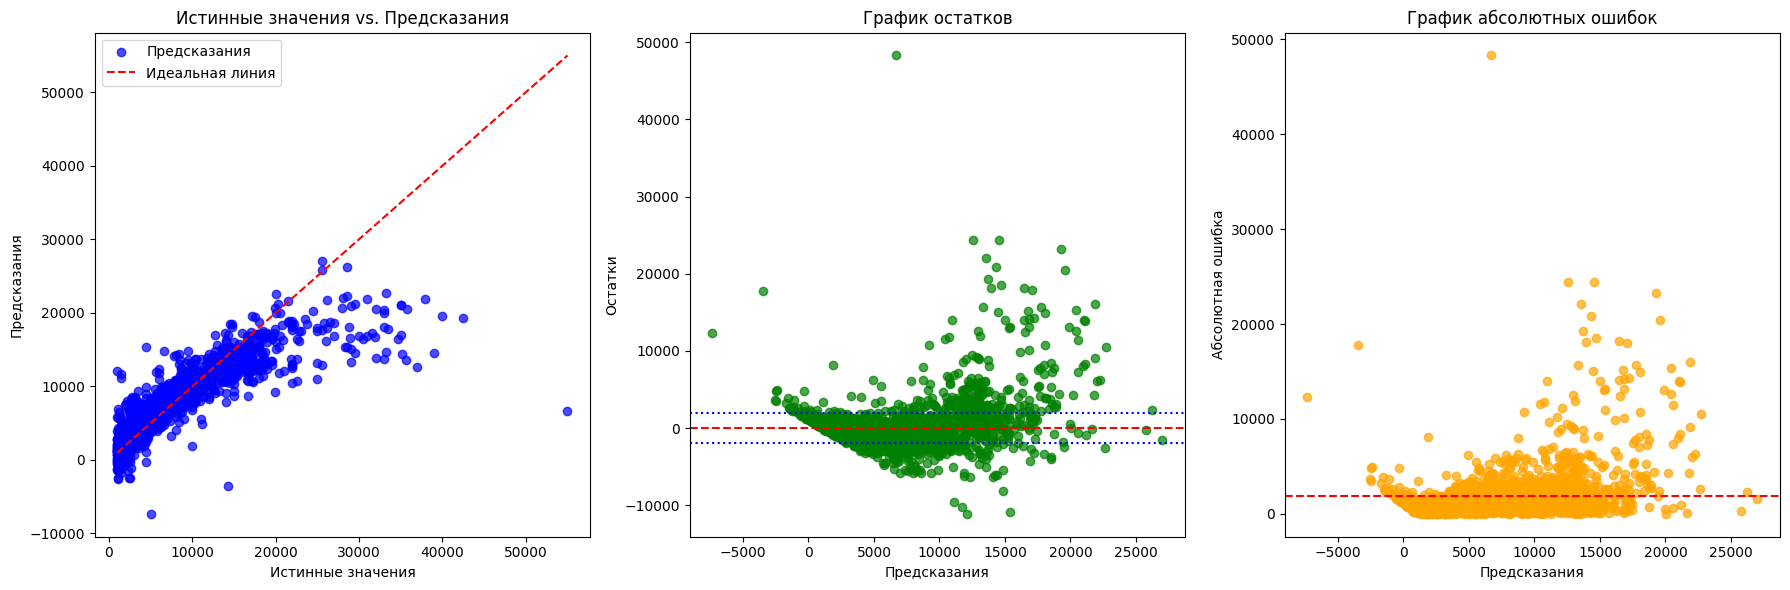

CPU times: total: 15min 38s
Wall time: 11h 41min 4s


model          cv      train        test  test_MAE  \
0   SVR_0.999MAEstart    -1693.96    1173.66     1732.17   1732.17   
1  SVR_0.999MAPEstart       -0.26       0.14        0.26   1732.17   
2   SVR_0.999MSEstart -9803940.13 6879415.48 11642214.61   1888.52   
3  SVR_0.999RMSEstart        0.76       0.83        0.73   1888.52   

   training_time  prediction_time  \
0       10436.30            23.24   
1       10437.27            23.24   
2       10557.71            11.71   
3       10455.20            11.63   

                                                                                                                                                                                                                                                                                                                                                                             best_parametrs  
0      {'regressor__max_iter': 5000, 'regressor__kernel': 'rbf', 'regressor__gamma': 0.1, 'regressor__C': 1000, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'constant'}  
1      {'regressor__max_iter': 5000, 'regressor__kernel': 'rbf', 'regressor__gamma': 0.1, 'regressor__C': 1000, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'constant'}  
2  {'regressor__max_iter': 5000, 'regressor__kernel': 'linear', 'regressor__gamma': 0.0001, 'regressor__C': 1000, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'constant'}  
3  {'regressor__max_iter': 5000, 'regressor__kernel': 'linear', 'regressor__gamma': 0.0001, 'regressor__C': 1000, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'constant'}

In [247]:
%%time
for i, j in enumerate(scor):
    model_name = 'SVR_' + str(multicol) + str(j) + 'start'
    models[model_name] = {}
    model = SVR()
    n_iter = 1000
    pipeline = Pipeline([
        ('preprocessor', preprocessor), 
        ('regressor', model)
    ])

    param_serch = {
        'regressor__C' : [0.1, 1, 10, 100, 1000],
        'regressor__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'regressor__max_iter'  : [100, 1000, 2500, 5000],
        'regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
        
        'regressor__kernel'  : ['linear','rbf'],'preprocessor__cat__onehot': [OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), None],
        'preprocessor__num__scaler': [StandardScaler(with_mean=False), RobustScaler(with_centering=False), None],
        
        'preprocessor__cat__imputer__strategy': ['mean', 'median', 'constant', ],
        'preprocessor__num__imputer__strategy': ['mean', 'median', 'constant', ],   
    }
    
    
    results_models_v1, models  = create_ren_model( model_name, pipeline, 
                                                         param_serch, X_train, 
                                                         X_test, y_train, 
                                                         y_test, scorer[i], scoring[i],
                                                         models, results_models_v1, 
                                                         RS, n_iter)
rm = results_models_v1[results_models_v1['model'].str.contains('SVR', case=False, na=False)].sort_values('test_MAE', ascending=True).reset_index(drop=True)
rm

plot_feature_importance_10(models[rm.loc[0,'model']]['best_model'][1].feature_importances_, 
                           models[rm.loc[0,'model']]['best_model'][0].get_feature_names_out(), 
                           model_name + '_')

## Промежуточные выводы

В ходе работы было обучено много моделей но по результатам решили остановиться на 3х
* `DecisionTreeClassifier` - дерево решений,
* `CatBoostClassifier` - градиентный бустинг.
* `LGBMClassifier` градиентный бустинг.
Лучшие результаты на тесте у `RandomForestClassifier`, на кроссвалидации у `CatBoostClassifier`.

In [251]:
results_models_v1 = results_models_v1.sort_values(['test_MAE'], ascending=True).reset_index(drop=True)
results_models_v1

model           cv      train        test  \
0        CatBoostRegressor_0.999MAEstart     -1259.83     680.81     1343.11   
1       CatBoostRegressor_0.999MAPEstart        -0.22       0.14        0.22   
2        CatBoostRegressor_0.999MSEstart  -4767229.56 1292051.90  6838643.32   
3       CatBoostRegressor_0.999RMSEstart         0.88       0.97        0.84   
4                      SVR_0.999MAEstart     -1693.96    1173.66     1732.17   
5                     SVR_0.999MAPEstart        -0.26       0.14        0.26   
6                     SVR_0.999RMSEstart         0.76       0.83        0.73   
7                      SVR_0.999MSEstart  -9803940.13 6879415.48 11642214.61   
8            LGBMRegressor_0.999MAEstart     -1035.84     306.02     2101.03   
9           LGBMRegressor_0.999MAPEstart        -0.16       0.06        0.40   
10          LGBMRegressor_0.999RMSEstart         0.91       0.99        0.68   
11           LGBMRegressor_0.999MSEstart  -3778971.24  543816.32 13861144.00   
12       LinearRegression_0.999MAPEstart        -0.49       0.23        0.54   
13        LinearRegression_0.999MAEstart     -2178.18     995.69     2375.86   
14        LinearRegression_0.999MSEstart -12193967.18 2593013.50 14427937.27   
15       LinearRegression_0.999RMSEstart         0.70       0.94        0.67   
16  RandomForestRegressor_0.999MAPEstart        -0.15       0.07        0.49   
17  RandomForestRegressor_0.999RMSEstart         0.90       0.98        0.62   
18   RandomForestRegressor_0.999MSEstart  -4248548.89  964914.64 16568177.90   
19   RandomForestRegressor_0.999MAEstart      -992.11     442.04     2387.89   
20   DecisionTreeRegressor_0.999MAEstart     -1283.83     604.16     2541.94   
21  DecisionTreeRegressor_0.999MAPEstart        -0.18       0.07        0.45   
22   DecisionTreeRegressor_0.999MSEstart  -6499175.40 1858824.92 19673567.94   
23  DecisionTreeRegressor_0.999RMSEstart         0.84       0.95        0.55   

    test_MAE  training_time  prediction_time  \
0    1343.11        1161.92             2.14   
1    1343.11        1178.08             2.11   
2    1354.77        1137.90             2.15   
3    1354.77        1139.04             2.14   
4    1732.17       10436.30            23.24   
5    1732.17       10437.27            23.24   
6    1888.52       10455.20            11.63   
7    1888.52       10557.71            11.71   
8    2101.03         518.20             0.02   
9    2110.51         516.17             0.01   
10   2241.89         515.95             0.02   
11   2241.89         516.28             0.02   
12   2368.88         228.23             0.06   
13   2375.86         229.40             0.07   
14   2375.86         230.82             0.06   
15   2375.86         229.31             0.06   
16   2377.89        8464.36             0.05   
17   2384.70        8454.14             0.07   
18   2384.70        8483.46             0.07   
19   2387.89        8466.77             0.09   
20   2541.94         182.11             0.01   
21   2582.65         180.19             0.01   
22   2593.42         180.60             0.01   
23   2593.42         181.31             0.01   

                                                                                                                                                                                                                                                                                                                                                                              best_parametrs  
0                                                          {'regressor__iterations': 1000, 'regressor__depth': 10, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'median'}  
1                                                          {'regres

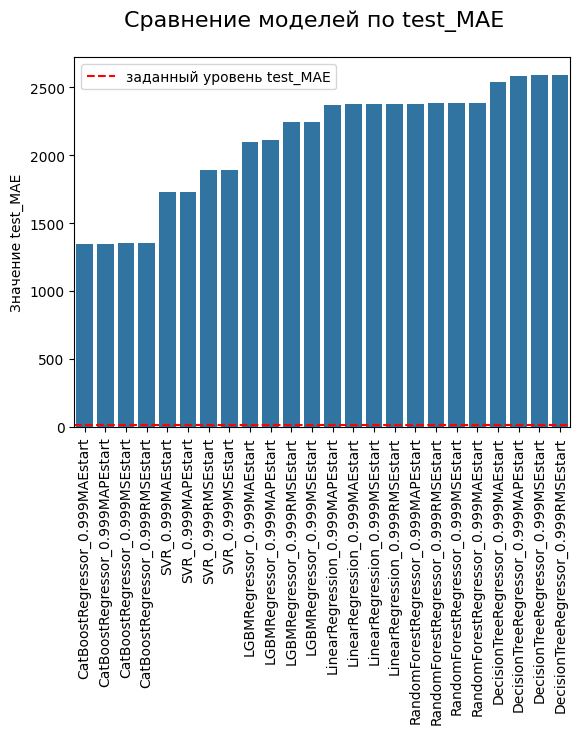

In [252]:
## Покажем диаграмму сравнения моделей по F1
#plt.figure(figsize=(16, 8))
ax = sns.barplot(x=results_models_v1['model'], y=results_models_v1["test_MAE"]) 
plt.suptitle(f'Сравнение моделей по {"test_MAE"}', fontsize=16, ha='center')
ax.set_xlabel('')
ax.set_ylabel(f'Значение {"test_MAE"}')
# добавим линию "отсечки" с целевым F1 0.7
ax.axhline(y = 10, color = 'red',
           label = f'заданный уровень {"test_MAE"}', linestyle='dashed')
plt.legend(loc='upper left')
#ax.bar_label(ax.containers[0], color='black', fontsize=12, fontweight='bold')
plt.xticks(rotation=90)
plt.show();

## Тестирование

In [254]:
top_results_models = results_models_v1.drop_duplicates(subset=['cv', 'train', 'test', 'test_MAE'], keep='last').reset_index(drop=True)
top_results_models

model           cv      train        test  \
0        CatBoostRegressor_0.999MAEstart     -1259.83     680.81     1343.11   
1       CatBoostRegressor_0.999MAPEstart        -0.22       0.14        0.22   
2        CatBoostRegressor_0.999MSEstart  -4767229.56 1292051.90  6838643.32   
3       CatBoostRegressor_0.999RMSEstart         0.88       0.97        0.84   
4                      SVR_0.999MAEstart     -1693.96    1173.66     1732.17   
5                     SVR_0.999MAPEstart        -0.26       0.14        0.26   
6                     SVR_0.999RMSEstart         0.76       0.83        0.73   
7                      SVR_0.999MSEstart  -9803940.13 6879415.48 11642214.61   
8            LGBMRegressor_0.999MAEstart     -1035.84     306.02     2101.03   
9           LGBMRegressor_0.999MAPEstart        -0.16       0.06        0.40   
10          LGBMRegressor_0.999RMSEstart         0.91       0.99        0.68   
11           LGBMRegressor_0.999MSEstart  -3778971.24  543816.32 13861144.00   
12       LinearRegression_0.999MAPEstart        -0.49       0.23        0.54   
13        LinearRegression_0.999MAEstart     -2178.18     995.69     2375.86   
14        LinearRegression_0.999MSEstart -12193967.18 2593013.50 14427937.27   
15       LinearRegression_0.999RMSEstart         0.70       0.94        0.67   
16  RandomForestRegressor_0.999MAPEstart        -0.15       0.07        0.49   
17  RandomForestRegressor_0.999RMSEstart         0.90       0.98        0.62   
18   RandomForestRegressor_0.999MSEstart  -4248548.89  964914.64 16568177.90   
19   RandomForestRegressor_0.999MAEstart      -992.11     442.04     2387.89   
20   DecisionTreeRegressor_0.999MAEstart     -1283.83     604.16     2541.94   
21  DecisionTreeRegressor_0.999MAPEstart        -0.18       0.07        0.45   
22   DecisionTreeRegressor_0.999MSEstart  -6499175.40 1858824.92 19673567.94   
23  DecisionTreeRegressor_0.999RMSEstart         0.84       0.95        0.55   

    test_MAE  training_time  prediction_time  \
0    1343.11        1161.92             2.14   
1    1343.11        1178.08             2.11   
2    1354.77        1137.90             2.15   
3    1354.77        1139.04             2.14   
4    1732.17       10436.30            23.24   
5    1732.17       10437.27            23.24   
6    1888.52       10455.20            11.63   
7    1888.52       10557.71            11.71   
8    2101.03         518.20             0.02   
9    2110.51         516.17             0.01   
10   2241.89         515.95             0.02   
11   2241.89         516.28             0.02   
12   2368.88         228.23             0.06   
13   2375.86         229.40             0.07   
14   2375.86         230.82             0.06   
15   2375.86         229.31             0.06   
16   2377.89        8464.36             0.05   
17   2384.70        8454.14             0.07   
18   2384.70        8483.46             0.07   
19   2387.89        8466.77             0.09   
20   2541.94         182.11             0.01   
21   2582.65         180.19             0.01   
22   2593.42         180.60             0.01   
23   2593.42         181.31             0.01   

                                                                                                                                                                                                                                                                                                                                                                              best_parametrs  
0                                                          {'regressor__iterations': 1000, 'regressor__depth': 10, 'preprocessor__num__scaler': StandardScaler(with_mean=False), 'preprocessor__num__imputer__strategy': 'median', 'preprocessor__cat__onehot': OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), 'preprocessor__cat__imputer__strategy': 'median'}  
1                                                          {'regres

In [255]:
top_index = 1

Выбор индекса лучшей модели

### Проверка лучшей модели на тестовых данных

In [258]:
top_model_bp = eval(top_results_models.loc[top_index, 'best_parametrs'])
final_params = {key.split('__')[1]: value for key, value in top_model_bp.items() if key.startswith('regressor__')}
final_params

{'iterations': 1000, 'depth': 10}

In [259]:
if 'RandomForest'.lower() in top_results_models.loc[top_index, 'model'].lower():
    top_model = RandomForestRegressor(**final_params, random_state=RS, )
    top_preprocessor = top_results_models.loc[top_index, 'model']
elif 'Catboost'.lower() in top_results_models.loc[top_index, 'model'].lower():
    top_model = CatBoostRegressor(**final_params, random_state=RS, silent=True, )
    top_preprocessor = top_results_models.loc[top_index, 'model']
elif 'LGBM'.lower() in top_results_models.loc[top_index, 'model'].lower():
    top_model = LGBMRegressor(**final_params, random_state=RS, )
    top_preprocessor = top_results_models.loc[top_index, 'model']
elif 'SVR'.lower() in top_results_models.loc[top_index, 'model'].lower():
    top_model = SVR(**final_params,  )
    top_preprocessor = top_results_models.loc[top_index, 'model']
elif 'DecisionTreeRegressor'.lower() in top_results_models.loc[top_index, 'model'].lower():
    top_model = DecisionTreeRegressor(**final_params,  )
    top_preprocessor = top_results_models.loc[top_index, 'model']
elif 'LinearRegression'.lower() in top_results_models.loc[top_index, 'model'].lower():
    top_model = LinearRegression(**final_params,  )
    top_preprocessor = top_results_models.loc[top_index, 'model']

In [260]:
top_preprocessor

'CatBoostRegressor_0.999MAPEstart'

In [261]:
final_pipeline = Pipeline([
    ('preprocessor', models[top_preprocessor]['best_model'][0]),
    ('regressor', top_model)
])

In [272]:
final_pipeline = final_pipeline.fit(X_train, y_train)
predictions_test = final_pipeline.predict(X_test)
predictions_train = final_pipeline.predict(X_train)
MAE = round(mean_absolute_error(y_test, predictions_test), 2)
MSE = round(mean_squared_error(y_test, predictions_test), 2)
MAPE = round(mean_absolute_percentage_error(y_test, predictions_test), 2)
RMSE = round(root_mean_squared_error(y_test, predictions_test), 2)

MAE_1 = round(mean_absolute_error(y_train, predictions_train), 2)
print(f'MAE на тестовой выборке: {MAE}')
print('-' * 70)
print(f'MSE на тестовой выборке: {MSE}')
print('-' * 70)
print(f'MAPE на тестовой выборке: {MAPE}')
print('-' * 70)
print(f'RMSE на тестовой выборке: {RMSE}')
print('-' * 70)
print(f'MAE на обучающей выборке: {MAE_1}')

MAE на тестовой выборке: 1343.11
----------------------------------------------------------------------
MSE на тестовой выборке: 6919435.8
----------------------------------------------------------------------
MAPE на тестовой выборке: 0.22
----------------------------------------------------------------------
RMSE на тестовой выборке: 2630.48
----------------------------------------------------------------------
MAE на обучающей выборке: 680.81


**Метрики и матрица ошибок на тренировачных данных:**

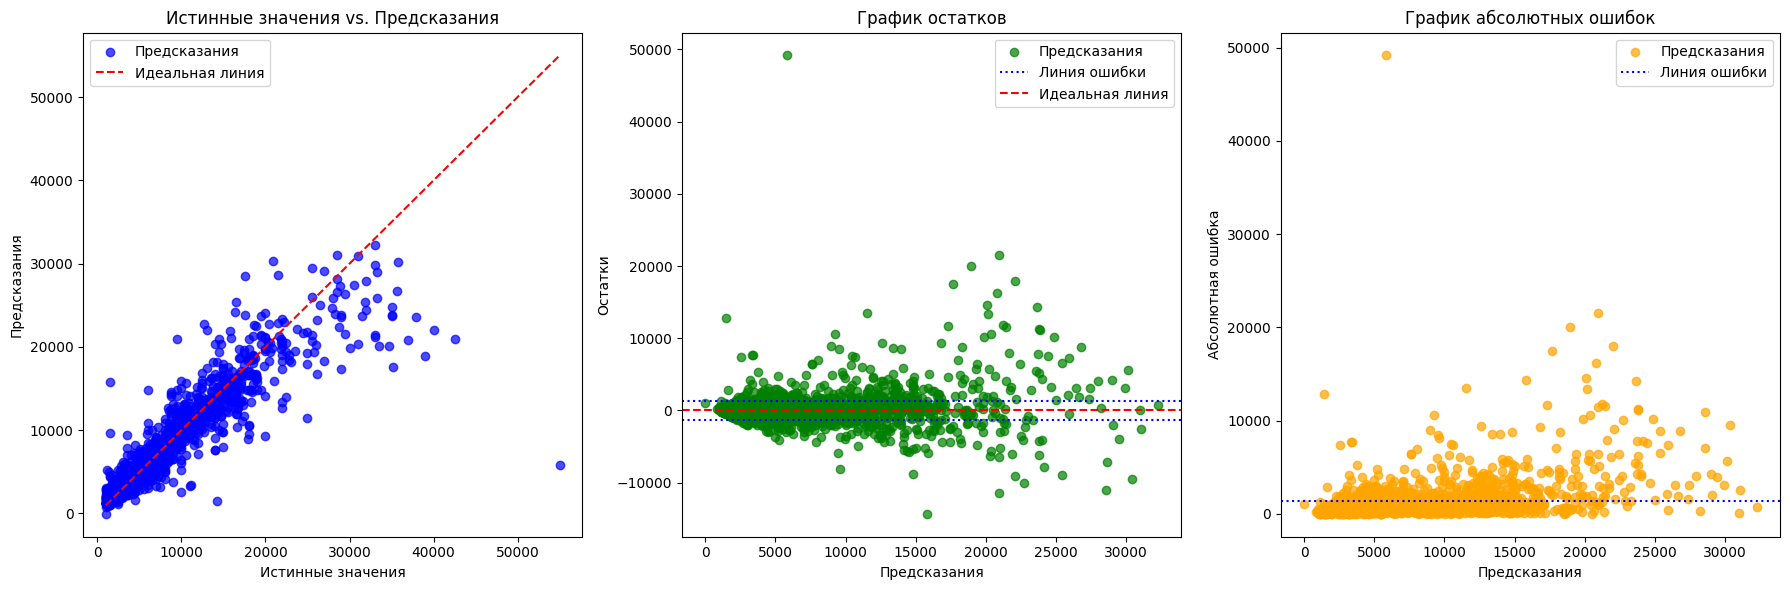

In [275]:
residuals = y_test - predictions_test
absolute_errors = np.abs(residuals)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
axes[0].scatter(y_test, predictions_test, alpha=0.7, color="blue", label="Предсказания")
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--", label="Идеальная линия")
axes[0].set_xlabel("Истинные значения")
axes[0].set_ylabel("Предсказания")
axes[0].set_title("Истинные значения vs. Предсказания")
axes[0].legend()
axes[1].scatter(predictions_test, residuals, color='green', alpha=0.7, label="Предсказания")
axes[1].axhline(y=round(mean_absolute_error(y_test, predictions_test),2), color='blue', linestyle=':', label="Линия ошибки")
axes[1].axhline(y=-round(mean_absolute_error(y_test, predictions_test),2), color='blue', linestyle=':')
axes[1].axhline(y=0, color='red', linestyle='--', label="Идеальная линия")
axes[1].set_xlabel("Предсказания")
axes[1].set_ylabel("Остатки")
axes[1].set_title("График остатков")
axes[1].legend()
axes[2].scatter(predictions_test, absolute_errors, color='orange', alpha=0.7, label="Предсказания")
axes[2].axhline(y=round(mean_absolute_error(y_test, predictions_test),2), color='blue', linestyle=':', label="Линия ошибки")
axes[2].set_xlabel("Предсказания")
axes[2].set_ylabel("Абсолютная ошибка")
axes[2].set_title("График абсолютных ошибок")
axes[2].legend()
plt.tight_layout()
plt.show()

### Оценим влияние признаков

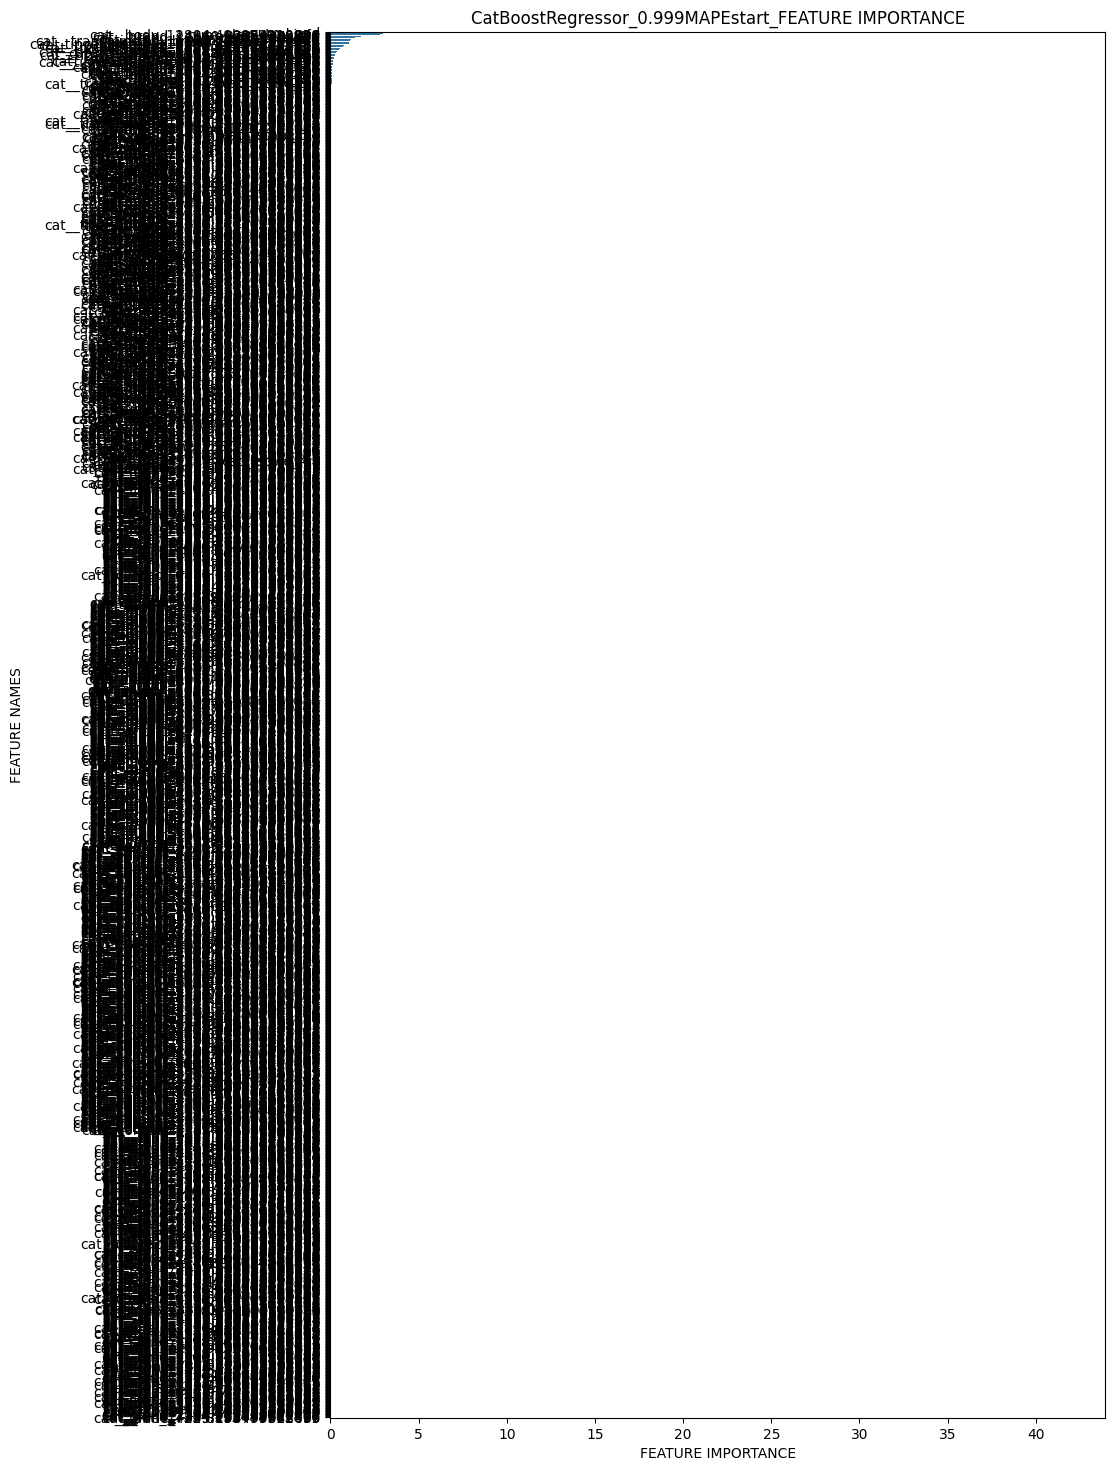

In [278]:
plot_feature_importance(final_pipeline[1].feature_importances_, 
                        final_pipeline[0].get_feature_names_out(), 
                        results_models_v1.loc[top_index, 'model'] + '_')

таблица важности признаков:

In [281]:
pd.DataFrame({'признак':final_pipeline[0].get_feature_names_out(),'важность':final_pipeline[1].feature_importances_}).sort_values('важность', ascending=False).head(10)

признак  важность
1840                      num__god     41.85
1839                   num__volume     19.38
1842             num__len_dop_info      2.99
77    cat__body_12804.490872210954      2.81
55    cat__brend_14660.07756232687      2.58
1841                  num__mileage      1.91
1826                cat__state_1.0      1.75
49    cat__brend_8365.816393442623      1.38
1843             num__mileage_orig      1.33
78     cat__body_14022.16975308642      1.32

## Итоговые выводы

1. **По результатам оценки определено, что лучшей моделью является `RandomForestRegressor` который показал лучшие результаты метрики MAE на тесте на данных как без пропусков, так и на данных с пропусками. Также вне данной работы были произведены тесты на данных с выбросами, метрика на тесте ухудшилать до 8.33**
* **MAE модели на трейне на данных без выбросов: примерно 4.47**
* **MAE модели на трейне на данных с выбросами: примерно 8.37**
* **MAE модели на тесте на данных без выбросов: примерно 8.22**
* **MAE модели на тесте на данных с выбросами: примерно 7.86**
* **MAE лучшей модели на кроссвалидации: примерно 8.17**
3. **Наибольшее влияние на модель оказывают признаки:**
* `num__фв_pct`,
* `num__калий`.
* `num__алт`,    
* `num__натрийуретический_пептид`,
* `num__натрий`
* `cat__фуросемид_дозировка_мг_80.0`,
3. **Модель сохранена в переменной `final_pipeline`**.
